#  Прогнозирование количества заказов такси на следующий час

Компания, занимающаяся пассажирскими перевозками, собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час

---

**Цель исследования:** построить модель, которая будет прогнозировать количество заказов в определённый отрезок времени

---

**План выполнения работы:**

- загрузка и предварительное изучение данных
- предобработка данных
- исследовательский анализ данных
- создание новых признаков и подготовка данных к обучению
- обучение моделей
- выбор лучшей модели
- тестирование итоговой модели

Каждый шаг исследования содержит промежуточный вывод. В конце исследования даётся общий подробный вывод

---

- количество заказов находится в столбце `num_orders`, а дата и время — в столбце `datetime`
- размер тестовой выборки должен быть равен 10% от исходных данных
- итоговая метрика RMSE должна быть не больше 48

---

In [1]:
# установка широкоформатного jupyter

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# импорт библиотек

import os
import copy
from IPython.display import display

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import RandomizedSearchCV, ParameterGrid, train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# константы

RANDOM_STATE = 42
TEST_SIZE = 0.10
FIGSIZE = (15, 5)

TARGET = 'num_orders'
PATH = 'D:\\datasets\\taxi.csv'

---

In [4]:
def get_info(data):
    
    """
    Функция get_info выводит на экран пять случайных строк таблицы и общую информацию, полученную с помощью info()

    Аргументы:
    data (DataFrame): датафрейм

    """
    
    print('Пять случайных строк таблицы:')
    display(data.sample(5))
    print(' ')
    print('Общая информация о таблице:')
    print(' ')
    print(data.info())

In [5]:
def lineplot(data):
    
    """
    Функция lineplot строит линейный график для визуализации временного ряда
    
    Аргументы:
    data (DataFrame) : датафрейм
    
    """
    
    sns.set(style='darkgrid')
    
    plt.figure(figsize=FIGSIZE)
    sns.lineplot(data=data, x='datetime', y='num_orders', color='#f0c188')
    
    plt.title('График количества заказов по времени', fontsize=16)
    plt.xlabel('Дата и время')
    plt.ylabel('Количество заказов')
    
    plt.show()

In [6]:
def rolling_mean_plot(data):
    
    """
    Функция rolling_mean_plot создаёт график скользящего среднего
    
    Аргументы:
    data (DataFrame) : датафрейм
    
    """
    
    sns.set(style='darkgrid')

    plt.figure(figsize=FIGSIZE)
    sns.lineplot(data=data, x='datetime', y='num_orders', color='#518b94')

    plt.title('Скользящее среднее', fontsize=16)
    plt.xlabel('Месяц', fontsize=12)
    plt.ylabel('Среднее количество заказов', fontsize=12)

    plt.show()

In [7]:
def seasonal_decompose_plots(decomposed_data):
    
    """
    Функция seasonal_decompose_plots раскладывает временной ряд на три составляющие:
    тренд, сезонность и остаток; для каждой составляющей строит линейный график
    
    Аргументы:
    decomposed_data (DecomposeResult) : объект структуры DecomposeResult
    
    """
    
    sns.set(style="darkgrid")

    plt.figure(figsize=(12.5, 12))

    plt.subplot(3, 1, 1)
    decomposed_data.trend.plot(ax=plt.gca(), color="#51947c")
    plt.title('Тренд', fontsize=16)
    plt.xlabel('Месяц')
    plt.ylabel('Количество заказов')

    plt.subplot(3, 1, 2)
    decomposed_data.seasonal.plot(ax=plt.gca(), color="#518b94")
    plt.title('Сезонность', fontsize=16)
    plt.xlabel('Месяц')
    plt.ylabel('Количество заказов')

    plt.subplot(3, 1, 3)
    decomposed_data.resid.plot(ax=plt.gca(), color="#516a94")
    plt.title('Остатки', fontsize=16)
    plt.xlabel('Месяц')
    plt.ylabel('Количество заказов')

    plt.tight_layout()

    plt.show()

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    
    """
    Функция make_features создаёт и присваивает исходному датафрейму три новых признака:
    3 календарных признака, «отстающие значения» и скользящее среднее
    
    Аргуменрты:
    data (DataFrame) : датафрейм
    max_lag (int) : максимальный размер отставания
    rolling_mean_size (int) : ширина окна
    
    """
    
    # календарные признаки
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # «отстающие значения»
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # скользящее среднее   
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [9]:
def split(data, target):
    
    """
    Функция split делит исходные данные на тренировочную и тестовую выборки
    
    Аргументы:
    data (DataFrame) : датафрейм
    target (str) : название столбца с целевым признаком
    
    """
    
    X = data.drop(columns=target, axis=1)
    y = data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        shuffle=False,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )
    
    return X_train, X_test, y_train, y_test

In [10]:
def train_test_size(X_train, X_test, y_train, y_test):
                                    
    """
    Функция train_test_size выводит на экран размерность разделённых на выборки данных
    
    Аргументы:
    X_train (DataFrame) : входные признаки тренировочной выборки
    X_test (DataFrame) : входные признаки тестовой выборки
    y_train (Series) : целевой признак тренировочной выборки
    y_test (Series) : целевой признак тестовой выборки
    
    """

    print('Тренировочная выборка')
    print(f'Размерность матрицы со входными признаками: {X_train.shape}')
    print(f'Размерность матрицы с целевым признаком: {y_train.shape}')
    print(' ')
    print('Тестовая выборка')
    print(f'Размерность матрицы со входными признаками: {X_test.shape}')
    print(f'Размерность матрицы с целевым признаком: {y_test.shape}')

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Загрузка и предварительное изучение данных
</div>

---

In [11]:
# загрузка данных

if os.path.exists(PATH):
    filename = os.path.basename(PATH)
    print(f'Файл {filename} успешно загружен!')
    taxi = pd.read_csv(PATH, parse_dates=[0], index_col=[0])
else:
    print(f'Упс, что-то пошло не так при загрузке файла {os.path.basename(PATH)}!')

Файл taxi.csv успешно загружен!


In [12]:
# изучим общую информацию о таблице

get_info(taxi)

Пять случайных строк таблицы:


,num_orders
datetime,
2018-05-25 05:50:00,0
2018-07-19 11:40:00,16
2018-06-29 15:20:00,10
2018-07-17 09:40:00,10
2018-06-21 18:40:00,11


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


- загруженая таблица содержит 26496 строк и 1 столбец
- названия столбцов не требуют переименования
- столбец `datetime` корректно назначен индексом
- тип данных в столбце `num_orders` определён верно
- в таблице нет пропусков

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Таблица успешно загружена, данные полностью соответствуют описанию. Типы данных и названия столбцов не требуют изменений, пропусков в таблице не обнаружено
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Предобработка данных
</div>

---

In [13]:
# отсортируем таблицу по значению индекса

taxi = taxi.sort_index()

In [14]:
# проверим, расположены ли данные в хронологическом порядке

if taxi.index.is_monotonic_increasing == True:
    print('Данные о времени расположены в хронологическом порядке!')
else:
    print('Данные о времени расположены НЕ в хронологическом порядке')

Данные о времени расположены в хронологическом порядке!


In [15]:
# выполним ресемплирование по одному часу, суммировав количество заказов по этому интервалу

taxi = taxi.resample('1H').sum()

In [16]:
# проверим результат

get_info(taxi)

Пять случайных строк таблицы:


,num_orders
datetime,
2018-07-25 23:00:00,138
2018-05-25 08:00:00,90
2018-03-16 19:00:00,65
2018-07-20 09:00:00,137
2018-08-23 08:00:00,113


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Дата и время определены индексом и расположены в хронологическом порядке. Временной интервал был изменён с 10 минут на 1 час, а по этому интервалу суммировано количество заказов
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Исследовательский анализ данных
</div>

---

In [17]:
# выведем на экран минимальное и максимальное значения даты и времени в таблице

print(f'Минимальное значение даты и времени: {taxi.index.min()}')
print(f'Максимальное значение даты и времени: {taxi.index.max()}')

Минимальное значение даты и времени: 2018-03-01 00:00:00
Максимальное значение даты и времени: 2018-08-31 23:00:00


В нашем распоряжении находятся данные в промежутке от полуночи 1 марта 2018 года до одиннадцати вечера 31 августа 2018 года. Построим график, отображающий почасовое количество заказов такси

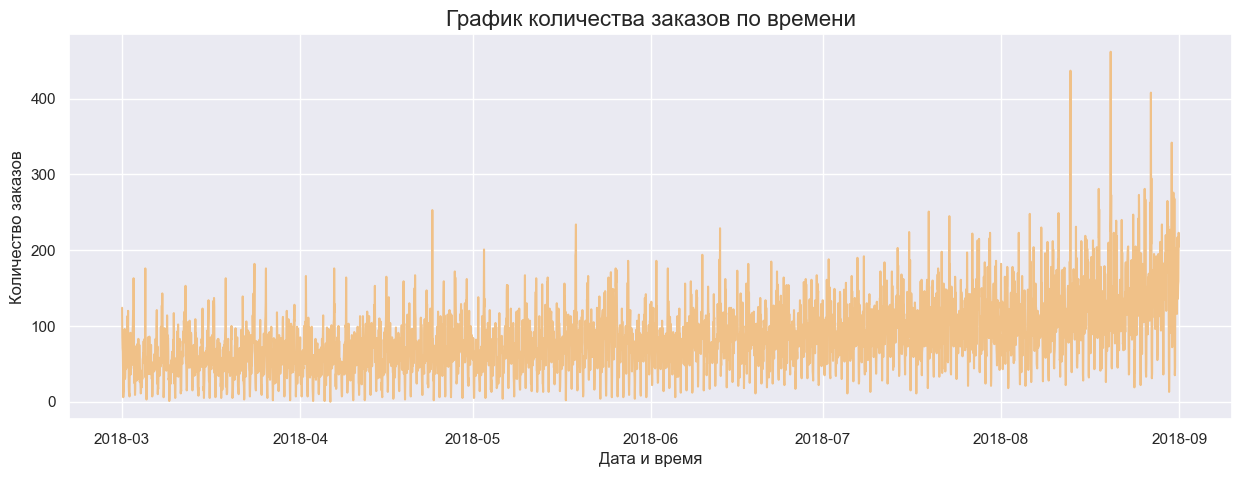

In [18]:
# построим линейный график

lineplot(taxi)

До начала августа почасовое количество заказов в сервисе обычно не превышало 200-300 штук. В начале августа количество заказов резко возросло. Неизвестно, с чем это может быть связано — может, сервис запустил новую акцию или успешную рекламу, а может, спрос на такси растёт в конце августа каждого года, то есть, регулярно

Чтобы сгладить данные, вычислим *скользящее среднее*. Оно покажет значения, которые меньше всего подвержены колебаниям — то есть, среднее арифметическое

In [19]:
# создадим переменную со скользящим средним

rolling_mean = taxi.rolling(100).mean()

In [20]:
# проверим результат

display(rolling_mean.head(), rolling_mean.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4317 non-null   float64
dtypes: float64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,NaN
2018-03-01 01:00:00,NaN
2018-03-01 02:00:00,NaN
2018-03-01 03:00:00,NaN
2018-03-01 04:00:00,NaN


None

In [21]:
# удалим пропуски

rolling_mean = rolling_mean.dropna()

In [22]:
# проверим результат

get_info(rolling_mean)

Пять случайных строк таблицы:


,num_orders
datetime,
2018-08-11 08:00:00,110.71
2018-04-07 09:00:00,55.95
2018-04-27 10:00:00,66.98
2018-07-19 20:00:00,98.79
2018-03-23 22:00:00,57.69


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4317 entries, 2018-03-05 03:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4317 non-null   float64
dtypes: float64(1)
memory usage: 67.5 KB
None


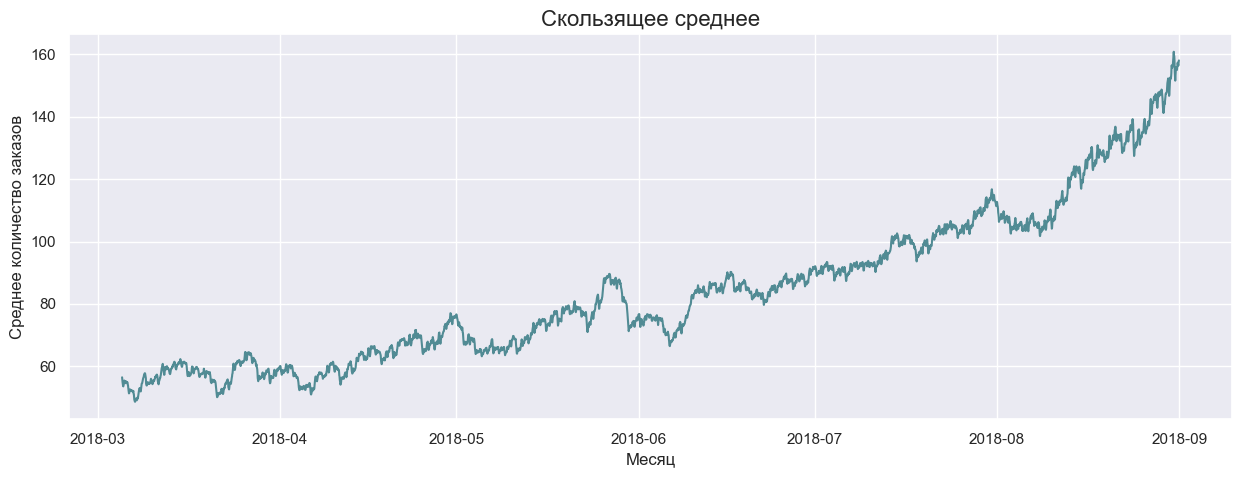

In [23]:
# построим график скользящего среднего

rolling_mean_plot(rolling_mean)

Снова видим плавный рост количества заказов со временем, пик в текущих данных приходится на последний месяц. Чтобы лучше понимать временной ряд, разберём тренды и сезонность

In [24]:
# применим функцию seasonal_decompose

decomposed = seasonal_decompose(taxi)

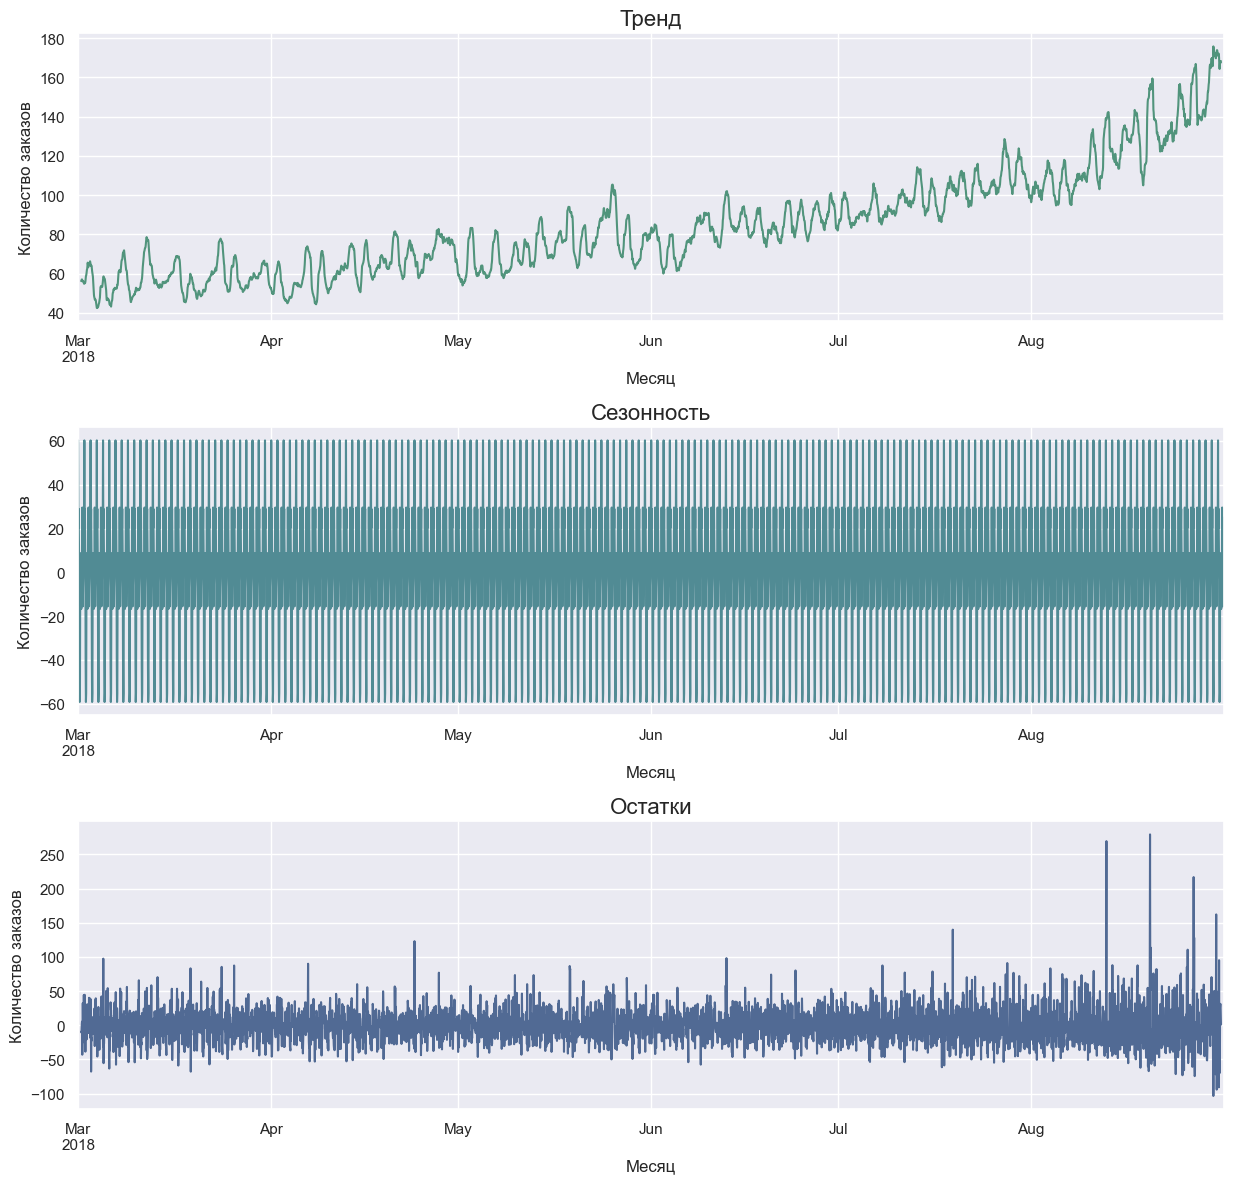

In [25]:
# выведем графики на экран

seasonal_decompose_plots(decomposed)

**Тренд** — это плавное изменение среднего значения ряда без повторяющихся закономерностей. Снова видим, как количество заказов плавно стремится вверх

**Сезонность** — циклично повторяющиеся закономерности во временном ряду. В нашем случае у сезонности период меньше недели, его можно исследователь и поближе

**Остатки** необъяснимы. Это компонента, которая не объясняется трендом и сезонностью, это шум. Здесь они колеблятся в районе нуля, за исключением августовских выбросов

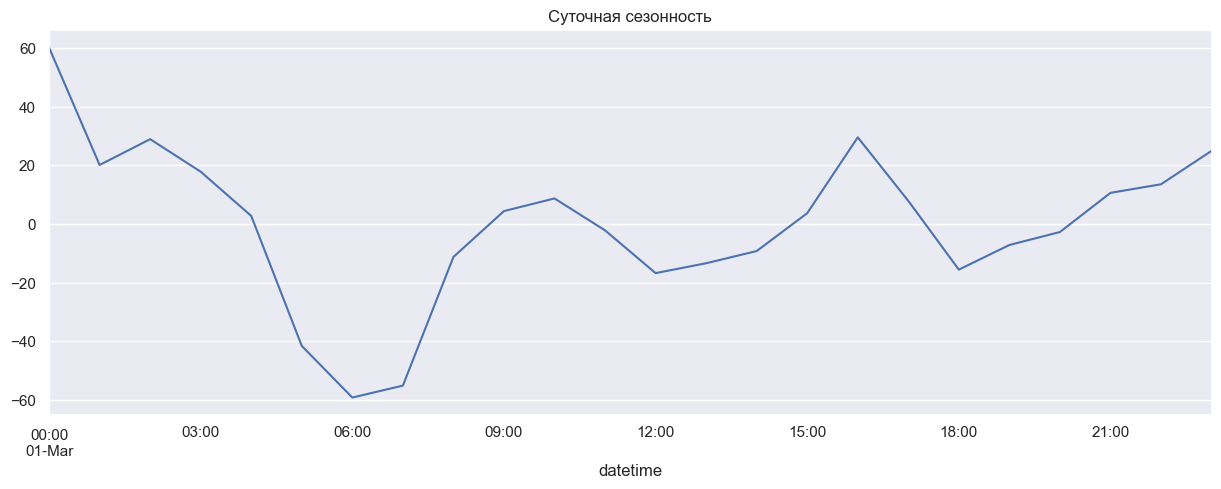

In [26]:
# построим график для суточной сезонности

plt.figure(figsize=FIGSIZE)
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(ax=plt.gca())

plt.title('Суточная сезонность')
plt.show()

Около полуночи количество заказов является пиковым, затем плавно снижается к 6 утра. Это объяснимо, в полночь общественный транспорт уже не работает, а к 6 утра все, как правило, уже спят. Ещё один пик — примерно в 9 утра, как раз когда людям нужно спешить на работу. К 12 часам дня количество заказов падает снова, в 16-17 часов — снова пик, в 18 — снижение, а затем плавный рост, переходящий в полночь

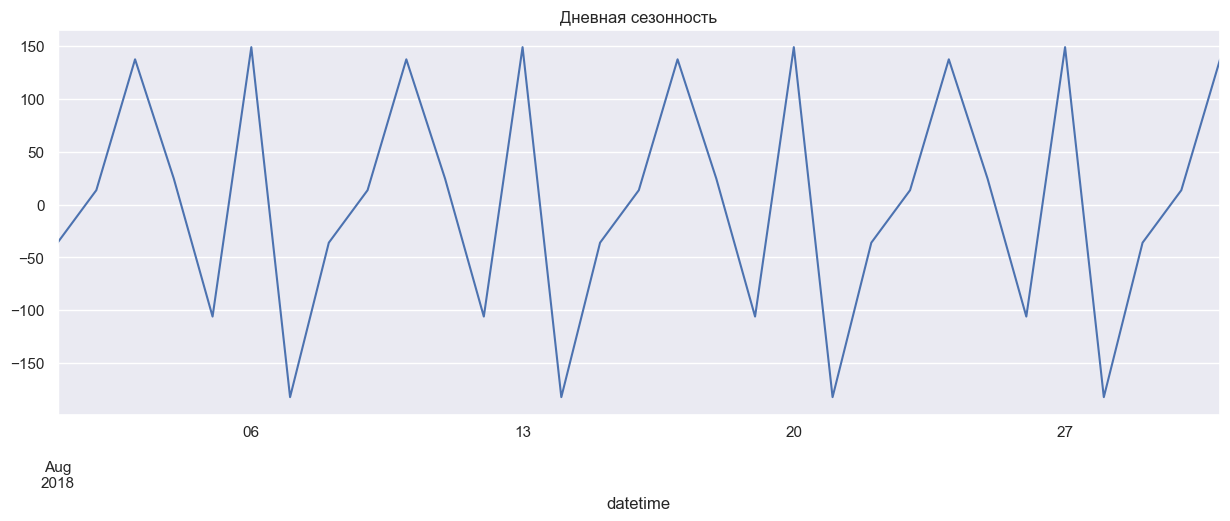

In [27]:
# построим график для дневной сезонности

decomposed_by_day = seasonal_decompose(taxi.resample('D').sum())

plt.figure(figsize=FIGSIZE)
plt.title('Дневная сезонность')
decomposed_by_day.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.show()

Подтверждается догадка о том, что сезонность в этих данных имеет период чуть меньше недели. Так, количество заказов постепенно растёт с начала недели до её середины, затем резко падает и снова резко растёт на выходных

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Создание новых признаков. Подготовка данных к обучению
</div>

---

В качестве новых признаков и на основании полученной с помощью графиков информации создадим: *календарные признаки*, такие как месяц, день месяца и день недели, *скользящее среднее*, которое в качестве признака задаёт общий тренд временного ряда и, наконец, *«отстающие значения»*

In [28]:
# применим функцию make_features

make_features(taxi, 52, 28)

In [29]:
# проверим результат

display(taxi.columns)

Index(['num_orders', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31',
       'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38',
       'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44', 'lag_45',
       'lag_46', 'lag_47', 'lag_48', 'lag_49', 'lag_50', 'lag_51', 'lag_52',
       'rolling_mean'],
      dtype='object')

In [30]:
# проверим результат

taxi.shape

(4416, 57)

---

In [31]:
# разделим данные на тренировочную и тестовую выборки

train, test = train_test_split(taxi, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [32]:
# удалим пропуски в тренировочной выборке

train = train.dropna()

In [33]:
# выделим входные и целевой признаки

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [34]:
# проверим результат

train_test_size(X_train, X_test, y_train, y_test)

Тренировочная выборка
Размерность матрицы со входными признаками: (3922, 56)
Размерность матрицы с целевым признаком: (3922,)
 
Тестовая выборка
Размерность матрицы со входными признаками: (442, 56)
Размерность матрицы с целевым признаком: (442,)


In [35]:
# проверим корректность размера тестовой выборки

print(f'Размер тестовой выборки относительно изначального набора данных: {X_test.shape[0] / taxi.shape[0]}')

Размер тестовой выборки относительно изначального набора данных: 0.10009057971014493


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Созданые новые столбцы-признаки: `month`, `day`, `dayofweek`, `rolling_mean`, а также столбцы, отображающие отстающие значения. Данные успешно разделены на тренировочную и тестовую выборки, исходное требование к размеру тестовой выборки (10% от начальных данных) соблюдено
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Обучение моделей
</div>

---

## `LinearRegression`

In [36]:
# инициализируем модель

model_1 = LinearRegression()

In [37]:
# обучим модель

model_1.fit(X_train, y_train)

LinearRegression()

In [38]:
# выполним предсказание на тренировочной выборке

y_train_pred_1 = model_1.predict(X_train)

In [39]:
# посчитаем метрику RMSE

rmse_train_1 = mean_squared_error(y_train, y_train_pred_1, squared=False)

In [40]:
# выведем результат на экран

print('RMSE на тренировочной выборке:', rmse_train_1)

RMSE на тренировочной выборке: 23.286511229736472


## `DecisionTreeRegressor`

In [41]:
# инициализируем модель

model_2 = DecisionTreeRegressor()

In [42]:
# определим схему разделения временного ряда

tscv_2 = TimeSeriesSplit(n_splits=15)

In [43]:
# запишем гиперпараметры для модели

param_grid_2 = {
        'max_depth': range(1, 50),
        'min_samples_leaf': range(1, 50),
        'min_samples_split': range(2, 50)
}

In [44]:
# выполним кросс-валидацию

rs_2 = RandomizedSearchCV(model_2,
                          param_distributions=param_grid_2, 
                          n_jobs=-1, 
                          cv=tscv_2, 
                          verbose=False,
                          random_state=RANDOM_STATE)

rs_2.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=15, test_size=None),
                   estimator=DecisionTreeRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': range(1, 50),
                                        'min_samples_leaf': range(1, 50),
                                        'min_samples_split': range(2, 50)},
                   random_state=42, verbose=False)

In [45]:
# выполним предсказание на тренировочной выборке

y_train_pred_2 = rs_2.predict(X_train)

In [46]:
# посчитаем метрику RMSE

rmse_train_2 = mean_squared_error(y_train, y_train_pred_2, squared=False)

In [47]:
# выведем результат на экран

print('RMSE на тренировочной выборке:', rmse_train_2)

RMSE на тренировочной выборке: 21.59171393670548


## `CatBoostRegressor`

In [48]:
# инициализируем модель

model_3 = CatBoostRegressor()

In [49]:
# определим схему разделения временного ряда

tscv_3 = TimeSeriesSplit(n_splits=5) 

In [50]:
# запишем гиперпараметры для модели

param_grid_3 = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'random_strength': [0.1, 0.5, 1]
}

In [51]:
# выполним кросс-валидацию

rs_3 = RandomizedSearchCV(model_3, param_grid_3, cv=tscv_3, random_state=RANDOM_STATE)

rs_3.fit(X_train, y_train)

0:	learn: 27.9753165	total: 139ms	remaining: 13.8s
1:	learn: 26.7403046	total: 141ms	remaining: 6.92s
2:	learn: 25.6803888	total: 142ms	remaining: 4.6s
3:	learn: 24.7551245	total: 143ms	remaining: 3.44s
4:	learn: 23.8828658	total: 144ms	remaining: 2.74s
5:	learn: 23.0853846	total: 145ms	remaining: 2.27s
6:	learn: 22.3776738	total: 146ms	remaining: 1.94s
7:	learn: 21.7624100	total: 147ms	remaining: 1.69s
8:	learn: 21.2403492	total: 148ms	remaining: 1.49s
9:	learn: 20.7656346	total: 149ms	remaining: 1.34s
10:	learn: 20.2735561	total: 150ms	remaining: 1.21s
11:	learn: 19.8187147	total: 151ms	remaining: 1.1s
12:	learn: 19.4487174	total: 151ms	remaining: 1.01s
13:	learn: 19.1382011	total: 152ms	remaining: 935ms
14:	learn: 18.8571659	total: 153ms	remaining: 868ms
15:	learn: 18.5642946	total: 154ms	remaining: 809ms
16:	learn: 18.3296429	total: 155ms	remaining: 757ms
17:	learn: 18.1068740	total: 156ms	remaining: 710ms
18:	learn: 17.8646626	total: 157ms	remaining: 667ms
19:	learn: 17.6535992	to

0:	learn: 30.4937081	total: 1.7ms	remaining: 168ms
1:	learn: 29.2418311	total: 2.99ms	remaining: 147ms
2:	learn: 28.1189185	total: 4.02ms	remaining: 130ms
3:	learn: 27.0927472	total: 5.1ms	remaining: 122ms
4:	learn: 26.2005931	total: 6.22ms	remaining: 118ms
5:	learn: 25.3901202	total: 7.28ms	remaining: 114ms
6:	learn: 24.6880494	total: 8.34ms	remaining: 111ms
7:	learn: 24.0719069	total: 9.48ms	remaining: 109ms
8:	learn: 23.5612938	total: 10.5ms	remaining: 106ms
9:	learn: 23.0678619	total: 11.5ms	remaining: 103ms
10:	learn: 22.6221327	total: 12.5ms	remaining: 101ms
11:	learn: 22.2398189	total: 13.9ms	remaining: 102ms
12:	learn: 21.8855648	total: 15.2ms	remaining: 102ms
13:	learn: 21.5951567	total: 16.3ms	remaining: 100ms
14:	learn: 21.3119233	total: 17.7ms	remaining: 100ms
15:	learn: 21.0772346	total: 18.8ms	remaining: 98.9ms
16:	learn: 20.8463908	total: 20.2ms	remaining: 98.4ms
17:	learn: 20.6475868	total: 21.2ms	remaining: 96.7ms
18:	learn: 20.4678328	total: 22.3ms	remaining: 95.2ms
1

64:	learn: 19.5260922	total: 87.5ms	remaining: 47.1ms
65:	learn: 19.4827286	total: 88.8ms	remaining: 45.7ms
66:	learn: 19.4491594	total: 90ms	remaining: 44.3ms
67:	learn: 19.4177105	total: 91.1ms	remaining: 42.9ms
68:	learn: 19.3905248	total: 92.3ms	remaining: 41.5ms
69:	learn: 19.3667764	total: 93.5ms	remaining: 40.1ms
70:	learn: 19.3421573	total: 94.7ms	remaining: 38.7ms
71:	learn: 19.3002819	total: 95.8ms	remaining: 37.3ms
72:	learn: 19.2643083	total: 97.1ms	remaining: 35.9ms
73:	learn: 19.2281522	total: 98.2ms	remaining: 34.5ms
74:	learn: 19.2014295	total: 99.3ms	remaining: 33.1ms
75:	learn: 19.1890501	total: 100ms	remaining: 31.7ms
76:	learn: 19.1586895	total: 102ms	remaining: 30.3ms
77:	learn: 19.1283368	total: 103ms	remaining: 29ms
78:	learn: 19.1220328	total: 104ms	remaining: 27.6ms
79:	learn: 19.0820682	total: 105ms	remaining: 26.3ms
80:	learn: 19.0442089	total: 106ms	remaining: 24.9ms
81:	learn: 19.0415075	total: 107ms	remaining: 23.5ms
82:	learn: 19.0154796	total: 108ms	rema

53:	learn: 17.2154475	total: 63.3ms	remaining: 53.9ms
54:	learn: 17.1688512	total: 64.4ms	remaining: 52.7ms
55:	learn: 17.1382585	total: 65.4ms	remaining: 51.4ms
56:	learn: 17.0817734	total: 66.5ms	remaining: 50.2ms
57:	learn: 17.0356001	total: 67.6ms	remaining: 48.9ms
58:	learn: 16.9973629	total: 68.6ms	remaining: 47.7ms
59:	learn: 16.9436586	total: 69.9ms	remaining: 46.6ms
60:	learn: 16.9001955	total: 71.1ms	remaining: 45.5ms
61:	learn: 16.8453448	total: 72.4ms	remaining: 44.4ms
62:	learn: 16.7921787	total: 73.7ms	remaining: 43.3ms
63:	learn: 16.7538315	total: 74.8ms	remaining: 42.1ms
64:	learn: 16.6861510	total: 75.8ms	remaining: 40.8ms
65:	learn: 16.6446705	total: 76.8ms	remaining: 39.6ms
66:	learn: 16.5890675	total: 77.9ms	remaining: 38.4ms
67:	learn: 16.5383842	total: 78.8ms	remaining: 37.1ms
68:	learn: 16.4908345	total: 79.7ms	remaining: 35.8ms
69:	learn: 16.4627799	total: 80.8ms	remaining: 34.6ms
70:	learn: 16.4127783	total: 81.8ms	remaining: 33.4ms
71:	learn: 16.3786408	total:

0:	learn: 27.9689690	total: 2.85ms	remaining: 2.85s
1:	learn: 26.8149020	total: 5.29ms	remaining: 2.64s
2:	learn: 25.8994338	total: 7.43ms	remaining: 2.47s
3:	learn: 24.9931537	total: 9.44ms	remaining: 2.35s
4:	learn: 24.1056839	total: 11.3ms	remaining: 2.24s
5:	learn: 23.4012836	total: 13.1ms	remaining: 2.17s
6:	learn: 22.7901452	total: 15.1ms	remaining: 2.14s
7:	learn: 22.0965361	total: 17.3ms	remaining: 2.14s
8:	learn: 21.5339830	total: 19.5ms	remaining: 2.15s
9:	learn: 20.9847028	total: 21.4ms	remaining: 2.11s
10:	learn: 20.5427392	total: 23ms	remaining: 2.07s
11:	learn: 20.1503180	total: 25.2ms	remaining: 2.07s
12:	learn: 19.7684446	total: 26.6ms	remaining: 2.02s
13:	learn: 19.4076741	total: 28.3ms	remaining: 1.99s
14:	learn: 19.0843688	total: 29.8ms	remaining: 1.95s
15:	learn: 18.8450396	total: 31.6ms	remaining: 1.94s
16:	learn: 18.4326699	total: 33.3ms	remaining: 1.92s
17:	learn: 18.1078491	total: 35ms	remaining: 1.91s
18:	learn: 17.8779056	total: 36.7ms	remaining: 1.89s
19:	lea

222:	learn: 5.0252047	total: 400ms	remaining: 1.39s
223:	learn: 4.9957204	total: 402ms	remaining: 1.39s
224:	learn: 4.9648339	total: 404ms	remaining: 1.39s
225:	learn: 4.9402042	total: 406ms	remaining: 1.39s
226:	learn: 4.9027699	total: 408ms	remaining: 1.39s
227:	learn: 4.8682545	total: 410ms	remaining: 1.39s
228:	learn: 4.8412885	total: 412ms	remaining: 1.39s
229:	learn: 4.8082350	total: 414ms	remaining: 1.39s
230:	learn: 4.7817904	total: 416ms	remaining: 1.38s
231:	learn: 4.7447279	total: 417ms	remaining: 1.38s
232:	learn: 4.7098075	total: 419ms	remaining: 1.38s
233:	learn: 4.6752162	total: 421ms	remaining: 1.38s
234:	learn: 4.6718507	total: 423ms	remaining: 1.38s
235:	learn: 4.6419987	total: 425ms	remaining: 1.38s
236:	learn: 4.6190210	total: 428ms	remaining: 1.38s
237:	learn: 4.5985310	total: 429ms	remaining: 1.37s
238:	learn: 4.5704047	total: 431ms	remaining: 1.37s
239:	learn: 4.5504572	total: 433ms	remaining: 1.37s
240:	learn: 4.5243959	total: 434ms	remaining: 1.37s
241:	learn: 

443:	learn: 1.6364764	total: 793ms	remaining: 993ms
444:	learn: 1.6253249	total: 795ms	remaining: 991ms
445:	learn: 1.6186446	total: 796ms	remaining: 989ms
446:	learn: 1.6136313	total: 798ms	remaining: 987ms
447:	learn: 1.6048386	total: 799ms	remaining: 985ms
448:	learn: 1.5967307	total: 801ms	remaining: 983ms
449:	learn: 1.5919440	total: 803ms	remaining: 981ms
450:	learn: 1.5849006	total: 805ms	remaining: 980ms
451:	learn: 1.5769813	total: 806ms	remaining: 978ms
452:	learn: 1.5761673	total: 809ms	remaining: 977ms
453:	learn: 1.5673000	total: 811ms	remaining: 975ms
454:	learn: 1.5640836	total: 813ms	remaining: 974ms
455:	learn: 1.5604981	total: 814ms	remaining: 971ms
456:	learn: 1.5511206	total: 816ms	remaining: 970ms
457:	learn: 1.5358865	total: 818ms	remaining: 968ms
458:	learn: 1.5209166	total: 820ms	remaining: 966ms
459:	learn: 1.5093036	total: 821ms	remaining: 964ms
460:	learn: 1.5085124	total: 823ms	remaining: 963ms
461:	learn: 1.5044480	total: 825ms	remaining: 961ms
462:	learn: 

663:	learn: 0.5729479	total: 1.19s	remaining: 602ms
664:	learn: 0.5703953	total: 1.19s	remaining: 600ms
665:	learn: 0.5660612	total: 1.19s	remaining: 598ms
666:	learn: 0.5635805	total: 1.19s	remaining: 597ms
667:	learn: 0.5602649	total: 1.2s	remaining: 595ms
668:	learn: 0.5566886	total: 1.2s	remaining: 593ms
669:	learn: 0.5546426	total: 1.2s	remaining: 591ms
670:	learn: 0.5511746	total: 1.2s	remaining: 589ms
671:	learn: 0.5507220	total: 1.2s	remaining: 588ms
672:	learn: 0.5470895	total: 1.21s	remaining: 586ms
673:	learn: 0.5454855	total: 1.21s	remaining: 584ms
674:	learn: 0.5417868	total: 1.21s	remaining: 582ms
675:	learn: 0.5390051	total: 1.21s	remaining: 580ms
676:	learn: 0.5386498	total: 1.21s	remaining: 578ms
677:	learn: 0.5355143	total: 1.21s	remaining: 577ms
678:	learn: 0.5336106	total: 1.22s	remaining: 575ms
679:	learn: 0.5314553	total: 1.22s	remaining: 573ms
680:	learn: 0.5300922	total: 1.22s	remaining: 572ms
681:	learn: 0.5261264	total: 1.22s	remaining: 570ms
682:	learn: 0.521

883:	learn: 0.1915928	total: 1.58s	remaining: 208ms
884:	learn: 0.1902954	total: 1.59s	remaining: 206ms
885:	learn: 0.1902211	total: 1.59s	remaining: 205ms
886:	learn: 0.1899812	total: 1.59s	remaining: 203ms
887:	learn: 0.1890662	total: 1.59s	remaining: 201ms
888:	learn: 0.1878294	total: 1.59s	remaining: 199ms
889:	learn: 0.1864190	total: 1.6s	remaining: 197ms
890:	learn: 0.1860730	total: 1.6s	remaining: 196ms
891:	learn: 0.1857387	total: 1.6s	remaining: 194ms
892:	learn: 0.1849526	total: 1.6s	remaining: 192ms
893:	learn: 0.1839446	total: 1.6s	remaining: 190ms
894:	learn: 0.1838744	total: 1.6s	remaining: 188ms
895:	learn: 0.1827253	total: 1.61s	remaining: 187ms
896:	learn: 0.1819187	total: 1.61s	remaining: 185ms
897:	learn: 0.1809807	total: 1.61s	remaining: 183ms
898:	learn: 0.1799755	total: 1.61s	remaining: 181ms
899:	learn: 0.1789101	total: 1.61s	remaining: 179ms
900:	learn: 0.1784548	total: 1.61s	remaining: 178ms
901:	learn: 0.1781098	total: 1.62s	remaining: 176ms
902:	learn: 0.1773

55:	learn: 15.2755119	total: 127ms	remaining: 2.14s
56:	learn: 15.2080119	total: 129ms	remaining: 2.14s
57:	learn: 15.1557080	total: 131ms	remaining: 2.13s
58:	learn: 15.0608237	total: 133ms	remaining: 2.12s
59:	learn: 14.9847036	total: 135ms	remaining: 2.11s
60:	learn: 14.9205573	total: 137ms	remaining: 2.1s
61:	learn: 14.9086146	total: 138ms	remaining: 2.09s
62:	learn: 14.8419672	total: 140ms	remaining: 2.08s
63:	learn: 14.7752040	total: 142ms	remaining: 2.08s
64:	learn: 14.7304568	total: 144ms	remaining: 2.07s
65:	learn: 14.6561079	total: 146ms	remaining: 2.06s
66:	learn: 14.6134024	total: 148ms	remaining: 2.06s
67:	learn: 14.5718720	total: 150ms	remaining: 2.06s
68:	learn: 14.4909652	total: 154ms	remaining: 2.07s
69:	learn: 14.4471103	total: 156ms	remaining: 2.08s
70:	learn: 14.4028510	total: 159ms	remaining: 2.08s
71:	learn: 14.3288994	total: 161ms	remaining: 2.07s
72:	learn: 14.2794529	total: 163ms	remaining: 2.06s
73:	learn: 14.2561557	total: 164ms	remaining: 2.05s
74:	learn: 14

228:	learn: 7.9819746	total: 513ms	remaining: 1.73s
229:	learn: 7.9686032	total: 516ms	remaining: 1.73s
230:	learn: 7.9304595	total: 518ms	remaining: 1.72s
231:	learn: 7.8937929	total: 520ms	remaining: 1.72s
232:	learn: 7.8756702	total: 522ms	remaining: 1.72s
233:	learn: 7.8583588	total: 524ms	remaining: 1.72s
234:	learn: 7.8521401	total: 526ms	remaining: 1.71s
235:	learn: 7.8221490	total: 529ms	remaining: 1.71s
236:	learn: 7.8086630	total: 531ms	remaining: 1.71s
237:	learn: 7.7845093	total: 533ms	remaining: 1.71s
238:	learn: 7.7800202	total: 536ms	remaining: 1.71s
239:	learn: 7.7664872	total: 538ms	remaining: 1.7s
240:	learn: 7.7229302	total: 540ms	remaining: 1.7s
241:	learn: 7.7000523	total: 542ms	remaining: 1.7s
242:	learn: 7.6794185	total: 544ms	remaining: 1.69s
243:	learn: 7.6462545	total: 546ms	remaining: 1.69s
244:	learn: 7.6044088	total: 548ms	remaining: 1.69s
245:	learn: 7.5792664	total: 550ms	remaining: 1.69s
246:	learn: 7.5502763	total: 552ms	remaining: 1.68s
247:	learn: 7.5

402:	learn: 4.5141569	total: 915ms	remaining: 1.36s
403:	learn: 4.5020126	total: 918ms	remaining: 1.35s
404:	learn: 4.5004000	total: 920ms	remaining: 1.35s
405:	learn: 4.4848031	total: 923ms	remaining: 1.35s
406:	learn: 4.4713970	total: 925ms	remaining: 1.35s
407:	learn: 4.4487256	total: 928ms	remaining: 1.35s
408:	learn: 4.4325636	total: 930ms	remaining: 1.34s
409:	learn: 4.4313650	total: 932ms	remaining: 1.34s
410:	learn: 4.4154387	total: 934ms	remaining: 1.34s
411:	learn: 4.3998741	total: 936ms	remaining: 1.34s
412:	learn: 4.3893567	total: 938ms	remaining: 1.33s
413:	learn: 4.3662907	total: 941ms	remaining: 1.33s
414:	learn: 4.3541216	total: 943ms	remaining: 1.33s
415:	learn: 4.3324200	total: 945ms	remaining: 1.33s
416:	learn: 4.3309067	total: 947ms	remaining: 1.32s
417:	learn: 4.3076001	total: 949ms	remaining: 1.32s
418:	learn: 4.2983670	total: 951ms	remaining: 1.32s
419:	learn: 4.2784021	total: 953ms	remaining: 1.32s
420:	learn: 4.2745951	total: 955ms	remaining: 1.31s
421:	learn: 

566:	learn: 2.6166112	total: 1.3s	remaining: 992ms
567:	learn: 2.6084598	total: 1.3s	remaining: 990ms
568:	learn: 2.6060902	total: 1.3s	remaining: 987ms
569:	learn: 2.5968325	total: 1.3s	remaining: 985ms
570:	learn: 2.5848598	total: 1.31s	remaining: 983ms
571:	learn: 2.5778810	total: 1.31s	remaining: 980ms
572:	learn: 2.5695219	total: 1.31s	remaining: 977ms
573:	learn: 2.5626249	total: 1.31s	remaining: 975ms
574:	learn: 2.5502931	total: 1.31s	remaining: 973ms
575:	learn: 2.5329979	total: 1.32s	remaining: 970ms
576:	learn: 2.5223107	total: 1.32s	remaining: 968ms
577:	learn: 2.5132282	total: 1.32s	remaining: 966ms
578:	learn: 2.5025960	total: 1.32s	remaining: 963ms
579:	learn: 2.4990324	total: 1.33s	remaining: 961ms
580:	learn: 2.4920059	total: 1.33s	remaining: 958ms
581:	learn: 2.4805762	total: 1.33s	remaining: 956ms
582:	learn: 2.4777613	total: 1.33s	remaining: 954ms
583:	learn: 2.4682620	total: 1.33s	remaining: 952ms
584:	learn: 2.4632125	total: 1.34s	remaining: 949ms
585:	learn: 2.45

756:	learn: 1.4753611	total: 1.69s	remaining: 543ms
757:	learn: 1.4700934	total: 1.69s	remaining: 541ms
758:	learn: 1.4638683	total: 1.7s	remaining: 538ms
759:	learn: 1.4586597	total: 1.7s	remaining: 536ms
760:	learn: 1.4515626	total: 1.7s	remaining: 534ms
761:	learn: 1.4440706	total: 1.7s	remaining: 532ms
762:	learn: 1.4432100	total: 1.71s	remaining: 530ms
763:	learn: 1.4373619	total: 1.71s	remaining: 527ms
764:	learn: 1.4316395	total: 1.71s	remaining: 525ms
765:	learn: 1.4268032	total: 1.71s	remaining: 523ms
766:	learn: 1.4231230	total: 1.71s	remaining: 521ms
767:	learn: 1.4224902	total: 1.72s	remaining: 518ms
768:	learn: 1.4156901	total: 1.72s	remaining: 516ms
769:	learn: 1.4118117	total: 1.72s	remaining: 514ms
770:	learn: 1.4075271	total: 1.72s	remaining: 511ms
771:	learn: 1.4016234	total: 1.72s	remaining: 509ms
772:	learn: 1.3981314	total: 1.73s	remaining: 507ms
773:	learn: 1.3969386	total: 1.73s	remaining: 505ms
774:	learn: 1.3964285	total: 1.73s	remaining: 502ms
775:	learn: 1.39

953:	learn: 0.8302072	total: 2.08s	remaining: 100ms
954:	learn: 0.8284504	total: 2.08s	remaining: 98.3ms
955:	learn: 0.8259586	total: 2.09s	remaining: 96.1ms
956:	learn: 0.8235114	total: 2.09s	remaining: 93.9ms
957:	learn: 0.8215864	total: 2.09s	remaining: 91.8ms
958:	learn: 0.8192693	total: 2.09s	remaining: 89.6ms
959:	learn: 0.8169143	total: 2.1s	remaining: 87.4ms
960:	learn: 0.8155720	total: 2.1s	remaining: 85.2ms
961:	learn: 0.8128107	total: 2.1s	remaining: 83ms
962:	learn: 0.8096312	total: 2.1s	remaining: 80.9ms
963:	learn: 0.8075203	total: 2.11s	remaining: 78.7ms
964:	learn: 0.8072338	total: 2.11s	remaining: 76.5ms
965:	learn: 0.8039952	total: 2.11s	remaining: 74.3ms
966:	learn: 0.8019191	total: 2.11s	remaining: 72.1ms
967:	learn: 0.7994434	total: 2.12s	remaining: 69.9ms
968:	learn: 0.7968194	total: 2.12s	remaining: 67.7ms
969:	learn: 0.7951391	total: 2.12s	remaining: 65.6ms
970:	learn: 0.7920125	total: 2.12s	remaining: 63.4ms
971:	learn: 0.7895342	total: 2.12s	remaining: 61.2ms


183:	learn: 11.2817357	total: 428ms	remaining: 1.9s
184:	learn: 11.2516052	total: 431ms	remaining: 1.9s
185:	learn: 11.2234501	total: 433ms	remaining: 1.89s
186:	learn: 11.1863074	total: 435ms	remaining: 1.89s
187:	learn: 11.1459979	total: 437ms	remaining: 1.89s
188:	learn: 11.1036220	total: 440ms	remaining: 1.89s
189:	learn: 11.0644306	total: 442ms	remaining: 1.88s
190:	learn: 11.0376168	total: 445ms	remaining: 1.88s
191:	learn: 11.0172945	total: 447ms	remaining: 1.88s
192:	learn: 10.9820101	total: 450ms	remaining: 1.88s
193:	learn: 10.9628563	total: 452ms	remaining: 1.88s
194:	learn: 10.9366622	total: 454ms	remaining: 1.88s
195:	learn: 10.9162838	total: 456ms	remaining: 1.87s
196:	learn: 10.8779166	total: 459ms	remaining: 1.87s
197:	learn: 10.8540363	total: 461ms	remaining: 1.87s
198:	learn: 10.8241008	total: 463ms	remaining: 1.86s
199:	learn: 10.8036151	total: 465ms	remaining: 1.86s
200:	learn: 10.7997064	total: 467ms	remaining: 1.86s
201:	learn: 10.7588617	total: 469ms	remaining: 1

360:	learn: 7.1639221	total: 833ms	remaining: 1.47s
361:	learn: 7.1485126	total: 835ms	remaining: 1.47s
362:	learn: 7.1201053	total: 838ms	remaining: 1.47s
363:	learn: 7.1014358	total: 840ms	remaining: 1.47s
364:	learn: 7.0777354	total: 843ms	remaining: 1.47s
365:	learn: 7.0628173	total: 849ms	remaining: 1.47s
366:	learn: 7.0407624	total: 852ms	remaining: 1.47s
367:	learn: 7.0331770	total: 854ms	remaining: 1.47s
368:	learn: 7.0163955	total: 857ms	remaining: 1.47s
369:	learn: 6.9957250	total: 859ms	remaining: 1.46s
370:	learn: 6.9800591	total: 861ms	remaining: 1.46s
371:	learn: 6.9646473	total: 864ms	remaining: 1.46s
372:	learn: 6.9528628	total: 866ms	remaining: 1.46s
373:	learn: 6.9274710	total: 868ms	remaining: 1.45s
374:	learn: 6.9094407	total: 871ms	remaining: 1.45s
375:	learn: 6.8826730	total: 873ms	remaining: 1.45s
376:	learn: 6.8633444	total: 875ms	remaining: 1.45s
377:	learn: 6.8494272	total: 877ms	remaining: 1.44s
378:	learn: 6.8473790	total: 879ms	remaining: 1.44s
379:	learn: 

528:	learn: 4.6655655	total: 1.23s	remaining: 1.09s
529:	learn: 4.6506810	total: 1.23s	remaining: 1.09s
530:	learn: 4.6387594	total: 1.23s	remaining: 1.09s
531:	learn: 4.6230412	total: 1.24s	remaining: 1.09s
532:	learn: 4.6116106	total: 1.24s	remaining: 1.08s
533:	learn: 4.6021270	total: 1.24s	remaining: 1.08s
534:	learn: 4.5891724	total: 1.24s	remaining: 1.08s
535:	learn: 4.5744257	total: 1.25s	remaining: 1.08s
536:	learn: 4.5627334	total: 1.25s	remaining: 1.08s
537:	learn: 4.5608780	total: 1.25s	remaining: 1.07s
538:	learn: 4.5441995	total: 1.25s	remaining: 1.07s
539:	learn: 4.5306311	total: 1.25s	remaining: 1.07s
540:	learn: 4.5165397	total: 1.26s	remaining: 1.07s
541:	learn: 4.5029775	total: 1.26s	remaining: 1.06s
542:	learn: 4.4943114	total: 1.26s	remaining: 1.06s
543:	learn: 4.4785643	total: 1.26s	remaining: 1.06s
544:	learn: 4.4672450	total: 1.27s	remaining: 1.06s
545:	learn: 4.4486179	total: 1.27s	remaining: 1.05s
546:	learn: 4.4473940	total: 1.27s	remaining: 1.05s
547:	learn: 

695:	learn: 3.1065468	total: 1.62s	remaining: 708ms
696:	learn: 3.0982013	total: 1.62s	remaining: 705ms
697:	learn: 3.0921705	total: 1.62s	remaining: 703ms
698:	learn: 3.0879062	total: 1.63s	remaining: 701ms
699:	learn: 3.0782644	total: 1.63s	remaining: 698ms
700:	learn: 3.0708402	total: 1.63s	remaining: 696ms
701:	learn: 3.0640738	total: 1.63s	remaining: 694ms
702:	learn: 3.0554549	total: 1.64s	remaining: 691ms
703:	learn: 3.0496957	total: 1.64s	remaining: 689ms
704:	learn: 3.0451196	total: 1.64s	remaining: 687ms
705:	learn: 3.0361702	total: 1.64s	remaining: 684ms
706:	learn: 3.0272208	total: 1.65s	remaining: 682ms
707:	learn: 3.0187509	total: 1.65s	remaining: 680ms
708:	learn: 3.0108878	total: 1.65s	remaining: 677ms
709:	learn: 3.0051751	total: 1.65s	remaining: 675ms
710:	learn: 3.0004957	total: 1.66s	remaining: 673ms
711:	learn: 2.9954488	total: 1.66s	remaining: 671ms
712:	learn: 2.9855508	total: 1.66s	remaining: 668ms
713:	learn: 2.9797500	total: 1.66s	remaining: 666ms
714:	learn: 

861:	learn: 2.0957435	total: 2.01s	remaining: 322ms
862:	learn: 2.0899772	total: 2.02s	remaining: 320ms
863:	learn: 2.0838762	total: 2.02s	remaining: 318ms
864:	learn: 2.0784882	total: 2.02s	remaining: 315ms
865:	learn: 2.0745964	total: 2.02s	remaining: 313ms
866:	learn: 2.0702410	total: 2.02s	remaining: 311ms
867:	learn: 2.0665242	total: 2.03s	remaining: 308ms
868:	learn: 2.0624072	total: 2.03s	remaining: 306ms
869:	learn: 2.0576451	total: 2.03s	remaining: 304ms
870:	learn: 2.0571804	total: 2.03s	remaining: 301ms
871:	learn: 2.0524281	total: 2.04s	remaining: 299ms
872:	learn: 2.0473179	total: 2.04s	remaining: 297ms
873:	learn: 2.0427509	total: 2.04s	remaining: 294ms
874:	learn: 2.0390749	total: 2.04s	remaining: 292ms
875:	learn: 2.0345537	total: 2.05s	remaining: 290ms
876:	learn: 2.0301028	total: 2.05s	remaining: 287ms
877:	learn: 2.0262910	total: 2.05s	remaining: 285ms
878:	learn: 2.0215720	total: 2.05s	remaining: 283ms
879:	learn: 2.0211427	total: 2.06s	remaining: 280ms
880:	learn: 

76:	learn: 16.8878187	total: 210ms	remaining: 2.52s
77:	learn: 16.8173630	total: 213ms	remaining: 2.52s
78:	learn: 16.7799478	total: 216ms	remaining: 2.51s
79:	learn: 16.7404512	total: 219ms	remaining: 2.51s
80:	learn: 16.6993754	total: 222ms	remaining: 2.51s
81:	learn: 16.6611927	total: 224ms	remaining: 2.51s
82:	learn: 16.6375592	total: 227ms	remaining: 2.5s
83:	learn: 16.5935831	total: 229ms	remaining: 2.5s
84:	learn: 16.5730109	total: 232ms	remaining: 2.5s
85:	learn: 16.5516603	total: 235ms	remaining: 2.49s
86:	learn: 16.4996838	total: 237ms	remaining: 2.49s
87:	learn: 16.4726408	total: 240ms	remaining: 2.49s
88:	learn: 16.4468833	total: 243ms	remaining: 2.48s
89:	learn: 16.4066186	total: 245ms	remaining: 2.48s
90:	learn: 16.3479033	total: 248ms	remaining: 2.48s
91:	learn: 16.3320920	total: 250ms	remaining: 2.47s
92:	learn: 16.2953947	total: 253ms	remaining: 2.46s
93:	learn: 16.2715027	total: 255ms	remaining: 2.46s
94:	learn: 16.2361378	total: 257ms	remaining: 2.45s
95:	learn: 16.2

236:	learn: 11.8919188	total: 609ms	remaining: 1.96s
237:	learn: 11.8725180	total: 612ms	remaining: 1.96s
238:	learn: 11.8549262	total: 615ms	remaining: 1.96s
239:	learn: 11.8268103	total: 618ms	remaining: 1.96s
240:	learn: 11.8049028	total: 621ms	remaining: 1.96s
241:	learn: 11.7668170	total: 623ms	remaining: 1.95s
242:	learn: 11.7488209	total: 626ms	remaining: 1.95s
243:	learn: 11.7449868	total: 628ms	remaining: 1.95s
244:	learn: 11.7260140	total: 631ms	remaining: 1.94s
245:	learn: 11.6978978	total: 633ms	remaining: 1.94s
246:	learn: 11.6812073	total: 635ms	remaining: 1.94s
247:	learn: 11.6726092	total: 638ms	remaining: 1.93s
248:	learn: 11.6463246	total: 640ms	remaining: 1.93s
249:	learn: 11.6148758	total: 642ms	remaining: 1.93s
250:	learn: 11.6107998	total: 645ms	remaining: 1.92s
251:	learn: 11.5846478	total: 647ms	remaining: 1.92s
252:	learn: 11.5564333	total: 650ms	remaining: 1.92s
253:	learn: 11.5262783	total: 653ms	remaining: 1.92s
254:	learn: 11.5223455	total: 655ms	remaining:

466:	learn: 7.4002904	total: 1.2s	remaining: 1.37s
467:	learn: 7.3759937	total: 1.21s	remaining: 1.37s
468:	learn: 7.3606159	total: 1.21s	remaining: 1.37s
469:	learn: 7.3506843	total: 1.21s	remaining: 1.36s
470:	learn: 7.3339724	total: 1.21s	remaining: 1.36s
471:	learn: 7.3141466	total: 1.22s	remaining: 1.36s
472:	learn: 7.2948190	total: 1.22s	remaining: 1.36s
473:	learn: 7.2861695	total: 1.22s	remaining: 1.35s
474:	learn: 7.2698391	total: 1.22s	remaining: 1.35s
475:	learn: 7.2649035	total: 1.23s	remaining: 1.35s
476:	learn: 7.2464968	total: 1.23s	remaining: 1.35s
477:	learn: 7.2247949	total: 1.23s	remaining: 1.34s
478:	learn: 7.2052831	total: 1.23s	remaining: 1.34s
479:	learn: 7.1855092	total: 1.24s	remaining: 1.34s
480:	learn: 7.1728693	total: 1.24s	remaining: 1.33s
481:	learn: 7.1547353	total: 1.24s	remaining: 1.33s
482:	learn: 7.1482324	total: 1.24s	remaining: 1.33s
483:	learn: 7.1339678	total: 1.24s	remaining: 1.33s
484:	learn: 7.1265492	total: 1.25s	remaining: 1.32s
485:	learn: 7

696:	learn: 4.8292488	total: 1.79s	remaining: 781ms
697:	learn: 4.8228318	total: 1.8s	remaining: 778ms
698:	learn: 4.8097878	total: 1.8s	remaining: 776ms
699:	learn: 4.7954151	total: 1.8s	remaining: 773ms
700:	learn: 4.7867145	total: 1.81s	remaining: 771ms
701:	learn: 4.7788194	total: 1.81s	remaining: 768ms
702:	learn: 4.7714511	total: 1.81s	remaining: 766ms
703:	learn: 4.7588024	total: 1.81s	remaining: 763ms
704:	learn: 4.7489943	total: 1.82s	remaining: 761ms
705:	learn: 4.7380426	total: 1.82s	remaining: 758ms
706:	learn: 4.7309488	total: 1.82s	remaining: 756ms
707:	learn: 4.7213481	total: 1.82s	remaining: 753ms
708:	learn: 4.7101034	total: 1.83s	remaining: 750ms
709:	learn: 4.7034390	total: 1.83s	remaining: 748ms
710:	learn: 4.7028722	total: 1.83s	remaining: 745ms
711:	learn: 4.6888889	total: 1.83s	remaining: 742ms
712:	learn: 4.6790191	total: 1.84s	remaining: 740ms
713:	learn: 4.6692183	total: 1.84s	remaining: 737ms
714:	learn: 4.6605559	total: 1.84s	remaining: 735ms
715:	learn: 4.6

925:	learn: 3.2200788	total: 2.39s	remaining: 191ms
926:	learn: 3.2139693	total: 2.4s	remaining: 189ms
927:	learn: 3.2095617	total: 2.4s	remaining: 186ms
928:	learn: 3.2033464	total: 2.4s	remaining: 184ms
929:	learn: 3.1976564	total: 2.41s	remaining: 181ms
930:	learn: 3.1930936	total: 2.41s	remaining: 179ms
931:	learn: 3.1846391	total: 2.41s	remaining: 176ms
932:	learn: 3.1811049	total: 2.41s	remaining: 173ms
933:	learn: 3.1755019	total: 2.42s	remaining: 171ms
934:	learn: 3.1750888	total: 2.42s	remaining: 168ms
935:	learn: 3.1687972	total: 2.42s	remaining: 166ms
936:	learn: 3.1605467	total: 2.42s	remaining: 163ms
937:	learn: 3.1548497	total: 2.43s	remaining: 160ms
938:	learn: 3.1505762	total: 2.43s	remaining: 158ms
939:	learn: 3.1423756	total: 2.43s	remaining: 155ms
940:	learn: 3.1364968	total: 2.43s	remaining: 153ms
941:	learn: 3.1316825	total: 2.44s	remaining: 150ms
942:	learn: 3.1275203	total: 2.44s	remaining: 147ms
943:	learn: 3.1226131	total: 2.44s	remaining: 145ms
944:	learn: 3.1

149:	learn: 15.5155454	total: 409ms	remaining: 2.32s
150:	learn: 15.4881514	total: 412ms	remaining: 2.31s
151:	learn: 15.4584566	total: 415ms	remaining: 2.31s
152:	learn: 15.4146204	total: 418ms	remaining: 2.31s
153:	learn: 15.3756436	total: 421ms	remaining: 2.31s
154:	learn: 15.3514738	total: 424ms	remaining: 2.31s
155:	learn: 15.3310615	total: 427ms	remaining: 2.31s
156:	learn: 15.3063586	total: 430ms	remaining: 2.31s
157:	learn: 15.2810693	total: 433ms	remaining: 2.31s
158:	learn: 15.2454011	total: 436ms	remaining: 2.31s
159:	learn: 15.2019282	total: 439ms	remaining: 2.3s
160:	learn: 15.1635341	total: 441ms	remaining: 2.3s
161:	learn: 15.1378320	total: 444ms	remaining: 2.3s
162:	learn: 15.1111830	total: 447ms	remaining: 2.29s
163:	learn: 15.0798672	total: 449ms	remaining: 2.29s
164:	learn: 15.0440906	total: 452ms	remaining: 2.29s
165:	learn: 15.0162937	total: 455ms	remaining: 2.29s
166:	learn: 14.9933395	total: 458ms	remaining: 2.28s
167:	learn: 14.9503813	total: 460ms	remaining: 2.

364:	learn: 10.3547129	total: 1s	remaining: 1.74s
365:	learn: 10.3379303	total: 1s	remaining: 1.74s
366:	learn: 10.3168756	total: 1.01s	remaining: 1.74s
367:	learn: 10.3107264	total: 1.01s	remaining: 1.74s
368:	learn: 10.2994130	total: 1.01s	remaining: 1.73s
369:	learn: 10.2761898	total: 1.02s	remaining: 1.73s
370:	learn: 10.2618782	total: 1.02s	remaining: 1.73s
371:	learn: 10.2448406	total: 1.02s	remaining: 1.72s
372:	learn: 10.2300244	total: 1.02s	remaining: 1.72s
373:	learn: 10.2219137	total: 1.03s	remaining: 1.72s
374:	learn: 10.2057394	total: 1.03s	remaining: 1.72s
375:	learn: 10.1888468	total: 1.03s	remaining: 1.71s
376:	learn: 10.1681704	total: 1.03s	remaining: 1.71s
377:	learn: 10.1505480	total: 1.04s	remaining: 1.71s
378:	learn: 10.1399559	total: 1.04s	remaining: 1.7s
379:	learn: 10.1126247	total: 1.04s	remaining: 1.7s
380:	learn: 10.0949617	total: 1.04s	remaining: 1.7s
381:	learn: 10.0710947	total: 1.05s	remaining: 1.7s
382:	learn: 10.0548161	total: 1.05s	remaining: 1.69s
383

586:	learn: 7.2478882	total: 1.6s	remaining: 1.13s
587:	learn: 7.2391320	total: 1.6s	remaining: 1.12s
588:	learn: 7.2254518	total: 1.61s	remaining: 1.12s
589:	learn: 7.2107353	total: 1.61s	remaining: 1.12s
590:	learn: 7.2012642	total: 1.62s	remaining: 1.12s
591:	learn: 7.1912541	total: 1.62s	remaining: 1.12s
592:	learn: 7.1777148	total: 1.62s	remaining: 1.11s
593:	learn: 7.1647283	total: 1.63s	remaining: 1.11s
594:	learn: 7.1508399	total: 1.63s	remaining: 1.11s
595:	learn: 7.1384216	total: 1.63s	remaining: 1.11s
596:	learn: 7.1291526	total: 1.64s	remaining: 1.1s
597:	learn: 7.1189983	total: 1.64s	remaining: 1.1s
598:	learn: 7.1050178	total: 1.64s	remaining: 1.1s
599:	learn: 7.0931004	total: 1.64s	remaining: 1.09s
600:	learn: 7.0822909	total: 1.65s	remaining: 1.09s
601:	learn: 7.0779497	total: 1.65s	remaining: 1.09s
602:	learn: 7.0629432	total: 1.65s	remaining: 1.09s
603:	learn: 7.0555627	total: 1.65s	remaining: 1.08s
604:	learn: 7.0511029	total: 1.66s	remaining: 1.08s
605:	learn: 7.038

805:	learn: 5.2461515	total: 2.2s	remaining: 529ms
806:	learn: 5.2365402	total: 2.2s	remaining: 526ms
807:	learn: 5.2280149	total: 2.2s	remaining: 524ms
808:	learn: 5.2216021	total: 2.21s	remaining: 521ms
809:	learn: 5.2146536	total: 2.21s	remaining: 518ms
810:	learn: 5.2028013	total: 2.21s	remaining: 516ms
811:	learn: 5.1947565	total: 2.22s	remaining: 513ms
812:	learn: 5.1887784	total: 2.22s	remaining: 511ms
813:	learn: 5.1787316	total: 2.22s	remaining: 508ms
814:	learn: 5.1665848	total: 2.23s	remaining: 505ms
815:	learn: 5.1563619	total: 2.23s	remaining: 502ms
816:	learn: 5.1472697	total: 2.23s	remaining: 500ms
817:	learn: 5.1392552	total: 2.23s	remaining: 497ms
818:	learn: 5.1310794	total: 2.24s	remaining: 495ms
819:	learn: 5.1226555	total: 2.24s	remaining: 492ms
820:	learn: 5.1184164	total: 2.24s	remaining: 489ms
821:	learn: 5.1071741	total: 2.25s	remaining: 486ms
822:	learn: 5.0996955	total: 2.25s	remaining: 483ms
823:	learn: 5.0925152	total: 2.25s	remaining: 481ms
824:	learn: 5.0

0:	learn: 27.8818349	total: 6.3ms	remaining: 6.29s
1:	learn: 26.6920887	total: 14.9ms	remaining: 7.44s
2:	learn: 25.6906943	total: 22.4ms	remaining: 7.45s
3:	learn: 24.6849885	total: 28.2ms	remaining: 7.01s
4:	learn: 23.8218193	total: 33.7ms	remaining: 6.71s
5:	learn: 22.9892134	total: 40.4ms	remaining: 6.69s
6:	learn: 22.1758286	total: 47.5ms	remaining: 6.74s
7:	learn: 21.5119251	total: 53.7ms	remaining: 6.66s
8:	learn: 20.8850017	total: 60ms	remaining: 6.6s
9:	learn: 20.3110474	total: 65.9ms	remaining: 6.52s
10:	learn: 19.8028435	total: 72.1ms	remaining: 6.48s
11:	learn: 19.2694922	total: 77.8ms	remaining: 6.41s
12:	learn: 18.7077000	total: 84.3ms	remaining: 6.4s
13:	learn: 18.1990072	total: 90.7ms	remaining: 6.39s
14:	learn: 17.7640971	total: 96.6ms	remaining: 6.34s
15:	learn: 17.3909533	total: 102ms	remaining: 6.3s
16:	learn: 17.0066146	total: 108ms	remaining: 6.24s
17:	learn: 16.6132184	total: 113ms	remaining: 6.16s
18:	learn: 16.2139829	total: 118ms	remaining: 6.11s
19:	learn: 15

175:	learn: 3.2870514	total: 1.01s	remaining: 4.73s
176:	learn: 3.2845953	total: 1.02s	remaining: 4.72s
177:	learn: 3.2439002	total: 1.02s	remaining: 4.72s
178:	learn: 3.2232307	total: 1.03s	remaining: 4.71s
179:	learn: 3.1868199	total: 1.03s	remaining: 4.7s
180:	learn: 3.1445927	total: 1.04s	remaining: 4.7s
181:	learn: 3.1100765	total: 1.04s	remaining: 4.69s
182:	learn: 3.0894922	total: 1.05s	remaining: 4.68s
183:	learn: 3.0519641	total: 1.05s	remaining: 4.68s
184:	learn: 3.0356005	total: 1.06s	remaining: 4.67s
185:	learn: 3.0001941	total: 1.07s	remaining: 4.67s
186:	learn: 2.9959324	total: 1.07s	remaining: 4.66s
187:	learn: 2.9537166	total: 1.08s	remaining: 4.65s
188:	learn: 2.9487671	total: 1.08s	remaining: 4.65s
189:	learn: 2.9142969	total: 1.09s	remaining: 4.65s
190:	learn: 2.8722469	total: 1.1s	remaining: 4.65s
191:	learn: 2.8671476	total: 1.1s	remaining: 4.65s
192:	learn: 2.8503338	total: 1.11s	remaining: 4.64s
193:	learn: 2.8289528	total: 1.12s	remaining: 4.64s
194:	learn: 2.79

355:	learn: 0.7346059	total: 2.01s	remaining: 3.64s
356:	learn: 0.7260981	total: 2.02s	remaining: 3.64s
357:	learn: 0.7185240	total: 2.02s	remaining: 3.63s
358:	learn: 0.7149933	total: 2.03s	remaining: 3.63s
359:	learn: 0.7144469	total: 2.04s	remaining: 3.62s
360:	learn: 0.7079912	total: 2.04s	remaining: 3.61s
361:	learn: 0.6971702	total: 2.05s	remaining: 3.61s
362:	learn: 0.6894273	total: 2.05s	remaining: 3.6s
363:	learn: 0.6852573	total: 2.06s	remaining: 3.6s
364:	learn: 0.6804756	total: 2.06s	remaining: 3.59s
365:	learn: 0.6717240	total: 2.07s	remaining: 3.58s
366:	learn: 0.6695451	total: 2.07s	remaining: 3.58s
367:	learn: 0.6630050	total: 2.08s	remaining: 3.57s
368:	learn: 0.6559823	total: 2.08s	remaining: 3.56s
369:	learn: 0.6510240	total: 2.09s	remaining: 3.56s
370:	learn: 0.6451688	total: 2.1s	remaining: 3.55s
371:	learn: 0.6429708	total: 2.1s	remaining: 3.55s
372:	learn: 0.6377602	total: 2.11s	remaining: 3.54s
373:	learn: 0.6369915	total: 2.11s	remaining: 3.54s
374:	learn: 0.62

540:	learn: 0.1536585	total: 3.06s	remaining: 2.59s
541:	learn: 0.1527092	total: 3.06s	remaining: 2.59s
542:	learn: 0.1520201	total: 3.07s	remaining: 2.58s
543:	learn: 0.1506331	total: 3.07s	remaining: 2.58s
544:	learn: 0.1502498	total: 3.08s	remaining: 2.57s
545:	learn: 0.1501668	total: 3.08s	remaining: 2.56s
546:	learn: 0.1485204	total: 3.09s	remaining: 2.56s
547:	learn: 0.1468863	total: 3.1s	remaining: 2.55s
548:	learn: 0.1451567	total: 3.1s	remaining: 2.55s
549:	learn: 0.1437652	total: 3.11s	remaining: 2.54s
550:	learn: 0.1423122	total: 3.11s	remaining: 2.54s
551:	learn: 0.1414201	total: 3.12s	remaining: 2.53s
552:	learn: 0.1404135	total: 3.12s	remaining: 2.52s
553:	learn: 0.1403220	total: 3.13s	remaining: 2.52s
554:	learn: 0.1392152	total: 3.13s	remaining: 2.51s
555:	learn: 0.1383735	total: 3.14s	remaining: 2.5s
556:	learn: 0.1370099	total: 3.14s	remaining: 2.5s
557:	learn: 0.1363415	total: 3.15s	remaining: 2.49s
558:	learn: 0.1355824	total: 3.15s	remaining: 2.49s
559:	learn: 0.13

730:	learn: 0.0356244	total: 4.12s	remaining: 1.52s
731:	learn: 0.0353022	total: 4.13s	remaining: 1.51s
732:	learn: 0.0350246	total: 4.13s	remaining: 1.5s
733:	learn: 0.0347242	total: 4.14s	remaining: 1.5s
734:	learn: 0.0344228	total: 4.14s	remaining: 1.49s
735:	learn: 0.0341796	total: 4.15s	remaining: 1.49s
736:	learn: 0.0338676	total: 4.15s	remaining: 1.48s
737:	learn: 0.0335662	total: 4.16s	remaining: 1.48s
738:	learn: 0.0331757	total: 4.17s	remaining: 1.47s
739:	learn: 0.0331545	total: 4.17s	remaining: 1.47s
740:	learn: 0.0329027	total: 4.18s	remaining: 1.46s
741:	learn: 0.0325994	total: 4.18s	remaining: 1.45s
742:	learn: 0.0322774	total: 4.19s	remaining: 1.45s
743:	learn: 0.0320045	total: 4.19s	remaining: 1.44s
744:	learn: 0.0317484	total: 4.2s	remaining: 1.44s
745:	learn: 0.0314384	total: 4.21s	remaining: 1.43s
746:	learn: 0.0311868	total: 4.21s	remaining: 1.43s
747:	learn: 0.0311457	total: 4.22s	remaining: 1.42s
748:	learn: 0.0307283	total: 4.22s	remaining: 1.42s
749:	learn: 0.0

914:	learn: 0.0083101	total: 5.17s	remaining: 480ms
915:	learn: 0.0082577	total: 5.17s	remaining: 474ms
916:	learn: 0.0082020	total: 5.18s	remaining: 469ms
917:	learn: 0.0081619	total: 5.18s	remaining: 463ms
918:	learn: 0.0081203	total: 5.19s	remaining: 457ms
919:	learn: 0.0080095	total: 5.2s	remaining: 452ms
920:	learn: 0.0079273	total: 5.2s	remaining: 446ms
921:	learn: 0.0078669	total: 5.21s	remaining: 440ms
922:	learn: 0.0078098	total: 5.21s	remaining: 435ms
923:	learn: 0.0077336	total: 5.22s	remaining: 429ms
924:	learn: 0.0077269	total: 5.22s	remaining: 423ms
925:	learn: 0.0076463	total: 5.23s	remaining: 418ms
926:	learn: 0.0075700	total: 5.23s	remaining: 412ms
927:	learn: 0.0074715	total: 5.24s	remaining: 406ms
928:	learn: 0.0074658	total: 5.24s	remaining: 401ms
929:	learn: 0.0074496	total: 5.25s	remaining: 395ms
930:	learn: 0.0073690	total: 5.25s	remaining: 389ms
931:	learn: 0.0072946	total: 5.26s	remaining: 384ms
932:	learn: 0.0072156	total: 5.27s	remaining: 378ms
933:	learn: 0.

91:	learn: 10.2410805	total: 652ms	remaining: 6.43s
92:	learn: 10.1751632	total: 662ms	remaining: 6.46s
93:	learn: 10.1020771	total: 672ms	remaining: 6.48s
94:	learn: 10.0281694	total: 681ms	remaining: 6.49s
95:	learn: 10.0187023	total: 689ms	remaining: 6.48s
96:	learn: 9.9506924	total: 698ms	remaining: 6.5s
97:	learn: 9.8976059	total: 705ms	remaining: 6.49s
98:	learn: 9.8357111	total: 713ms	remaining: 6.49s
99:	learn: 9.7610003	total: 721ms	remaining: 6.49s
100:	learn: 9.7547417	total: 728ms	remaining: 6.48s
101:	learn: 9.6710331	total: 736ms	remaining: 6.48s
102:	learn: 9.5888757	total: 744ms	remaining: 6.48s
103:	learn: 9.5137042	total: 752ms	remaining: 6.47s
104:	learn: 9.5080266	total: 760ms	remaining: 6.48s
105:	learn: 9.4524232	total: 768ms	remaining: 6.47s
106:	learn: 9.4265630	total: 775ms	remaining: 6.47s
107:	learn: 9.3701739	total: 783ms	remaining: 6.47s
108:	learn: 9.3059912	total: 795ms	remaining: 6.5s
109:	learn: 9.2999918	total: 804ms	remaining: 6.5s
110:	learn: 9.25796

279:	learn: 3.4349107	total: 1.9s	remaining: 4.88s
280:	learn: 3.4296352	total: 1.91s	remaining: 4.88s
281:	learn: 3.4156614	total: 1.91s	remaining: 4.87s
282:	learn: 3.4044355	total: 1.92s	remaining: 4.86s
283:	learn: 3.3797940	total: 1.92s	remaining: 4.85s
284:	learn: 3.3541793	total: 1.93s	remaining: 4.84s
285:	learn: 3.3376111	total: 1.94s	remaining: 4.83s
286:	learn: 3.3242924	total: 1.94s	remaining: 4.83s
287:	learn: 3.3051590	total: 1.95s	remaining: 4.82s
288:	learn: 3.2910789	total: 1.96s	remaining: 4.81s
289:	learn: 3.2894717	total: 1.96s	remaining: 4.8s
290:	learn: 3.2639007	total: 1.97s	remaining: 4.8s
291:	learn: 3.2563809	total: 1.97s	remaining: 4.79s
292:	learn: 3.2319571	total: 1.98s	remaining: 4.78s
293:	learn: 3.2174702	total: 1.99s	remaining: 4.77s
294:	learn: 3.1942600	total: 1.99s	remaining: 4.77s
295:	learn: 3.1771809	total: 2s	remaining: 4.76s
296:	learn: 3.1502695	total: 2.01s	remaining: 4.75s
297:	learn: 3.1216058	total: 2.01s	remaining: 4.74s
298:	learn: 3.1045

471:	learn: 1.2518586	total: 3.12s	remaining: 3.5s
472:	learn: 1.2484757	total: 3.13s	remaining: 3.49s
473:	learn: 1.2480056	total: 3.14s	remaining: 3.48s
474:	learn: 1.2469819	total: 3.14s	remaining: 3.47s
475:	learn: 1.2406140	total: 3.15s	remaining: 3.47s
476:	learn: 1.2362723	total: 3.15s	remaining: 3.46s
477:	learn: 1.2302802	total: 3.16s	remaining: 3.45s
478:	learn: 1.2294991	total: 3.17s	remaining: 3.44s
479:	learn: 1.2213937	total: 3.17s	remaining: 3.44s
480:	learn: 1.2196473	total: 3.18s	remaining: 3.43s
481:	learn: 1.2125425	total: 3.18s	remaining: 3.42s
482:	learn: 1.2007971	total: 3.19s	remaining: 3.41s
483:	learn: 1.1937275	total: 3.2s	remaining: 3.41s
484:	learn: 1.1880751	total: 3.2s	remaining: 3.4s
485:	learn: 1.1832475	total: 3.21s	remaining: 3.39s
486:	learn: 1.1758110	total: 3.21s	remaining: 3.39s
487:	learn: 1.1749314	total: 3.22s	remaining: 3.38s
488:	learn: 1.1729284	total: 3.23s	remaining: 3.37s
489:	learn: 1.1653723	total: 3.23s	remaining: 3.37s
490:	learn: 1.16

635:	learn: 0.5522971	total: 4.15s	remaining: 2.37s
636:	learn: 0.5469930	total: 4.15s	remaining: 2.37s
637:	learn: 0.5453498	total: 4.16s	remaining: 2.36s
638:	learn: 0.5411400	total: 4.17s	remaining: 2.35s
639:	learn: 0.5410007	total: 4.17s	remaining: 2.35s
640:	learn: 0.5363168	total: 4.18s	remaining: 2.34s
641:	learn: 0.5351441	total: 4.18s	remaining: 2.33s
642:	learn: 0.5349931	total: 4.19s	remaining: 2.33s
643:	learn: 0.5333055	total: 4.2s	remaining: 2.32s
644:	learn: 0.5295849	total: 4.2s	remaining: 2.31s
645:	learn: 0.5266265	total: 4.21s	remaining: 2.31s
646:	learn: 0.5234773	total: 4.22s	remaining: 2.3s
647:	learn: 0.5228379	total: 4.22s	remaining: 2.29s
648:	learn: 0.5199388	total: 4.23s	remaining: 2.29s
649:	learn: 0.5176304	total: 4.23s	remaining: 2.28s
650:	learn: 0.5156810	total: 4.24s	remaining: 2.27s
651:	learn: 0.5124169	total: 4.25s	remaining: 2.27s
652:	learn: 0.5101793	total: 4.25s	remaining: 2.26s
653:	learn: 0.5065214	total: 4.26s	remaining: 2.25s
654:	learn: 0.5

797:	learn: 0.2532033	total: 5.15s	remaining: 1.3s
798:	learn: 0.2529739	total: 5.16s	remaining: 1.3s
799:	learn: 0.2502398	total: 5.17s	remaining: 1.29s
800:	learn: 0.2483250	total: 5.17s	remaining: 1.28s
801:	learn: 0.2472257	total: 5.18s	remaining: 1.28s
802:	learn: 0.2460514	total: 5.18s	remaining: 1.27s
803:	learn: 0.2440624	total: 5.19s	remaining: 1.26s
804:	learn: 0.2439686	total: 5.2s	remaining: 1.26s
805:	learn: 0.2430049	total: 5.2s	remaining: 1.25s
806:	learn: 0.2420663	total: 5.21s	remaining: 1.25s
807:	learn: 0.2408158	total: 5.21s	remaining: 1.24s
808:	learn: 0.2389600	total: 5.22s	remaining: 1.23s
809:	learn: 0.2376993	total: 5.23s	remaining: 1.23s
810:	learn: 0.2364860	total: 5.23s	remaining: 1.22s
811:	learn: 0.2354278	total: 5.24s	remaining: 1.21s
812:	learn: 0.2345886	total: 5.25s	remaining: 1.21s
813:	learn: 0.2331982	total: 5.25s	remaining: 1.2s
814:	learn: 0.2319562	total: 5.26s	remaining: 1.19s
815:	learn: 0.2304103	total: 5.26s	remaining: 1.19s
816:	learn: 0.229

957:	learn: 0.1196346	total: 6.15s	remaining: 270ms
958:	learn: 0.1192872	total: 6.16s	remaining: 263ms
959:	learn: 0.1186131	total: 6.16s	remaining: 257ms
960:	learn: 0.1185792	total: 6.17s	remaining: 250ms
961:	learn: 0.1179141	total: 6.18s	remaining: 244ms
962:	learn: 0.1175911	total: 6.18s	remaining: 238ms
963:	learn: 0.1169544	total: 6.19s	remaining: 231ms
964:	learn: 0.1160524	total: 6.2s	remaining: 225ms
965:	learn: 0.1151571	total: 6.2s	remaining: 218ms
966:	learn: 0.1147640	total: 6.21s	remaining: 212ms
967:	learn: 0.1139988	total: 6.21s	remaining: 205ms
968:	learn: 0.1136697	total: 6.22s	remaining: 199ms
969:	learn: 0.1132228	total: 6.22s	remaining: 193ms
970:	learn: 0.1123665	total: 6.23s	remaining: 186ms
971:	learn: 0.1121811	total: 6.24s	remaining: 180ms
972:	learn: 0.1117840	total: 6.25s	remaining: 173ms
973:	learn: 0.1111625	total: 6.25s	remaining: 167ms
974:	learn: 0.1104818	total: 6.26s	remaining: 160ms
975:	learn: 0.1101084	total: 6.26s	remaining: 154ms
976:	learn: 0.

120:	learn: 10.0949651	total: 895ms	remaining: 6.5s
121:	learn: 10.0486114	total: 903ms	remaining: 6.5s
122:	learn: 10.0446000	total: 909ms	remaining: 6.48s
123:	learn: 9.9882372	total: 916ms	remaining: 6.47s
124:	learn: 9.9348195	total: 923ms	remaining: 6.46s
125:	learn: 9.9243720	total: 931ms	remaining: 6.46s
126:	learn: 9.9031240	total: 938ms	remaining: 6.45s
127:	learn: 9.8673367	total: 945ms	remaining: 6.44s
128:	learn: 9.8026078	total: 953ms	remaining: 6.43s
129:	learn: 9.7545543	total: 959ms	remaining: 6.42s
130:	learn: 9.7141913	total: 967ms	remaining: 6.41s
131:	learn: 9.6611540	total: 974ms	remaining: 6.4s
132:	learn: 9.6235014	total: 981ms	remaining: 6.39s
133:	learn: 9.5719458	total: 988ms	remaining: 6.38s
134:	learn: 9.5273667	total: 995ms	remaining: 6.37s
135:	learn: 9.4861752	total: 1s	remaining: 6.37s
136:	learn: 9.4382090	total: 1.01s	remaining: 6.36s
137:	learn: 9.4125310	total: 1.01s	remaining: 6.34s
138:	learn: 9.3739025	total: 1.02s	remaining: 6.33s
139:	learn: 9.3

296:	learn: 4.6375212	total: 2.13s	remaining: 5.05s
297:	learn: 4.6167316	total: 2.14s	remaining: 5.04s
298:	learn: 4.5895560	total: 2.15s	remaining: 5.04s
299:	learn: 4.5678894	total: 2.15s	remaining: 5.03s
300:	learn: 4.5488185	total: 2.16s	remaining: 5.02s
301:	learn: 4.5336583	total: 2.17s	remaining: 5.01s
302:	learn: 4.5198160	total: 2.17s	remaining: 5s
303:	learn: 4.5075754	total: 2.18s	remaining: 5s
304:	learn: 4.4844087	total: 2.19s	remaining: 4.99s
305:	learn: 4.4707465	total: 2.19s	remaining: 4.98s
306:	learn: 4.4471290	total: 2.2s	remaining: 4.97s
307:	learn: 4.4270684	total: 2.21s	remaining: 4.97s
308:	learn: 4.4256145	total: 2.21s	remaining: 4.95s
309:	learn: 4.4091447	total: 2.22s	remaining: 4.94s
310:	learn: 4.3871235	total: 2.23s	remaining: 4.93s
311:	learn: 4.3602322	total: 2.23s	remaining: 4.93s
312:	learn: 4.3461603	total: 2.24s	remaining: 4.92s
313:	learn: 4.3296976	total: 2.25s	remaining: 4.91s
314:	learn: 4.3084860	total: 2.25s	remaining: 4.91s
315:	learn: 4.28587

470:	learn: 2.3119132	total: 3.36s	remaining: 3.77s
471:	learn: 2.3036947	total: 3.37s	remaining: 3.77s
472:	learn: 2.2940376	total: 3.37s	remaining: 3.76s
473:	learn: 2.2852404	total: 3.38s	remaining: 3.75s
474:	learn: 2.2693125	total: 3.39s	remaining: 3.74s
475:	learn: 2.2601952	total: 3.39s	remaining: 3.73s
476:	learn: 2.2547310	total: 3.4s	remaining: 3.73s
477:	learn: 2.2462177	total: 3.41s	remaining: 3.72s
478:	learn: 2.2337569	total: 3.41s	remaining: 3.71s
479:	learn: 2.2233393	total: 3.42s	remaining: 3.71s
480:	learn: 2.2125493	total: 3.43s	remaining: 3.7s
481:	learn: 2.2008447	total: 3.44s	remaining: 3.69s
482:	learn: 2.1898909	total: 3.44s	remaining: 3.68s
483:	learn: 2.1819331	total: 3.45s	remaining: 3.68s
484:	learn: 2.1689444	total: 3.46s	remaining: 3.67s
485:	learn: 2.1612395	total: 3.46s	remaining: 3.66s
486:	learn: 2.1471290	total: 3.47s	remaining: 3.65s
487:	learn: 2.1390130	total: 3.48s	remaining: 3.65s
488:	learn: 2.1385481	total: 3.48s	remaining: 3.64s
489:	learn: 2.

644:	learn: 1.1490370	total: 4.58s	remaining: 2.52s
645:	learn: 1.1454553	total: 4.58s	remaining: 2.51s
646:	learn: 1.1410890	total: 4.59s	remaining: 2.5s
647:	learn: 1.1375946	total: 4.6s	remaining: 2.5s
648:	learn: 1.1367681	total: 4.61s	remaining: 2.49s
649:	learn: 1.1314851	total: 4.61s	remaining: 2.48s
650:	learn: 1.1257952	total: 4.62s	remaining: 2.48s
651:	learn: 1.1219760	total: 4.62s	remaining: 2.47s
652:	learn: 1.1173156	total: 4.63s	remaining: 2.46s
653:	learn: 1.1133645	total: 4.64s	remaining: 2.45s
654:	learn: 1.1056229	total: 4.65s	remaining: 2.45s
655:	learn: 1.1014942	total: 4.65s	remaining: 2.44s
656:	learn: 1.0965763	total: 4.66s	remaining: 2.43s
657:	learn: 1.0919885	total: 4.67s	remaining: 2.42s
658:	learn: 1.0867585	total: 4.67s	remaining: 2.42s
659:	learn: 1.0820541	total: 4.68s	remaining: 2.41s
660:	learn: 1.0776069	total: 4.69s	remaining: 2.4s
661:	learn: 1.0723625	total: 4.7s	remaining: 2.4s
662:	learn: 1.0679362	total: 4.7s	remaining: 2.39s
663:	learn: 1.06395

820:	learn: 0.5615195	total: 5.81s	remaining: 1.27s
821:	learn: 0.5595044	total: 5.82s	remaining: 1.26s
822:	learn: 0.5593899	total: 5.83s	remaining: 1.25s
823:	learn: 0.5567494	total: 5.83s	remaining: 1.25s
824:	learn: 0.5541822	total: 5.84s	remaining: 1.24s
825:	learn: 0.5519834	total: 5.85s	remaining: 1.23s
826:	learn: 0.5504122	total: 5.86s	remaining: 1.23s
827:	learn: 0.5495008	total: 5.86s	remaining: 1.22s
828:	learn: 0.5477925	total: 5.87s	remaining: 1.21s
829:	learn: 0.5460701	total: 5.88s	remaining: 1.2s
830:	learn: 0.5437575	total: 5.88s	remaining: 1.2s
831:	learn: 0.5411919	total: 5.89s	remaining: 1.19s
832:	learn: 0.5397469	total: 5.9s	remaining: 1.18s
833:	learn: 0.5372730	total: 5.9s	remaining: 1.18s
834:	learn: 0.5356509	total: 5.91s	remaining: 1.17s
835:	learn: 0.5316924	total: 5.92s	remaining: 1.16s
836:	learn: 0.5297528	total: 5.93s	remaining: 1.15s
837:	learn: 0.5267176	total: 5.93s	remaining: 1.15s
838:	learn: 0.5254682	total: 5.94s	remaining: 1.14s
839:	learn: 0.52

992:	learn: 0.2808043	total: 7.02s	remaining: 49.5ms
993:	learn: 0.2793443	total: 7.03s	remaining: 42.4ms
994:	learn: 0.2779521	total: 7.03s	remaining: 35.3ms
995:	learn: 0.2778002	total: 7.04s	remaining: 28.3ms
996:	learn: 0.2768348	total: 7.05s	remaining: 21.2ms
997:	learn: 0.2756334	total: 7.05s	remaining: 14.1ms
998:	learn: 0.2747425	total: 7.06s	remaining: 7.07ms
999:	learn: 0.2736950	total: 7.07s	remaining: 0us
0:	learn: 31.6957948	total: 15.8ms	remaining: 15.8s
1:	learn: 30.2788537	total: 31.2ms	remaining: 15.6s
2:	learn: 29.0623488	total: 45.3ms	remaining: 15.1s
3:	learn: 27.9719868	total: 58.5ms	remaining: 14.6s
4:	learn: 26.9563700	total: 71.2ms	remaining: 14.2s
5:	learn: 26.0375734	total: 81.7ms	remaining: 13.5s
6:	learn: 25.2178714	total: 91ms	remaining: 12.9s
7:	learn: 24.4831009	total: 101ms	remaining: 12.5s
8:	learn: 23.8092427	total: 110ms	remaining: 12.1s
9:	learn: 23.2791502	total: 120ms	remaining: 11.9s
10:	learn: 22.7580340	total: 129ms	remaining: 11.6s
11:	learn: 2

165:	learn: 9.9708376	total: 1.31s	remaining: 6.6s
166:	learn: 9.9370373	total: 1.32s	remaining: 6.59s
167:	learn: 9.9205947	total: 1.33s	remaining: 6.58s
168:	learn: 9.8760046	total: 1.34s	remaining: 6.57s
169:	learn: 9.8376220	total: 1.34s	remaining: 6.57s
170:	learn: 9.7957569	total: 1.35s	remaining: 6.56s
171:	learn: 9.7581859	total: 1.36s	remaining: 6.55s
172:	learn: 9.7556459	total: 1.37s	remaining: 6.54s
173:	learn: 9.7341979	total: 1.38s	remaining: 6.53s
174:	learn: 9.6912652	total: 1.38s	remaining: 6.52s
175:	learn: 9.6638535	total: 1.39s	remaining: 6.51s
176:	learn: 9.6238113	total: 1.4s	remaining: 6.51s
177:	learn: 9.5998300	total: 1.41s	remaining: 6.5s
178:	learn: 9.5532586	total: 1.41s	remaining: 6.48s
179:	learn: 9.5154030	total: 1.42s	remaining: 6.48s
180:	learn: 9.4854479	total: 1.43s	remaining: 6.47s
181:	learn: 9.4337169	total: 1.44s	remaining: 6.46s
182:	learn: 9.3749974	total: 1.44s	remaining: 6.45s
183:	learn: 9.3269859	total: 1.45s	remaining: 6.44s
184:	learn: 9.2

348:	learn: 5.3236256	total: 2.77s	remaining: 5.18s
349:	learn: 5.3042537	total: 2.78s	remaining: 5.17s
350:	learn: 5.2775343	total: 2.79s	remaining: 5.16s
351:	learn: 5.2504527	total: 2.8s	remaining: 5.16s
352:	learn: 5.2396419	total: 2.81s	remaining: 5.15s
353:	learn: 5.2237114	total: 2.82s	remaining: 5.14s
354:	learn: 5.2063103	total: 2.82s	remaining: 5.13s
355:	learn: 5.1911820	total: 2.83s	remaining: 5.12s
356:	learn: 5.1724554	total: 2.84s	remaining: 5.12s
357:	learn: 5.1559163	total: 2.85s	remaining: 5.11s
358:	learn: 5.1327214	total: 2.86s	remaining: 5.1s
359:	learn: 5.1317760	total: 2.87s	remaining: 5.09s
360:	learn: 5.1180778	total: 2.87s	remaining: 5.09s
361:	learn: 5.0918809	total: 2.88s	remaining: 5.08s
362:	learn: 5.0768037	total: 2.89s	remaining: 5.07s
363:	learn: 5.0605206	total: 2.9s	remaining: 5.07s
364:	learn: 5.0413609	total: 2.91s	remaining: 5.06s
365:	learn: 5.0221079	total: 2.92s	remaining: 5.05s
366:	learn: 5.0055227	total: 2.92s	remaining: 5.04s
367:	learn: 5.0

532:	learn: 2.8696506	total: 4.21s	remaining: 3.69s
533:	learn: 2.8691378	total: 4.21s	remaining: 3.68s
534:	learn: 2.8563953	total: 4.22s	remaining: 3.67s
535:	learn: 2.8490378	total: 4.23s	remaining: 3.66s
536:	learn: 2.8371995	total: 4.24s	remaining: 3.65s
537:	learn: 2.8245672	total: 4.25s	remaining: 3.65s
538:	learn: 2.8119314	total: 4.25s	remaining: 3.64s
539:	learn: 2.8054847	total: 4.26s	remaining: 3.63s
540:	learn: 2.7906461	total: 4.27s	remaining: 3.62s
541:	learn: 2.7825287	total: 4.28s	remaining: 3.61s
542:	learn: 2.7771339	total: 4.29s	remaining: 3.61s
543:	learn: 2.7736800	total: 4.29s	remaining: 3.6s
544:	learn: 2.7655577	total: 4.3s	remaining: 3.59s
545:	learn: 2.7585584	total: 4.31s	remaining: 3.58s
546:	learn: 2.7439696	total: 4.32s	remaining: 3.57s
547:	learn: 2.7333668	total: 4.32s	remaining: 3.56s
548:	learn: 2.7290992	total: 4.33s	remaining: 3.56s
549:	learn: 2.7200396	total: 4.34s	remaining: 3.55s
550:	learn: 2.7085042	total: 4.34s	remaining: 3.54s
551:	learn: 2.

695:	learn: 1.6657229	total: 5.46s	remaining: 2.38s
696:	learn: 1.6622427	total: 5.47s	remaining: 2.38s
697:	learn: 1.6554493	total: 5.48s	remaining: 2.37s
698:	learn: 1.6508543	total: 5.48s	remaining: 2.36s
699:	learn: 1.6463626	total: 5.49s	remaining: 2.35s
700:	learn: 1.6430149	total: 5.5s	remaining: 2.35s
701:	learn: 1.6341839	total: 5.5s	remaining: 2.34s
702:	learn: 1.6265875	total: 5.51s	remaining: 2.33s
703:	learn: 1.6263170	total: 5.52s	remaining: 2.32s
704:	learn: 1.6219776	total: 5.53s	remaining: 2.31s
705:	learn: 1.6144489	total: 5.54s	remaining: 2.31s
706:	learn: 1.6061392	total: 5.54s	remaining: 2.3s
707:	learn: 1.6012249	total: 5.55s	remaining: 2.29s
708:	learn: 1.5970441	total: 5.56s	remaining: 2.28s
709:	learn: 1.5927693	total: 5.57s	remaining: 2.27s
710:	learn: 1.5855685	total: 5.58s	remaining: 2.27s
711:	learn: 1.5807519	total: 5.58s	remaining: 2.26s
712:	learn: 1.5740213	total: 5.59s	remaining: 2.25s
713:	learn: 1.5701187	total: 5.6s	remaining: 2.24s
714:	learn: 1.56

858:	learn: 0.9680625	total: 6.71s	remaining: 1.1s
859:	learn: 0.9656990	total: 6.72s	remaining: 1.09s
860:	learn: 0.9621627	total: 6.73s	remaining: 1.09s
861:	learn: 0.9595021	total: 6.74s	remaining: 1.08s
862:	learn: 0.9560369	total: 6.74s	remaining: 1.07s
863:	learn: 0.9509653	total: 6.75s	remaining: 1.06s
864:	learn: 0.9460110	total: 6.76s	remaining: 1.05s
865:	learn: 0.9423803	total: 6.76s	remaining: 1.05s
866:	learn: 0.9398639	total: 6.77s	remaining: 1.04s
867:	learn: 0.9361466	total: 6.78s	remaining: 1.03s
868:	learn: 0.9328612	total: 6.79s	remaining: 1.02s
869:	learn: 0.9319642	total: 6.8s	remaining: 1.01s
870:	learn: 0.9288231	total: 6.8s	remaining: 1.01s
871:	learn: 0.9259741	total: 6.81s	remaining: 1s
872:	learn: 0.9238375	total: 6.82s	remaining: 992ms
873:	learn: 0.9216381	total: 6.83s	remaining: 984ms
874:	learn: 0.9214828	total: 6.83s	remaining: 976ms
875:	learn: 0.9189828	total: 6.84s	remaining: 969ms
876:	learn: 0.9146116	total: 6.85s	remaining: 961ms
877:	learn: 0.9128

33:	learn: 18.3294167	total: 285ms	remaining: 8.1s
34:	learn: 18.2074786	total: 293ms	remaining: 8.08s
35:	learn: 18.1071355	total: 302ms	remaining: 8.08s
36:	learn: 18.0088935	total: 310ms	remaining: 8.06s
37:	learn: 17.8630590	total: 318ms	remaining: 8.04s
38:	learn: 17.7777017	total: 326ms	remaining: 8.03s
39:	learn: 17.6643648	total: 334ms	remaining: 8.02s
40:	learn: 17.5679358	total: 342ms	remaining: 8.01s
41:	learn: 17.5075239	total: 350ms	remaining: 7.99s
42:	learn: 17.4157696	total: 358ms	remaining: 7.98s
43:	learn: 17.3495282	total: 367ms	remaining: 7.97s
44:	learn: 17.2281610	total: 375ms	remaining: 7.97s
45:	learn: 17.1142854	total: 383ms	remaining: 7.95s
46:	learn: 17.0104879	total: 391ms	remaining: 7.93s
47:	learn: 16.9397301	total: 400ms	remaining: 7.93s
48:	learn: 16.8609271	total: 408ms	remaining: 7.92s
49:	learn: 16.7976819	total: 416ms	remaining: 7.91s
50:	learn: 16.7355511	total: 424ms	remaining: 7.89s
51:	learn: 16.6874580	total: 433ms	remaining: 7.89s
52:	learn: 16

211:	learn: 9.7653846	total: 1.73s	remaining: 6.42s
212:	learn: 9.7399655	total: 1.73s	remaining: 6.41s
213:	learn: 9.6910875	total: 1.74s	remaining: 6.4s
214:	learn: 9.6532236	total: 1.75s	remaining: 6.39s
215:	learn: 9.6231750	total: 1.76s	remaining: 6.39s
216:	learn: 9.6053834	total: 1.77s	remaining: 6.38s
217:	learn: 9.5703761	total: 1.78s	remaining: 6.37s
218:	learn: 9.5330983	total: 1.78s	remaining: 6.36s
219:	learn: 9.5108817	total: 1.79s	remaining: 6.36s
220:	learn: 9.5088353	total: 1.8s	remaining: 6.35s
221:	learn: 9.4778768	total: 1.81s	remaining: 6.34s
222:	learn: 9.4501809	total: 1.82s	remaining: 6.33s
223:	learn: 9.4092070	total: 1.82s	remaining: 6.32s
224:	learn: 9.3908804	total: 1.83s	remaining: 6.31s
225:	learn: 9.3553698	total: 1.84s	remaining: 6.31s
226:	learn: 9.3251183	total: 1.85s	remaining: 6.3s
227:	learn: 9.3019167	total: 1.86s	remaining: 6.29s
228:	learn: 9.2743185	total: 1.86s	remaining: 6.28s
229:	learn: 9.2400473	total: 1.87s	remaining: 6.27s
230:	learn: 9.2

390:	learn: 5.6110021	total: 3.17s	remaining: 4.95s
391:	learn: 5.6086437	total: 3.18s	remaining: 4.94s
392:	learn: 5.6038931	total: 3.19s	remaining: 4.93s
393:	learn: 5.5820758	total: 3.2s	remaining: 4.92s
394:	learn: 5.5695872	total: 3.21s	remaining: 4.91s
395:	learn: 5.5496872	total: 3.21s	remaining: 4.9s
396:	learn: 5.5294095	total: 3.22s	remaining: 4.9s
397:	learn: 5.5137698	total: 3.23s	remaining: 4.89s
398:	learn: 5.4973573	total: 3.24s	remaining: 4.88s
399:	learn: 5.4722226	total: 3.25s	remaining: 4.87s
400:	learn: 5.4549762	total: 3.25s	remaining: 4.86s
401:	learn: 5.4541071	total: 3.26s	remaining: 4.85s
402:	learn: 5.4400296	total: 3.27s	remaining: 4.84s
403:	learn: 5.4230036	total: 3.28s	remaining: 4.84s
404:	learn: 5.3980431	total: 3.29s	remaining: 4.83s
405:	learn: 5.3773100	total: 3.29s	remaining: 4.82s
406:	learn: 5.3656384	total: 3.3s	remaining: 4.81s
407:	learn: 5.3515821	total: 3.31s	remaining: 4.8s
408:	learn: 5.3417414	total: 3.32s	remaining: 4.8s
409:	learn: 5.3277

565:	learn: 3.4411444	total: 4.61s	remaining: 3.53s
566:	learn: 3.4297066	total: 4.61s	remaining: 3.52s
567:	learn: 3.4184636	total: 4.62s	remaining: 3.52s
568:	learn: 3.4111617	total: 4.63s	remaining: 3.51s
569:	learn: 3.3997719	total: 4.64s	remaining: 3.5s
570:	learn: 3.3847739	total: 4.65s	remaining: 3.49s
571:	learn: 3.3789676	total: 4.66s	remaining: 3.48s
572:	learn: 3.3698075	total: 4.66s	remaining: 3.48s
573:	learn: 3.3621028	total: 4.67s	remaining: 3.47s
574:	learn: 3.3508739	total: 4.68s	remaining: 3.46s
575:	learn: 3.3420324	total: 4.69s	remaining: 3.45s
576:	learn: 3.3333542	total: 4.69s	remaining: 3.44s
577:	learn: 3.3255343	total: 4.7s	remaining: 3.43s
578:	learn: 3.3107412	total: 4.71s	remaining: 3.42s
579:	learn: 3.3021768	total: 4.72s	remaining: 3.42s
580:	learn: 3.2940003	total: 4.72s	remaining: 3.41s
581:	learn: 3.2869942	total: 4.73s	remaining: 3.4s
582:	learn: 3.2775632	total: 4.74s	remaining: 3.39s
583:	learn: 3.2713248	total: 4.75s	remaining: 3.38s
584:	learn: 3.2

738:	learn: 2.0944502	total: 6.04s	remaining: 2.13s
739:	learn: 2.0883549	total: 6.05s	remaining: 2.13s
740:	learn: 2.0866184	total: 6.06s	remaining: 2.12s
741:	learn: 2.0772407	total: 6.07s	remaining: 2.11s
742:	learn: 2.0731538	total: 6.07s	remaining: 2.1s
743:	learn: 2.0677765	total: 6.08s	remaining: 2.09s
744:	learn: 2.0612077	total: 6.09s	remaining: 2.08s
745:	learn: 2.0562466	total: 6.1s	remaining: 2.08s
746:	learn: 2.0558015	total: 6.11s	remaining: 2.07s
747:	learn: 2.0503156	total: 6.11s	remaining: 2.06s
748:	learn: 2.0433990	total: 6.12s	remaining: 2.05s
749:	learn: 2.0412220	total: 6.13s	remaining: 2.04s
750:	learn: 2.0376728	total: 6.14s	remaining: 2.04s
751:	learn: 2.0311345	total: 6.15s	remaining: 2.03s
752:	learn: 2.0279105	total: 6.15s	remaining: 2.02s
753:	learn: 2.0236888	total: 6.16s	remaining: 2.01s
754:	learn: 2.0197850	total: 6.17s	remaining: 2s
755:	learn: 2.0123703	total: 6.18s	remaining: 1.99s
756:	learn: 2.0117286	total: 6.19s	remaining: 1.99s
757:	learn: 2.005

915:	learn: 1.2803343	total: 7.5s	remaining: 688ms
916:	learn: 1.2766805	total: 7.5s	remaining: 679ms
917:	learn: 1.2727646	total: 7.51s	remaining: 671ms
918:	learn: 1.2726389	total: 7.52s	remaining: 663ms
919:	learn: 1.2709595	total: 7.53s	remaining: 655ms
920:	learn: 1.2708398	total: 7.54s	remaining: 647ms
921:	learn: 1.2667261	total: 7.55s	remaining: 638ms
922:	learn: 1.2634468	total: 7.55s	remaining: 630ms
923:	learn: 1.2609170	total: 7.56s	remaining: 622ms
924:	learn: 1.2552166	total: 7.57s	remaining: 614ms
925:	learn: 1.2515729	total: 7.58s	remaining: 606ms
926:	learn: 1.2456581	total: 7.59s	remaining: 597ms
927:	learn: 1.2417090	total: 7.59s	remaining: 589ms
928:	learn: 1.2389578	total: 7.6s	remaining: 581ms
929:	learn: 1.2363138	total: 7.61s	remaining: 573ms
930:	learn: 1.2326741	total: 7.62s	remaining: 565ms
931:	learn: 1.2293521	total: 7.63s	remaining: 557ms
932:	learn: 1.2269216	total: 7.64s	remaining: 548ms
933:	learn: 1.2233307	total: 7.64s	remaining: 540ms
934:	learn: 1.2

75:	learn: 12.7908724	total: 453ms	remaining: 5.51s
76:	learn: 12.7208571	total: 459ms	remaining: 5.5s
77:	learn: 12.6522390	total: 466ms	remaining: 5.51s
78:	learn: 12.5669140	total: 472ms	remaining: 5.5s
79:	learn: 12.4896762	total: 478ms	remaining: 5.5s
80:	learn: 12.4321883	total: 484ms	remaining: 5.49s
81:	learn: 12.3729769	total: 489ms	remaining: 5.48s
82:	learn: 12.2891181	total: 495ms	remaining: 5.47s
83:	learn: 12.2144093	total: 501ms	remaining: 5.46s
84:	learn: 12.1626669	total: 506ms	remaining: 5.45s
85:	learn: 12.1064404	total: 511ms	remaining: 5.43s
86:	learn: 12.0482693	total: 517ms	remaining: 5.42s
87:	learn: 11.9688393	total: 522ms	remaining: 5.41s
88:	learn: 11.9028641	total: 527ms	remaining: 5.4s
89:	learn: 11.8287894	total: 533ms	remaining: 5.38s
90:	learn: 11.7548632	total: 538ms	remaining: 5.38s
91:	learn: 11.6886874	total: 544ms	remaining: 5.36s
92:	learn: 11.6341691	total: 549ms	remaining: 5.36s
93:	learn: 11.5986882	total: 555ms	remaining: 5.35s
94:	learn: 11.53

252:	learn: 5.8149438	total: 1.5s	remaining: 4.43s
253:	learn: 5.7899159	total: 1.51s	remaining: 4.43s
254:	learn: 5.7865461	total: 1.51s	remaining: 4.42s
255:	learn: 5.7634399	total: 1.52s	remaining: 4.42s
256:	learn: 5.7421988	total: 1.53s	remaining: 4.41s
257:	learn: 5.7377614	total: 1.53s	remaining: 4.41s
258:	learn: 5.7149053	total: 1.54s	remaining: 4.4s
259:	learn: 5.6841575	total: 1.54s	remaining: 4.4s
260:	learn: 5.6821345	total: 1.55s	remaining: 4.39s
261:	learn: 5.6784198	total: 1.56s	remaining: 4.39s
262:	learn: 5.6755078	total: 1.56s	remaining: 4.38s
263:	learn: 5.6430301	total: 1.57s	remaining: 4.37s
264:	learn: 5.6275411	total: 1.57s	remaining: 4.37s
265:	learn: 5.6106477	total: 1.58s	remaining: 4.36s
266:	learn: 5.5841920	total: 1.59s	remaining: 4.35s
267:	learn: 5.5648631	total: 1.59s	remaining: 4.35s
268:	learn: 5.5606014	total: 1.6s	remaining: 4.34s
269:	learn: 5.5284587	total: 1.6s	remaining: 4.34s
270:	learn: 5.5127686	total: 1.61s	remaining: 4.33s
271:	learn: 5.496

420:	learn: 3.4581444	total: 2.54s	remaining: 3.49s
421:	learn: 3.4467731	total: 2.54s	remaining: 3.48s
422:	learn: 3.4278801	total: 2.55s	remaining: 3.48s
423:	learn: 3.4265276	total: 2.56s	remaining: 3.47s
424:	learn: 3.4252605	total: 2.56s	remaining: 3.47s
425:	learn: 3.4194780	total: 2.57s	remaining: 3.46s
426:	learn: 3.4017842	total: 2.58s	remaining: 3.46s
427:	learn: 3.3913376	total: 2.58s	remaining: 3.45s
428:	learn: 3.3728186	total: 2.59s	remaining: 3.44s
429:	learn: 3.3719416	total: 2.59s	remaining: 3.44s
430:	learn: 3.3568210	total: 2.6s	remaining: 3.43s
431:	learn: 3.3432320	total: 2.6s	remaining: 3.42s
432:	learn: 3.3210237	total: 2.61s	remaining: 3.42s
433:	learn: 3.3008133	total: 2.62s	remaining: 3.41s
434:	learn: 3.2958063	total: 2.62s	remaining: 3.41s
435:	learn: 3.2777681	total: 2.63s	remaining: 3.4s
436:	learn: 3.2627055	total: 2.63s	remaining: 3.39s
437:	learn: 3.2575295	total: 2.64s	remaining: 3.39s
438:	learn: 3.2428233	total: 2.65s	remaining: 3.38s
439:	learn: 3.2

601:	learn: 1.9418070	total: 3.58s	remaining: 2.37s
602:	learn: 1.9341808	total: 3.58s	remaining: 2.36s
603:	learn: 1.9323233	total: 3.59s	remaining: 2.35s
604:	learn: 1.9209086	total: 3.6s	remaining: 2.35s
605:	learn: 1.9161934	total: 3.6s	remaining: 2.34s
606:	learn: 1.9051745	total: 3.61s	remaining: 2.34s
607:	learn: 1.9025906	total: 3.62s	remaining: 2.33s
608:	learn: 1.8950424	total: 3.62s	remaining: 2.33s
609:	learn: 1.8908927	total: 3.63s	remaining: 2.32s
610:	learn: 1.8905332	total: 3.63s	remaining: 2.31s
611:	learn: 1.8827951	total: 3.64s	remaining: 2.31s
612:	learn: 1.8729851	total: 3.65s	remaining: 2.3s
613:	learn: 1.8636073	total: 3.65s	remaining: 2.29s
614:	learn: 1.8534940	total: 3.66s	remaining: 2.29s
615:	learn: 1.8523284	total: 3.66s	remaining: 2.28s
616:	learn: 1.8413328	total: 3.67s	remaining: 2.28s
617:	learn: 1.8407610	total: 3.67s	remaining: 2.27s
618:	learn: 1.8333557	total: 3.68s	remaining: 2.27s
619:	learn: 1.8312121	total: 3.69s	remaining: 2.26s
620:	learn: 1.8

777:	learn: 1.1627878	total: 4.59s	remaining: 1.31s
778:	learn: 1.1581958	total: 4.59s	remaining: 1.3s
779:	learn: 1.1552574	total: 4.6s	remaining: 1.3s
780:	learn: 1.1487523	total: 4.61s	remaining: 1.29s
781:	learn: 1.1449473	total: 4.61s	remaining: 1.29s
782:	learn: 1.1447624	total: 4.62s	remaining: 1.28s
783:	learn: 1.1394058	total: 4.62s	remaining: 1.27s
784:	learn: 1.1372686	total: 4.63s	remaining: 1.27s
785:	learn: 1.1369123	total: 4.63s	remaining: 1.26s
786:	learn: 1.1362662	total: 4.64s	remaining: 1.25s
787:	learn: 1.1359806	total: 4.64s	remaining: 1.25s
788:	learn: 1.1310520	total: 4.65s	remaining: 1.24s
789:	learn: 1.1239144	total: 4.66s	remaining: 1.24s
790:	learn: 1.1174795	total: 4.66s	remaining: 1.23s
791:	learn: 1.1120854	total: 4.67s	remaining: 1.23s
792:	learn: 1.1057624	total: 4.67s	remaining: 1.22s
793:	learn: 1.1039489	total: 4.68s	remaining: 1.21s
794:	learn: 1.1035966	total: 4.69s	remaining: 1.21s
795:	learn: 1.1003020	total: 4.69s	remaining: 1.2s
796:	learn: 1.09

953:	learn: 0.6259052	total: 5.6s	remaining: 270ms
954:	learn: 0.6253554	total: 5.61s	remaining: 264ms
955:	learn: 0.6251408	total: 5.61s	remaining: 258ms
956:	learn: 0.6227220	total: 5.62s	remaining: 252ms
957:	learn: 0.6206979	total: 5.62s	remaining: 247ms
958:	learn: 0.6189668	total: 5.63s	remaining: 241ms
959:	learn: 0.6163244	total: 5.63s	remaining: 235ms
960:	learn: 0.6144925	total: 5.64s	remaining: 229ms
961:	learn: 0.6115827	total: 5.65s	remaining: 223ms
962:	learn: 0.6095671	total: 5.65s	remaining: 217ms
963:	learn: 0.6086287	total: 5.66s	remaining: 211ms
964:	learn: 0.6069805	total: 5.66s	remaining: 205ms
965:	learn: 0.6033224	total: 5.67s	remaining: 200ms
966:	learn: 0.6020582	total: 5.67s	remaining: 194ms
967:	learn: 0.5988027	total: 5.68s	remaining: 188ms
968:	learn: 0.5969788	total: 5.69s	remaining: 182ms
969:	learn: 0.5961045	total: 5.69s	remaining: 176ms
970:	learn: 0.5955738	total: 5.7s	remaining: 170ms
971:	learn: 0.5930255	total: 5.7s	remaining: 164ms
972:	learn: 0.5

135:	learn: 11.7160274	total: 866ms	remaining: 5.5s
136:	learn: 11.6803771	total: 873ms	remaining: 5.5s
137:	learn: 11.6531267	total: 880ms	remaining: 5.5s
138:	learn: 11.6416260	total: 887ms	remaining: 5.5s
139:	learn: 11.6123109	total: 895ms	remaining: 5.5s
140:	learn: 11.5770161	total: 902ms	remaining: 5.49s
141:	learn: 11.5375593	total: 909ms	remaining: 5.49s
142:	learn: 11.4944830	total: 915ms	remaining: 5.49s
143:	learn: 11.4911967	total: 922ms	remaining: 5.48s
144:	learn: 11.4638597	total: 929ms	remaining: 5.47s
145:	learn: 11.4310162	total: 935ms	remaining: 5.47s
146:	learn: 11.4252081	total: 941ms	remaining: 5.46s
147:	learn: 11.3998744	total: 947ms	remaining: 5.45s
148:	learn: 11.3615520	total: 953ms	remaining: 5.45s
149:	learn: 11.3223253	total: 959ms	remaining: 5.44s
150:	learn: 11.2868009	total: 966ms	remaining: 5.43s
151:	learn: 11.2717139	total: 972ms	remaining: 5.42s
152:	learn: 11.2313078	total: 978ms	remaining: 5.41s
153:	learn: 11.2229136	total: 984ms	remaining: 5.4s

298:	learn: 7.8463244	total: 1.9s	remaining: 4.45s
299:	learn: 7.8218035	total: 1.91s	remaining: 4.45s
300:	learn: 7.7932788	total: 1.91s	remaining: 4.44s
301:	learn: 7.7719392	total: 1.92s	remaining: 4.44s
302:	learn: 7.7609392	total: 1.93s	remaining: 4.43s
303:	learn: 7.7336389	total: 1.93s	remaining: 4.42s
304:	learn: 7.7307298	total: 1.94s	remaining: 4.42s
305:	learn: 7.7022929	total: 1.94s	remaining: 4.41s
306:	learn: 7.6767362	total: 1.95s	remaining: 4.4s
307:	learn: 7.6580042	total: 1.96s	remaining: 4.4s
308:	learn: 7.6394469	total: 1.96s	remaining: 4.39s
309:	learn: 7.6104345	total: 1.97s	remaining: 4.38s
310:	learn: 7.5831313	total: 1.98s	remaining: 4.38s
311:	learn: 7.5580801	total: 1.98s	remaining: 4.37s
312:	learn: 7.5393698	total: 1.99s	remaining: 4.36s
313:	learn: 7.5215170	total: 1.99s	remaining: 4.36s
314:	learn: 7.5000892	total: 2s	remaining: 4.35s
315:	learn: 7.4927740	total: 2.01s	remaining: 4.34s
316:	learn: 7.4898875	total: 2.01s	remaining: 4.34s
317:	learn: 7.4862

461:	learn: 5.4740226	total: 2.92s	remaining: 3.4s
462:	learn: 5.4592696	total: 2.92s	remaining: 3.39s
463:	learn: 5.4514889	total: 2.93s	remaining: 3.38s
464:	learn: 5.4393904	total: 2.94s	remaining: 3.38s
465:	learn: 5.4385506	total: 2.94s	remaining: 3.37s
466:	learn: 5.4230787	total: 2.95s	remaining: 3.36s
467:	learn: 5.4135672	total: 2.95s	remaining: 3.36s
468:	learn: 5.4031785	total: 2.96s	remaining: 3.35s
469:	learn: 5.3993406	total: 2.96s	remaining: 3.34s
470:	learn: 5.3835394	total: 2.97s	remaining: 3.34s
471:	learn: 5.3753575	total: 2.98s	remaining: 3.33s
472:	learn: 5.3505832	total: 2.98s	remaining: 3.33s
473:	learn: 5.3386625	total: 2.99s	remaining: 3.32s
474:	learn: 5.3315682	total: 3s	remaining: 3.31s
475:	learn: 5.3277081	total: 3s	remaining: 3.31s
476:	learn: 5.3120571	total: 3.01s	remaining: 3.3s
477:	learn: 5.2858110	total: 3.02s	remaining: 3.29s
478:	learn: 5.2761486	total: 3.02s	remaining: 3.29s
479:	learn: 5.2699824	total: 3.03s	remaining: 3.28s
480:	learn: 5.258052

625:	learn: 3.8035366	total: 3.94s	remaining: 2.36s
626:	learn: 3.8029732	total: 3.95s	remaining: 2.35s
627:	learn: 3.7899487	total: 3.96s	remaining: 2.34s
628:	learn: 3.7892752	total: 3.96s	remaining: 2.34s
629:	learn: 3.7851926	total: 3.97s	remaining: 2.33s
630:	learn: 3.7743943	total: 3.98s	remaining: 2.32s
631:	learn: 3.7639453	total: 3.98s	remaining: 2.32s
632:	learn: 3.7584085	total: 3.99s	remaining: 2.31s
633:	learn: 3.7576862	total: 3.99s	remaining: 2.31s
634:	learn: 3.7530510	total: 4s	remaining: 2.3s
635:	learn: 3.7400829	total: 4.01s	remaining: 2.29s
636:	learn: 3.7393729	total: 4.01s	remaining: 2.29s
637:	learn: 3.7354824	total: 4.02s	remaining: 2.28s
638:	learn: 3.7247501	total: 4.03s	remaining: 2.27s
639:	learn: 3.7122235	total: 4.03s	remaining: 2.27s
640:	learn: 3.7028066	total: 4.04s	remaining: 2.26s
641:	learn: 3.6969554	total: 4.04s	remaining: 2.26s
642:	learn: 3.6856929	total: 4.05s	remaining: 2.25s
643:	learn: 3.6848695	total: 4.06s	remaining: 2.24s
644:	learn: 3.66

787:	learn: 2.7269230	total: 4.96s	remaining: 1.33s
788:	learn: 2.7209363	total: 4.96s	remaining: 1.33s
789:	learn: 2.7117308	total: 4.97s	remaining: 1.32s
790:	learn: 2.7021490	total: 4.98s	remaining: 1.31s
791:	learn: 2.6948657	total: 4.99s	remaining: 1.31s
792:	learn: 2.6853313	total: 4.99s	remaining: 1.3s
793:	learn: 2.6748512	total: 5s	remaining: 1.3s
794:	learn: 2.6631805	total: 5s	remaining: 1.29s
795:	learn: 2.6596143	total: 5.01s	remaining: 1.28s
796:	learn: 2.6591225	total: 5.02s	remaining: 1.28s
797:	learn: 2.6497948	total: 5.03s	remaining: 1.27s
798:	learn: 2.6391280	total: 5.03s	remaining: 1.26s
799:	learn: 2.6387003	total: 5.04s	remaining: 1.26s
800:	learn: 2.6350403	total: 5.04s	remaining: 1.25s
801:	learn: 2.6249368	total: 5.05s	remaining: 1.25s
802:	learn: 2.6145962	total: 5.06s	remaining: 1.24s
803:	learn: 2.6049541	total: 5.06s	remaining: 1.23s
804:	learn: 2.5956917	total: 5.07s	remaining: 1.23s
805:	learn: 2.5886051	total: 5.08s	remaining: 1.22s
806:	learn: 2.579856

947:	learn: 1.8964895	total: 5.98s	remaining: 328ms
948:	learn: 1.8909815	total: 5.98s	remaining: 322ms
949:	learn: 1.8861111	total: 5.99s	remaining: 315ms
950:	learn: 1.8799763	total: 6s	remaining: 309ms
951:	learn: 1.8739709	total: 6s	remaining: 303ms
952:	learn: 1.8680957	total: 6.01s	remaining: 296ms
953:	learn: 1.8615272	total: 6.01s	remaining: 290ms
954:	learn: 1.8608531	total: 6.02s	remaining: 284ms
955:	learn: 1.8585652	total: 6.03s	remaining: 277ms
956:	learn: 1.8493618	total: 6.03s	remaining: 271ms
957:	learn: 1.8443099	total: 6.04s	remaining: 265ms
958:	learn: 1.8373365	total: 6.05s	remaining: 258ms
959:	learn: 1.8321105	total: 6.05s	remaining: 252ms
960:	learn: 1.8271760	total: 6.06s	remaining: 246ms
961:	learn: 1.8269564	total: 6.06s	remaining: 240ms
962:	learn: 1.8225993	total: 6.07s	remaining: 233ms
963:	learn: 1.8161488	total: 6.08s	remaining: 227ms
964:	learn: 1.8145886	total: 6.08s	remaining: 221ms
965:	learn: 1.8139993	total: 6.09s	remaining: 214ms
966:	learn: 1.8113

114:	learn: 14.5179199	total: 830ms	remaining: 6.39s
115:	learn: 14.4789562	total: 838ms	remaining: 6.38s
116:	learn: 14.4359391	total: 845ms	remaining: 6.38s
117:	learn: 14.3915789	total: 852ms	remaining: 6.37s
118:	learn: 14.3399284	total: 859ms	remaining: 6.36s
119:	learn: 14.3182153	total: 866ms	remaining: 6.35s
120:	learn: 14.3033301	total: 873ms	remaining: 6.34s
121:	learn: 14.2787338	total: 879ms	remaining: 6.33s
122:	learn: 14.2498176	total: 886ms	remaining: 6.32s
123:	learn: 14.2371302	total: 894ms	remaining: 6.32s
124:	learn: 14.2003685	total: 902ms	remaining: 6.32s
125:	learn: 14.1809555	total: 910ms	remaining: 6.31s
126:	learn: 14.1318772	total: 918ms	remaining: 6.31s
127:	learn: 14.1196883	total: 926ms	remaining: 6.31s
128:	learn: 14.0869875	total: 933ms	remaining: 6.3s
129:	learn: 14.0446086	total: 940ms	remaining: 6.29s
130:	learn: 14.0217409	total: 947ms	remaining: 6.28s
131:	learn: 13.9791835	total: 954ms	remaining: 6.27s
132:	learn: 13.9647329	total: 960ms	remaining: 

289:	learn: 10.0079001	total: 2.06s	remaining: 5.04s
290:	learn: 9.9772446	total: 2.07s	remaining: 5.04s
291:	learn: 9.9688801	total: 2.08s	remaining: 5.03s
292:	learn: 9.9400955	total: 2.08s	remaining: 5.03s
293:	learn: 9.9244668	total: 2.09s	remaining: 5.02s
294:	learn: 9.8958270	total: 2.1s	remaining: 5.01s
295:	learn: 9.8782604	total: 2.1s	remaining: 5.01s
296:	learn: 9.8636597	total: 2.11s	remaining: 5s
297:	learn: 9.8475521	total: 2.12s	remaining: 4.99s
298:	learn: 9.8312899	total: 2.13s	remaining: 4.98s
299:	learn: 9.8245817	total: 2.13s	remaining: 4.98s
300:	learn: 9.8059676	total: 2.14s	remaining: 4.97s
301:	learn: 9.7923580	total: 2.15s	remaining: 4.96s
302:	learn: 9.7701069	total: 2.15s	remaining: 4.96s
303:	learn: 9.7372620	total: 2.16s	remaining: 4.95s
304:	learn: 9.7270206	total: 2.17s	remaining: 4.94s
305:	learn: 9.7151323	total: 2.17s	remaining: 4.93s
306:	learn: 9.7013184	total: 2.18s	remaining: 4.92s
307:	learn: 9.6886275	total: 2.19s	remaining: 4.92s
308:	learn: 9.67

462:	learn: 7.2633604	total: 3.28s	remaining: 3.8s
463:	learn: 7.2481268	total: 3.29s	remaining: 3.79s
464:	learn: 7.2306830	total: 3.29s	remaining: 3.79s
465:	learn: 7.2141361	total: 3.3s	remaining: 3.78s
466:	learn: 7.2001367	total: 3.31s	remaining: 3.77s
467:	learn: 7.1795959	total: 3.31s	remaining: 3.77s
468:	learn: 7.1597006	total: 3.32s	remaining: 3.76s
469:	learn: 7.1517244	total: 3.33s	remaining: 3.75s
470:	learn: 7.1419309	total: 3.33s	remaining: 3.75s
471:	learn: 7.1373906	total: 3.34s	remaining: 3.74s
472:	learn: 7.1202162	total: 3.35s	remaining: 3.73s
473:	learn: 7.1105691	total: 3.36s	remaining: 3.72s
474:	learn: 7.0967326	total: 3.36s	remaining: 3.72s
475:	learn: 7.0832606	total: 3.37s	remaining: 3.71s
476:	learn: 7.0607346	total: 3.38s	remaining: 3.7s
477:	learn: 7.0599325	total: 3.38s	remaining: 3.7s
478:	learn: 7.0496779	total: 3.39s	remaining: 3.69s
479:	learn: 7.0318937	total: 3.4s	remaining: 3.68s
480:	learn: 7.0185468	total: 3.41s	remaining: 3.67s
481:	learn: 7.017

633:	learn: 5.4581499	total: 4.53s	remaining: 2.62s
634:	learn: 5.4426865	total: 4.54s	remaining: 2.61s
635:	learn: 5.4421365	total: 4.55s	remaining: 2.6s
636:	learn: 5.4352209	total: 4.55s	remaining: 2.6s
637:	learn: 5.4246527	total: 4.56s	remaining: 2.59s
638:	learn: 5.4132584	total: 4.57s	remaining: 2.58s
639:	learn: 5.4127676	total: 4.58s	remaining: 2.57s
640:	learn: 5.3996231	total: 4.58s	remaining: 2.57s
641:	learn: 5.3899043	total: 4.59s	remaining: 2.56s
642:	learn: 5.3892312	total: 4.6s	remaining: 2.55s
643:	learn: 5.3750116	total: 4.61s	remaining: 2.55s
644:	learn: 5.3643732	total: 4.61s	remaining: 2.54s
645:	learn: 5.3507076	total: 4.62s	remaining: 2.53s
646:	learn: 5.3424296	total: 4.63s	remaining: 2.52s
647:	learn: 5.3408994	total: 4.64s	remaining: 2.52s
648:	learn: 5.3290299	total: 4.64s	remaining: 2.51s
649:	learn: 5.3283573	total: 4.65s	remaining: 2.5s
650:	learn: 5.3195507	total: 4.66s	remaining: 2.5s
651:	learn: 5.3086633	total: 4.67s	remaining: 2.49s
652:	learn: 5.296

798:	learn: 4.1423673	total: 5.79s	remaining: 1.46s
799:	learn: 4.1370901	total: 5.8s	remaining: 1.45s
800:	learn: 4.1274373	total: 5.8s	remaining: 1.44s
801:	learn: 4.1270647	total: 5.81s	remaining: 1.44s
802:	learn: 4.1216853	total: 5.82s	remaining: 1.43s
803:	learn: 4.1101830	total: 5.83s	remaining: 1.42s
804:	learn: 4.1048179	total: 5.83s	remaining: 1.41s
805:	learn: 4.0975061	total: 5.84s	remaining: 1.41s
806:	learn: 4.0923139	total: 5.85s	remaining: 1.4s
807:	learn: 4.0919970	total: 5.86s	remaining: 1.39s
808:	learn: 4.0861938	total: 5.86s	remaining: 1.38s
809:	learn: 4.0821419	total: 5.87s	remaining: 1.38s
810:	learn: 4.0754376	total: 5.88s	remaining: 1.37s
811:	learn: 4.0666118	total: 5.88s	remaining: 1.36s
812:	learn: 4.0631613	total: 5.89s	remaining: 1.35s
813:	learn: 4.0566397	total: 5.9s	remaining: 1.35s
814:	learn: 4.0493560	total: 5.91s	remaining: 1.34s
815:	learn: 4.0396530	total: 5.91s	remaining: 1.33s
816:	learn: 4.0301627	total: 5.92s	remaining: 1.33s
817:	learn: 4.02

974:	learn: 3.0386647	total: 7.03s	remaining: 180ms
975:	learn: 3.0328694	total: 7.04s	remaining: 173ms
976:	learn: 3.0325760	total: 7.05s	remaining: 166ms
977:	learn: 3.0323277	total: 7.06s	remaining: 159ms
978:	learn: 3.0284815	total: 7.06s	remaining: 152ms
979:	learn: 3.0216950	total: 7.07s	remaining: 144ms
980:	learn: 3.0157560	total: 7.08s	remaining: 137ms
981:	learn: 3.0100026	total: 7.08s	remaining: 130ms
982:	learn: 3.0035728	total: 7.09s	remaining: 123ms
983:	learn: 2.9996824	total: 7.1s	remaining: 115ms
984:	learn: 2.9941708	total: 7.11s	remaining: 108ms
985:	learn: 2.9902137	total: 7.11s	remaining: 101ms
986:	learn: 2.9899303	total: 7.12s	remaining: 93.8ms
987:	learn: 2.9833165	total: 7.13s	remaining: 86.6ms
988:	learn: 2.9810112	total: 7.13s	remaining: 79.3ms
989:	learn: 2.9754757	total: 7.14s	remaining: 72.1ms
990:	learn: 2.9696297	total: 7.15s	remaining: 64.9ms
991:	learn: 2.9693662	total: 7.15s	remaining: 57.7ms
992:	learn: 2.9652995	total: 7.16s	remaining: 50.5ms
993:	l

147:	learn: 14.6682140	total: 1.26s	remaining: 7.27s
148:	learn: 14.6506677	total: 1.27s	remaining: 7.27s
149:	learn: 14.6199364	total: 1.28s	remaining: 7.27s
150:	learn: 14.6070985	total: 1.29s	remaining: 7.26s
151:	learn: 14.5785878	total: 1.3s	remaining: 7.27s
152:	learn: 14.5445792	total: 1.31s	remaining: 7.26s
153:	learn: 14.5075856	total: 1.32s	remaining: 7.26s
154:	learn: 14.4717182	total: 1.33s	remaining: 7.26s
155:	learn: 14.4408743	total: 1.34s	remaining: 7.25s
156:	learn: 14.4275231	total: 1.35s	remaining: 7.25s
157:	learn: 14.4008491	total: 1.36s	remaining: 7.25s
158:	learn: 14.3857421	total: 1.37s	remaining: 7.25s
159:	learn: 14.3676033	total: 1.38s	remaining: 7.24s
160:	learn: 14.3403934	total: 1.39s	remaining: 7.24s
161:	learn: 14.3104190	total: 1.4s	remaining: 7.23s
162:	learn: 14.2791617	total: 1.41s	remaining: 7.22s
163:	learn: 14.2367363	total: 1.42s	remaining: 7.22s
164:	learn: 14.2329168	total: 1.43s	remaining: 7.22s
165:	learn: 14.2201450	total: 1.44s	remaining: 7

303:	learn: 11.3515982	total: 2.76s	remaining: 6.33s
304:	learn: 11.3504587	total: 2.77s	remaining: 6.32s
305:	learn: 11.3263245	total: 2.78s	remaining: 6.31s
306:	learn: 11.3015309	total: 2.79s	remaining: 6.3s
307:	learn: 11.2828904	total: 2.8s	remaining: 6.29s
308:	learn: 11.2815362	total: 2.81s	remaining: 6.29s
309:	learn: 11.2784023	total: 2.82s	remaining: 6.28s
310:	learn: 11.2610191	total: 2.83s	remaining: 6.27s
311:	learn: 11.2597869	total: 2.84s	remaining: 6.26s
312:	learn: 11.2356719	total: 2.85s	remaining: 6.25s
313:	learn: 11.2166543	total: 2.86s	remaining: 6.25s
314:	learn: 11.1889474	total: 2.87s	remaining: 6.24s
315:	learn: 11.1878702	total: 2.88s	remaining: 6.23s
316:	learn: 11.1668246	total: 2.89s	remaining: 6.23s
317:	learn: 11.1473516	total: 2.9s	remaining: 6.22s
318:	learn: 11.1306777	total: 2.91s	remaining: 6.21s
319:	learn: 11.1159202	total: 2.92s	remaining: 6.21s
320:	learn: 11.1149074	total: 2.93s	remaining: 6.2s
321:	learn: 11.1017143	total: 2.94s	remaining: 6.1

476:	learn: 8.8195386	total: 4.43s	remaining: 4.86s
477:	learn: 8.8086753	total: 4.44s	remaining: 4.85s
478:	learn: 8.7928917	total: 4.45s	remaining: 4.84s
479:	learn: 8.7790327	total: 4.46s	remaining: 4.83s
480:	learn: 8.7757558	total: 4.47s	remaining: 4.83s
481:	learn: 8.7650712	total: 4.48s	remaining: 4.82s
482:	learn: 8.7631207	total: 4.49s	remaining: 4.81s
483:	learn: 8.7546829	total: 4.5s	remaining: 4.8s
484:	learn: 8.7319382	total: 4.51s	remaining: 4.79s
485:	learn: 8.7140321	total: 4.52s	remaining: 4.78s
486:	learn: 8.7030402	total: 4.53s	remaining: 4.77s
487:	learn: 8.6843735	total: 4.54s	remaining: 4.76s
488:	learn: 8.6610826	total: 4.55s	remaining: 4.75s
489:	learn: 8.6476113	total: 4.55s	remaining: 4.74s
490:	learn: 8.6359179	total: 4.56s	remaining: 4.73s
491:	learn: 8.6228336	total: 4.57s	remaining: 4.72s
492:	learn: 8.6153869	total: 4.58s	remaining: 4.71s
493:	learn: 8.5943219	total: 4.59s	remaining: 4.7s
494:	learn: 8.5847201	total: 4.6s	remaining: 4.7s
495:	learn: 8.572

646:	learn: 6.7446545	total: 6.07s	remaining: 3.31s
647:	learn: 6.7321402	total: 6.08s	remaining: 3.3s
648:	learn: 6.7249618	total: 6.09s	remaining: 3.29s
649:	learn: 6.7238337	total: 6.1s	remaining: 3.28s
650:	learn: 6.7220069	total: 6.11s	remaining: 3.27s
651:	learn: 6.7185255	total: 6.12s	remaining: 3.27s
652:	learn: 6.7073156	total: 6.13s	remaining: 3.26s
653:	learn: 6.7062394	total: 6.14s	remaining: 3.25s
654:	learn: 6.7013129	total: 6.15s	remaining: 3.24s
655:	learn: 6.6907571	total: 6.16s	remaining: 3.23s
656:	learn: 6.6763369	total: 6.17s	remaining: 3.22s
657:	learn: 6.6687508	total: 6.18s	remaining: 3.21s
658:	learn: 6.6682794	total: 6.19s	remaining: 3.2s
659:	learn: 6.6597611	total: 6.2s	remaining: 3.19s
660:	learn: 6.6501874	total: 6.21s	remaining: 3.18s
661:	learn: 6.6398160	total: 6.21s	remaining: 3.17s
662:	learn: 6.6342993	total: 6.22s	remaining: 3.16s
663:	learn: 6.6230003	total: 6.23s	remaining: 3.15s
664:	learn: 6.6113985	total: 6.24s	remaining: 3.15s
665:	learn: 6.59

820:	learn: 5.2977720	total: 7.74s	remaining: 1.69s
821:	learn: 5.2884326	total: 7.75s	remaining: 1.68s
822:	learn: 5.2814844	total: 7.76s	remaining: 1.67s
823:	learn: 5.2727415	total: 7.77s	remaining: 1.66s
824:	learn: 5.2618884	total: 7.78s	remaining: 1.65s
825:	learn: 5.2474139	total: 7.79s	remaining: 1.64s
826:	learn: 5.2415758	total: 7.8s	remaining: 1.63s
827:	learn: 5.2359136	total: 7.81s	remaining: 1.62s
828:	learn: 5.2285207	total: 7.82s	remaining: 1.61s
829:	learn: 5.2175585	total: 7.83s	remaining: 1.6s
830:	learn: 5.2107886	total: 7.84s	remaining: 1.59s
831:	learn: 5.1985549	total: 7.85s	remaining: 1.58s
832:	learn: 5.1883717	total: 7.86s	remaining: 1.57s
833:	learn: 5.1806075	total: 7.87s	remaining: 1.56s
834:	learn: 5.1709845	total: 7.88s	remaining: 1.56s
835:	learn: 5.1591700	total: 7.88s	remaining: 1.55s
836:	learn: 5.1545355	total: 7.89s	remaining: 1.54s
837:	learn: 5.1438162	total: 7.9s	remaining: 1.53s
838:	learn: 5.1374593	total: 7.91s	remaining: 1.52s
839:	learn: 5.1

993:	learn: 4.1020887	total: 9.41s	remaining: 56.8ms
994:	learn: 4.0952539	total: 9.42s	remaining: 47.3ms
995:	learn: 4.0845332	total: 9.43s	remaining: 37.9ms
996:	learn: 4.0779744	total: 9.44s	remaining: 28.4ms
997:	learn: 4.0711399	total: 9.44s	remaining: 18.9ms
998:	learn: 4.0633650	total: 9.45s	remaining: 9.46ms
999:	learn: 4.0616431	total: 9.46s	remaining: 0us
0:	learn: 33.9197687	total: 15.9ms	remaining: 15.9s
1:	learn: 33.0879540	total: 29.6ms	remaining: 14.7s
2:	learn: 32.3615462	total: 41.9ms	remaining: 13.9s
3:	learn: 31.6794641	total: 53.4ms	remaining: 13.3s
4:	learn: 31.0073929	total: 65ms	remaining: 12.9s
5:	learn: 30.3538073	total: 73.6ms	remaining: 12.2s
6:	learn: 29.7522757	total: 82.4ms	remaining: 11.7s
7:	learn: 29.2143813	total: 91.6ms	remaining: 11.4s
8:	learn: 28.6782234	total: 99.8ms	remaining: 11s
9:	learn: 28.1828185	total: 109ms	remaining: 10.8s
10:	learn: 27.6895192	total: 118ms	remaining: 10.6s
11:	learn: 27.2498030	total: 126ms	remaining: 10.3s
12:	learn: 26

166:	learn: 15.4683979	total: 1.7s	remaining: 8.48s
167:	learn: 15.4416852	total: 1.71s	remaining: 8.46s
168:	learn: 15.4210601	total: 1.72s	remaining: 8.46s
169:	learn: 15.4029541	total: 1.73s	remaining: 8.44s
170:	learn: 15.3899414	total: 1.74s	remaining: 8.43s
171:	learn: 15.3673715	total: 1.75s	remaining: 8.43s
172:	learn: 15.3652398	total: 1.76s	remaining: 8.41s
173:	learn: 15.3345007	total: 1.77s	remaining: 8.4s
174:	learn: 15.3182066	total: 1.78s	remaining: 8.38s
175:	learn: 15.2880260	total: 1.79s	remaining: 8.38s
176:	learn: 15.2663158	total: 1.8s	remaining: 8.37s
177:	learn: 15.2572704	total: 1.81s	remaining: 8.36s
178:	learn: 15.2446708	total: 1.82s	remaining: 8.34s
179:	learn: 15.2159263	total: 1.83s	remaining: 8.33s
180:	learn: 15.1781605	total: 1.84s	remaining: 8.32s
181:	learn: 15.1478157	total: 1.85s	remaining: 8.31s
182:	learn: 15.1245495	total: 1.86s	remaining: 8.3s
183:	learn: 15.1027074	total: 1.87s	remaining: 8.29s
184:	learn: 15.0759307	total: 1.88s	remaining: 8.2

335:	learn: 12.2733223	total: 3.4s	remaining: 6.71s
336:	learn: 12.2648298	total: 3.41s	remaining: 6.7s
337:	learn: 12.2410617	total: 3.42s	remaining: 6.69s
338:	learn: 12.2315998	total: 3.43s	remaining: 6.68s
339:	learn: 12.2178551	total: 3.44s	remaining: 6.67s
340:	learn: 12.1984050	total: 3.45s	remaining: 6.67s
341:	learn: 12.1949821	total: 3.46s	remaining: 6.66s
342:	learn: 12.1939445	total: 3.47s	remaining: 6.65s
343:	learn: 12.1839059	total: 3.48s	remaining: 6.64s
344:	learn: 12.1642321	total: 3.5s	remaining: 6.64s
345:	learn: 12.1492887	total: 3.51s	remaining: 6.63s
346:	learn: 12.1375519	total: 3.52s	remaining: 6.62s
347:	learn: 12.1179610	total: 3.53s	remaining: 6.61s
348:	learn: 12.0986935	total: 3.54s	remaining: 6.61s
349:	learn: 12.0845929	total: 3.55s	remaining: 6.6s
350:	learn: 12.0647173	total: 3.56s	remaining: 6.59s
351:	learn: 12.0415575	total: 3.57s	remaining: 6.58s
352:	learn: 12.0180319	total: 3.58s	remaining: 6.57s
353:	learn: 12.0023141	total: 3.6s	remaining: 6.56

509:	learn: 9.6042110	total: 5.31s	remaining: 5.1s
510:	learn: 9.5926537	total: 5.32s	remaining: 5.09s
511:	learn: 9.5809612	total: 5.33s	remaining: 5.08s
512:	learn: 9.5666798	total: 5.34s	remaining: 5.07s
513:	learn: 9.5490258	total: 5.35s	remaining: 5.06s
514:	learn: 9.5330241	total: 5.36s	remaining: 5.04s
515:	learn: 9.5137013	total: 5.37s	remaining: 5.03s
516:	learn: 9.5003078	total: 5.38s	remaining: 5.02s
517:	learn: 9.4923928	total: 5.39s	remaining: 5.01s
518:	learn: 9.4704955	total: 5.4s	remaining: 5s
519:	learn: 9.4605464	total: 5.41s	remaining: 4.99s
520:	learn: 9.4430075	total: 5.42s	remaining: 4.98s
521:	learn: 9.4300207	total: 5.43s	remaining: 4.97s
522:	learn: 9.4088377	total: 5.44s	remaining: 4.96s
523:	learn: 9.4030947	total: 5.45s	remaining: 4.95s
524:	learn: 9.4021909	total: 5.46s	remaining: 4.94s
525:	learn: 9.3872282	total: 5.47s	remaining: 4.93s
526:	learn: 9.3739650	total: 5.48s	remaining: 4.92s
527:	learn: 9.3555986	total: 5.49s	remaining: 4.91s
528:	learn: 9.354

673:	learn: 7.7379637	total: 6.97s	remaining: 3.37s
674:	learn: 7.7245795	total: 6.98s	remaining: 3.36s
675:	learn: 7.7120065	total: 6.99s	remaining: 3.35s
676:	learn: 7.7035542	total: 7s	remaining: 3.34s
677:	learn: 7.6909950	total: 7.01s	remaining: 3.33s
678:	learn: 7.6879419	total: 7.02s	remaining: 3.32s
679:	learn: 7.6869056	total: 7.03s	remaining: 3.31s
680:	learn: 7.6767284	total: 7.04s	remaining: 3.3s
681:	learn: 7.6670527	total: 7.05s	remaining: 3.29s
682:	learn: 7.6550677	total: 7.06s	remaining: 3.28s
683:	learn: 7.6505004	total: 7.07s	remaining: 3.27s
684:	learn: 7.6351861	total: 7.08s	remaining: 3.25s
685:	learn: 7.6191315	total: 7.09s	remaining: 3.24s
686:	learn: 7.6101645	total: 7.09s	remaining: 3.23s
687:	learn: 7.6070820	total: 7.11s	remaining: 3.22s
688:	learn: 7.5938038	total: 7.12s	remaining: 3.21s
689:	learn: 7.5809377	total: 7.13s	remaining: 3.2s
690:	learn: 7.5708368	total: 7.14s	remaining: 3.19s
691:	learn: 7.5564327	total: 7.15s	remaining: 3.18s
692:	learn: 7.546

835:	learn: 6.2686526	total: 8.63s	remaining: 1.69s
836:	learn: 6.2625861	total: 8.64s	remaining: 1.68s
837:	learn: 6.2604177	total: 8.65s	remaining: 1.67s
838:	learn: 6.2524068	total: 8.66s	remaining: 1.66s
839:	learn: 6.2439559	total: 8.66s	remaining: 1.65s
840:	learn: 6.2354099	total: 8.68s	remaining: 1.64s
841:	learn: 6.2288879	total: 8.69s	remaining: 1.63s
842:	learn: 6.2251910	total: 8.7s	remaining: 1.62s
843:	learn: 6.2159161	total: 8.71s	remaining: 1.61s
844:	learn: 6.2071682	total: 8.72s	remaining: 1.6s
845:	learn: 6.1956969	total: 8.73s	remaining: 1.59s
846:	learn: 6.1873813	total: 8.74s	remaining: 1.58s
847:	learn: 6.1783318	total: 8.75s	remaining: 1.57s
848:	learn: 6.1686111	total: 8.76s	remaining: 1.56s
849:	learn: 6.1644443	total: 8.77s	remaining: 1.55s
850:	learn: 6.1534145	total: 8.78s	remaining: 1.54s
851:	learn: 6.1429119	total: 8.79s	remaining: 1.53s
852:	learn: 6.1372030	total: 8.79s	remaining: 1.51s
853:	learn: 6.1259523	total: 8.8s	remaining: 1.5s
854:	learn: 6.11

999:	learn: 5.1059197	total: 10.3s	remaining: 0us
0:	learn: 28.5724498	total: 8.4ms	remaining: 832ms
1:	learn: 27.9685767	total: 15.9ms	remaining: 780ms
2:	learn: 27.3605515	total: 22.7ms	remaining: 735ms
3:	learn: 26.8075452	total: 29.2ms	remaining: 702ms
4:	learn: 26.3252839	total: 35.7ms	remaining: 679ms
5:	learn: 25.7991650	total: 42.6ms	remaining: 667ms
6:	learn: 25.2541722	total: 50.1ms	remaining: 665ms
7:	learn: 24.8221022	total: 56.6ms	remaining: 650ms
8:	learn: 24.3477543	total: 62.8ms	remaining: 635ms
9:	learn: 23.8943806	total: 68.5ms	remaining: 616ms
10:	learn: 23.4418701	total: 74.8ms	remaining: 605ms
11:	learn: 23.0321636	total: 81.1ms	remaining: 595ms
12:	learn: 22.6462010	total: 88.2ms	remaining: 590ms
13:	learn: 22.2770939	total: 95.6ms	remaining: 587ms
14:	learn: 21.9518158	total: 103ms	remaining: 581ms
15:	learn: 21.6080518	total: 108ms	remaining: 568ms
16:	learn: 21.2253881	total: 114ms	remaining: 556ms
17:	learn: 20.8946921	total: 120ms	remaining: 548ms
18:	learn: 

81:	learn: 13.5290929	total: 643ms	remaining: 141ms
82:	learn: 13.4479845	total: 652ms	remaining: 133ms
83:	learn: 13.3774414	total: 659ms	remaining: 126ms
84:	learn: 13.3159579	total: 666ms	remaining: 118ms
85:	learn: 13.2589377	total: 673ms	remaining: 110ms
86:	learn: 13.2064233	total: 681ms	remaining: 102ms
87:	learn: 13.1515389	total: 689ms	remaining: 94ms
88:	learn: 13.1078936	total: 697ms	remaining: 86.1ms
89:	learn: 13.1024113	total: 704ms	remaining: 78.2ms
90:	learn: 13.0735331	total: 712ms	remaining: 70.4ms
91:	learn: 13.0201581	total: 720ms	remaining: 62.6ms
92:	learn: 12.9727988	total: 728ms	remaining: 54.8ms
93:	learn: 12.9200486	total: 735ms	remaining: 46.9ms
94:	learn: 12.8675502	total: 742ms	remaining: 39.1ms
95:	learn: 12.8187933	total: 750ms	remaining: 31.3ms
96:	learn: 12.7832226	total: 758ms	remaining: 23.4ms
97:	learn: 12.7443093	total: 765ms	remaining: 15.6ms
98:	learn: 12.6825213	total: 772ms	remaining: 7.8ms
99:	learn: 12.6060468	total: 780ms	remaining: 0us
0:	le

56:	learn: 17.9930809	total: 540ms	remaining: 407ms
57:	learn: 17.9402824	total: 550ms	remaining: 398ms
58:	learn: 17.8704615	total: 559ms	remaining: 388ms
59:	learn: 17.8070638	total: 569ms	remaining: 379ms
60:	learn: 17.7351974	total: 579ms	remaining: 370ms
61:	learn: 17.6671589	total: 589ms	remaining: 361ms
62:	learn: 17.5756472	total: 598ms	remaining: 351ms
63:	learn: 17.5099999	total: 608ms	remaining: 342ms
64:	learn: 17.4314843	total: 617ms	remaining: 332ms
65:	learn: 17.3656243	total: 627ms	remaining: 323ms
66:	learn: 17.2881302	total: 636ms	remaining: 313ms
67:	learn: 17.2381766	total: 646ms	remaining: 304ms
68:	learn: 17.1769755	total: 655ms	remaining: 294ms
69:	learn: 17.1116366	total: 665ms	remaining: 285ms
70:	learn: 17.0428228	total: 675ms	remaining: 276ms
71:	learn: 16.9949869	total: 684ms	remaining: 266ms
72:	learn: 16.9613933	total: 694ms	remaining: 257ms
73:	learn: 16.9056047	total: 703ms	remaining: 247ms
74:	learn: 16.8418121	total: 713ms	remaining: 238ms
75:	learn: 1

18:	learn: 17.7535747	total: 135ms	remaining: 3.42s
19:	learn: 17.4591631	total: 142ms	remaining: 3.4s
20:	learn: 17.2555491	total: 148ms	remaining: 3.38s
21:	learn: 16.9484167	total: 155ms	remaining: 3.36s
22:	learn: 16.6553762	total: 162ms	remaining: 3.37s
23:	learn: 16.3896825	total: 170ms	remaining: 3.37s
24:	learn: 16.2197043	total: 177ms	remaining: 3.36s
25:	learn: 15.9775682	total: 184ms	remaining: 3.35s
26:	learn: 15.7505421	total: 191ms	remaining: 3.34s
27:	learn: 15.5282858	total: 197ms	remaining: 3.32s
28:	learn: 15.3297176	total: 204ms	remaining: 3.31s
29:	learn: 15.1370747	total: 210ms	remaining: 3.29s
30:	learn: 14.9093001	total: 217ms	remaining: 3.28s
31:	learn: 14.7622304	total: 223ms	remaining: 3.26s
32:	learn: 14.5921719	total: 230ms	remaining: 3.25s
33:	learn: 14.4068364	total: 236ms	remaining: 3.24s
34:	learn: 14.2533363	total: 243ms	remaining: 3.22s
35:	learn: 14.1075185	total: 249ms	remaining: 3.21s
36:	learn: 13.9042570	total: 257ms	remaining: 3.21s
37:	learn: 13

196:	learn: 4.4567819	total: 1.37s	remaining: 2.11s
197:	learn: 4.4544527	total: 1.38s	remaining: 2.1s
198:	learn: 4.4005206	total: 1.39s	remaining: 2.1s
199:	learn: 4.3784812	total: 1.39s	remaining: 2.09s
200:	learn: 4.3760971	total: 1.4s	remaining: 2.08s
201:	learn: 4.3398901	total: 1.41s	remaining: 2.08s
202:	learn: 4.3329586	total: 1.41s	remaining: 2.07s
203:	learn: 4.3006161	total: 1.42s	remaining: 2.06s
204:	learn: 4.2654515	total: 1.43s	remaining: 2.06s
205:	learn: 4.2473725	total: 1.44s	remaining: 2.05s
206:	learn: 4.2315259	total: 1.44s	remaining: 2.04s
207:	learn: 4.2278011	total: 1.45s	remaining: 2.03s
208:	learn: 4.2007847	total: 1.46s	remaining: 2.03s
209:	learn: 4.1591899	total: 1.46s	remaining: 2.02s
210:	learn: 4.1085450	total: 1.47s	remaining: 2.02s
211:	learn: 4.0874390	total: 1.48s	remaining: 2.01s
212:	learn: 4.0642351	total: 1.49s	remaining: 2s
213:	learn: 4.0354910	total: 1.49s	remaining: 1.99s
214:	learn: 4.0016803	total: 1.5s	remaining: 1.99s
215:	learn: 3.95233

369:	learn: 1.4272804	total: 2.6s	remaining: 912ms
370:	learn: 1.4202101	total: 2.6s	remaining: 905ms
371:	learn: 1.4060458	total: 2.61s	remaining: 898ms
372:	learn: 1.3976297	total: 2.62s	remaining: 891ms
373:	learn: 1.3844823	total: 2.63s	remaining: 884ms
374:	learn: 1.3690405	total: 2.63s	remaining: 877ms
375:	learn: 1.3607859	total: 2.64s	remaining: 870ms
376:	learn: 1.3438064	total: 2.65s	remaining: 863ms
377:	learn: 1.3336518	total: 2.65s	remaining: 856ms
378:	learn: 1.3220947	total: 2.66s	remaining: 849ms
379:	learn: 1.3098651	total: 2.67s	remaining: 842ms
380:	learn: 1.2966485	total: 2.67s	remaining: 836ms
381:	learn: 1.2877974	total: 2.68s	remaining: 829ms
382:	learn: 1.2758388	total: 2.69s	remaining: 821ms
383:	learn: 1.2628641	total: 2.69s	remaining: 814ms
384:	learn: 1.2526520	total: 2.7s	remaining: 807ms
385:	learn: 1.2406232	total: 2.71s	remaining: 800ms
386:	learn: 1.2331803	total: 2.72s	remaining: 794ms
387:	learn: 1.2211039	total: 2.72s	remaining: 787ms
388:	learn: 1.2

51:	learn: 14.1151949	total: 431ms	remaining: 3.71s
52:	learn: 14.0198212	total: 440ms	remaining: 3.71s
53:	learn: 13.8760891	total: 451ms	remaining: 3.72s
54:	learn: 13.8177884	total: 460ms	remaining: 3.72s
55:	learn: 13.7728348	total: 469ms	remaining: 3.72s
56:	learn: 13.6998966	total: 478ms	remaining: 3.72s
57:	learn: 13.5859591	total: 487ms	remaining: 3.71s
58:	learn: 13.4831502	total: 496ms	remaining: 3.71s
59:	learn: 13.4361246	total: 505ms	remaining: 3.7s
60:	learn: 13.3971907	total: 516ms	remaining: 3.71s
61:	learn: 13.3156839	total: 525ms	remaining: 3.71s
62:	learn: 13.2713096	total: 535ms	remaining: 3.71s
63:	learn: 13.2201811	total: 543ms	remaining: 3.7s
64:	learn: 13.1453852	total: 553ms	remaining: 3.7s
65:	learn: 13.0638572	total: 562ms	remaining: 3.69s
66:	learn: 12.9944281	total: 572ms	remaining: 3.7s
67:	learn: 12.9027842	total: 581ms	remaining: 3.69s
68:	learn: 12.8131156	total: 590ms	remaining: 3.68s
69:	learn: 12.7933168	total: 598ms	remaining: 3.67s
70:	learn: 12.74

210:	learn: 6.3313594	total: 1.88s	remaining: 2.58s
211:	learn: 6.3065570	total: 1.89s	remaining: 2.57s
212:	learn: 6.2648630	total: 1.9s	remaining: 2.56s
213:	learn: 6.2215551	total: 1.91s	remaining: 2.55s
214:	learn: 6.1936840	total: 1.92s	remaining: 2.54s
215:	learn: 6.1453978	total: 1.93s	remaining: 2.53s
216:	learn: 6.0833689	total: 1.94s	remaining: 2.52s
217:	learn: 6.0632467	total: 1.94s	remaining: 2.51s
218:	learn: 6.0156020	total: 1.95s	remaining: 2.5s
219:	learn: 5.9912680	total: 1.96s	remaining: 2.49s
220:	learn: 5.9846155	total: 1.97s	remaining: 2.48s
221:	learn: 5.9362980	total: 1.98s	remaining: 2.47s
222:	learn: 5.8919955	total: 1.98s	remaining: 2.46s
223:	learn: 5.8828797	total: 1.99s	remaining: 2.45s
224:	learn: 5.8344089	total: 2s	remaining: 2.44s
225:	learn: 5.7965334	total: 2.01s	remaining: 2.44s
226:	learn: 5.7384451	total: 2.02s	remaining: 2.42s
227:	learn: 5.6952379	total: 2.02s	remaining: 2.42s
228:	learn: 5.6716524	total: 2.04s	remaining: 2.41s
229:	learn: 5.654

383:	learn: 2.7027955	total: 3.35s	remaining: 1.01s
384:	learn: 2.6967162	total: 3.36s	remaining: 1s
385:	learn: 2.6840023	total: 3.37s	remaining: 995ms
386:	learn: 2.6731908	total: 3.38s	remaining: 987ms
387:	learn: 2.6724877	total: 3.39s	remaining: 978ms
388:	learn: 2.6715193	total: 3.4s	remaining: 969ms
389:	learn: 2.6631010	total: 3.4s	remaining: 960ms
390:	learn: 2.6459941	total: 3.41s	remaining: 951ms
391:	learn: 2.6453566	total: 3.42s	remaining: 942ms
392:	learn: 2.6342250	total: 3.43s	remaining: 933ms
393:	learn: 2.6233352	total: 3.44s	remaining: 924ms
394:	learn: 2.6140722	total: 3.44s	remaining: 915ms
395:	learn: 2.5991944	total: 3.45s	remaining: 906ms
396:	learn: 2.5985373	total: 3.46s	remaining: 897ms
397:	learn: 2.5886900	total: 3.46s	remaining: 888ms
398:	learn: 2.5871672	total: 3.47s	remaining: 879ms
399:	learn: 2.5743265	total: 3.48s	remaining: 870ms
400:	learn: 2.5589621	total: 3.49s	remaining: 861ms
401:	learn: 2.5496261	total: 3.5s	remaining: 852ms
402:	learn: 2.5407

48:	learn: 15.6044804	total: 454ms	remaining: 4.18s
49:	learn: 15.4868423	total: 463ms	remaining: 4.17s
50:	learn: 15.4274828	total: 472ms	remaining: 4.16s
51:	learn: 15.3113870	total: 482ms	remaining: 4.15s
52:	learn: 15.2236667	total: 491ms	remaining: 4.14s
53:	learn: 15.1876545	total: 501ms	remaining: 4.14s
54:	learn: 15.1497187	total: 511ms	remaining: 4.13s
55:	learn: 15.0330653	total: 521ms	remaining: 4.13s
56:	learn: 14.9579215	total: 530ms	remaining: 4.12s
57:	learn: 14.8814944	total: 539ms	remaining: 4.11s
58:	learn: 14.8171753	total: 548ms	remaining: 4.1s
59:	learn: 14.7298358	total: 558ms	remaining: 4.09s
60:	learn: 14.6866135	total: 566ms	remaining: 4.07s
61:	learn: 14.5977226	total: 575ms	remaining: 4.06s
62:	learn: 14.5215854	total: 586ms	remaining: 4.06s
63:	learn: 14.4246195	total: 595ms	remaining: 4.06s
64:	learn: 14.3552462	total: 605ms	remaining: 4.04s
65:	learn: 14.3180728	total: 614ms	remaining: 4.03s
66:	learn: 14.2724468	total: 622ms	remaining: 4.02s
67:	learn: 14

211:	learn: 8.0739995	total: 1.92s	remaining: 2.61s
212:	learn: 8.0405340	total: 1.93s	remaining: 2.6s
213:	learn: 8.0222478	total: 1.94s	remaining: 2.59s
214:	learn: 7.9936733	total: 1.94s	remaining: 2.58s
215:	learn: 7.9887083	total: 1.95s	remaining: 2.57s
216:	learn: 7.9492804	total: 1.96s	remaining: 2.56s
217:	learn: 7.9470177	total: 1.97s	remaining: 2.55s
218:	learn: 7.9445798	total: 1.98s	remaining: 2.54s
219:	learn: 7.9112917	total: 1.99s	remaining: 2.53s
220:	learn: 7.8858059	total: 2s	remaining: 2.52s
221:	learn: 7.8482139	total: 2.01s	remaining: 2.51s
222:	learn: 7.8421271	total: 2.02s	remaining: 2.5s
223:	learn: 7.8315514	total: 2.02s	remaining: 2.49s
224:	learn: 7.7702316	total: 2.03s	remaining: 2.48s
225:	learn: 7.7324652	total: 2.04s	remaining: 2.47s
226:	learn: 7.7124228	total: 2.05s	remaining: 2.46s
227:	learn: 7.6694928	total: 2.06s	remaining: 2.46s
228:	learn: 7.6498423	total: 2.07s	remaining: 2.44s
229:	learn: 7.6257381	total: 2.07s	remaining: 2.44s
230:	learn: 7.586

381:	learn: 4.3956519	total: 3.41s	remaining: 1.05s
382:	learn: 4.3841248	total: 3.42s	remaining: 1.04s
383:	learn: 4.3832080	total: 3.43s	remaining: 1.04s
384:	learn: 4.3672887	total: 3.44s	remaining: 1.03s
385:	learn: 4.3665155	total: 3.45s	remaining: 1.02s
386:	learn: 4.3561647	total: 3.46s	remaining: 1.01s
387:	learn: 4.3459124	total: 3.47s	remaining: 1s
388:	learn: 4.3285667	total: 3.48s	remaining: 993ms
389:	learn: 4.3161172	total: 3.49s	remaining: 984ms
390:	learn: 4.2947340	total: 3.5s	remaining: 975ms
391:	learn: 4.2938882	total: 3.51s	remaining: 966ms
392:	learn: 4.2647599	total: 3.52s	remaining: 957ms
393:	learn: 4.2576694	total: 3.52s	remaining: 948ms
394:	learn: 4.2362370	total: 3.53s	remaining: 939ms
395:	learn: 4.2349136	total: 3.54s	remaining: 930ms
396:	learn: 4.2214063	total: 3.55s	remaining: 921ms
397:	learn: 4.2107958	total: 3.56s	remaining: 912ms
398:	learn: 4.1950224	total: 3.57s	remaining: 904ms
399:	learn: 4.1897932	total: 3.58s	remaining: 895ms
400:	learn: 4.16

57:	learn: 16.2561727	total: 542ms	remaining: 4.13s
58:	learn: 16.2062114	total: 551ms	remaining: 4.12s
59:	learn: 16.1380290	total: 560ms	remaining: 4.1s
60:	learn: 16.0826733	total: 570ms	remaining: 4.1s
61:	learn: 16.0349299	total: 579ms	remaining: 4.09s
62:	learn: 15.9868111	total: 588ms	remaining: 4.08s
63:	learn: 15.9070818	total: 598ms	remaining: 4.08s
64:	learn: 15.8624534	total: 608ms	remaining: 4.07s
65:	learn: 15.7864797	total: 618ms	remaining: 4.06s
66:	learn: 15.7101402	total: 627ms	remaining: 4.05s
67:	learn: 15.6429840	total: 636ms	remaining: 4.04s
68:	learn: 15.6049990	total: 646ms	remaining: 4.04s
69:	learn: 15.5404109	total: 656ms	remaining: 4.03s
70:	learn: 15.4850324	total: 667ms	remaining: 4.03s
71:	learn: 15.4224931	total: 677ms	remaining: 4.02s
72:	learn: 15.3859671	total: 686ms	remaining: 4.01s
73:	learn: 15.3596146	total: 696ms	remaining: 4.01s
74:	learn: 15.3258519	total: 705ms	remaining: 3.99s
75:	learn: 15.3115152	total: 715ms	remaining: 3.99s
76:	learn: 15.

228:	learn: 9.2253984	total: 2.18s	remaining: 2.58s
229:	learn: 9.2225866	total: 2.19s	remaining: 2.57s
230:	learn: 9.1898691	total: 2.2s	remaining: 2.56s
231:	learn: 9.1537668	total: 2.21s	remaining: 2.55s
232:	learn: 9.1260823	total: 2.22s	remaining: 2.54s
233:	learn: 9.0776551	total: 2.23s	remaining: 2.53s
234:	learn: 9.0465709	total: 2.24s	remaining: 2.52s
235:	learn: 9.0086638	total: 2.25s	remaining: 2.51s
236:	learn: 8.9870406	total: 2.26s	remaining: 2.5s
237:	learn: 8.9682845	total: 2.27s	remaining: 2.5s
238:	learn: 8.9668987	total: 2.28s	remaining: 2.49s
239:	learn: 8.9365155	total: 2.29s	remaining: 2.48s
240:	learn: 8.8972170	total: 2.3s	remaining: 2.47s
241:	learn: 8.8704402	total: 2.31s	remaining: 2.46s
242:	learn: 8.8309387	total: 2.31s	remaining: 2.45s
243:	learn: 8.7965968	total: 2.33s	remaining: 2.44s
244:	learn: 8.7725014	total: 2.33s	remaining: 2.43s
245:	learn: 8.7529320	total: 2.34s	remaining: 2.42s
246:	learn: 8.7193364	total: 2.35s	remaining: 2.41s
247:	learn: 8.67

403:	learn: 5.5115316	total: 3.86s	remaining: 916ms
404:	learn: 5.4979400	total: 3.86s	remaining: 907ms
405:	learn: 5.4816198	total: 3.87s	remaining: 897ms
406:	learn: 5.4600673	total: 3.88s	remaining: 888ms
407:	learn: 5.4438625	total: 3.9s	remaining: 878ms
408:	learn: 5.4273151	total: 3.9s	remaining: 869ms
409:	learn: 5.4149897	total: 3.91s	remaining: 859ms
410:	learn: 5.4048936	total: 3.92s	remaining: 850ms
411:	learn: 5.3915407	total: 3.93s	remaining: 840ms
412:	learn: 5.3639294	total: 3.94s	remaining: 831ms
413:	learn: 5.3519331	total: 3.95s	remaining: 821ms
414:	learn: 5.3368433	total: 3.96s	remaining: 812ms
415:	learn: 5.3092204	total: 3.97s	remaining: 802ms
416:	learn: 5.2898446	total: 3.98s	remaining: 792ms
417:	learn: 5.2603164	total: 3.99s	remaining: 783ms
418:	learn: 5.2367018	total: 4s	remaining: 773ms
419:	learn: 5.2352699	total: 4.01s	remaining: 764ms
420:	learn: 5.2346394	total: 4.02s	remaining: 754ms
421:	learn: 5.2176445	total: 4.03s	remaining: 745ms
422:	learn: 5.196

65:	learn: 17.0523671	total: 666ms	remaining: 4.38s
66:	learn: 16.9870413	total: 676ms	remaining: 4.37s
67:	learn: 16.9238831	total: 687ms	remaining: 4.37s
68:	learn: 16.8870411	total: 698ms	remaining: 4.36s
69:	learn: 16.8356314	total: 709ms	remaining: 4.35s
70:	learn: 16.8004710	total: 719ms	remaining: 4.34s
71:	learn: 16.7560671	total: 730ms	remaining: 4.34s
72:	learn: 16.7150671	total: 742ms	remaining: 4.34s
73:	learn: 16.7005118	total: 752ms	remaining: 4.33s
74:	learn: 16.6582326	total: 763ms	remaining: 4.32s
75:	learn: 16.6519046	total: 773ms	remaining: 4.31s
76:	learn: 16.5919981	total: 783ms	remaining: 4.3s
77:	learn: 16.5408676	total: 792ms	remaining: 4.29s
78:	learn: 16.4742869	total: 802ms	remaining: 4.27s
79:	learn: 16.4086600	total: 812ms	remaining: 4.26s
80:	learn: 16.3438046	total: 823ms	remaining: 4.26s
81:	learn: 16.3009692	total: 833ms	remaining: 4.25s
82:	learn: 16.2529585	total: 842ms	remaining: 4.23s
83:	learn: 16.2432616	total: 852ms	remaining: 4.22s
84:	learn: 16

232:	learn: 10.7712783	total: 2.36s	remaining: 2.71s
233:	learn: 10.7404697	total: 2.37s	remaining: 2.7s
234:	learn: 10.7144073	total: 2.38s	remaining: 2.69s
235:	learn: 10.6804830	total: 2.4s	remaining: 2.68s
236:	learn: 10.6603795	total: 2.41s	remaining: 2.67s
237:	learn: 10.6589731	total: 2.42s	remaining: 2.66s
238:	learn: 10.6256775	total: 2.43s	remaining: 2.65s
239:	learn: 10.5965512	total: 2.44s	remaining: 2.64s
240:	learn: 10.5710112	total: 2.45s	remaining: 2.63s
241:	learn: 10.5329458	total: 2.46s	remaining: 2.62s
242:	learn: 10.4876570	total: 2.47s	remaining: 2.61s
243:	learn: 10.4603693	total: 2.48s	remaining: 2.6s
244:	learn: 10.4081068	total: 2.49s	remaining: 2.6s
245:	learn: 10.3853200	total: 2.51s	remaining: 2.59s
246:	learn: 10.3753837	total: 2.52s	remaining: 2.58s
247:	learn: 10.3447071	total: 2.53s	remaining: 2.57s
248:	learn: 10.3022873	total: 2.54s	remaining: 2.56s
249:	learn: 10.2689627	total: 2.55s	remaining: 2.55s
250:	learn: 10.2542642	total: 2.56s	remaining: 2.5

390:	learn: 7.2163452	total: 4.08s	remaining: 1.14s
391:	learn: 7.1922349	total: 4.1s	remaining: 1.13s
392:	learn: 7.1734863	total: 4.11s	remaining: 1.12s
393:	learn: 7.1716228	total: 4.12s	remaining: 1.11s
394:	learn: 7.1401389	total: 4.13s	remaining: 1.1s
395:	learn: 7.1200542	total: 4.14s	remaining: 1.09s
396:	learn: 7.1006231	total: 4.15s	remaining: 1.08s
397:	learn: 7.0809334	total: 4.16s	remaining: 1.07s
398:	learn: 7.0588684	total: 4.17s	remaining: 1.06s
399:	learn: 7.0392223	total: 4.18s	remaining: 1.04s
400:	learn: 7.0085519	total: 4.19s	remaining: 1.03s
401:	learn: 6.9991218	total: 4.2s	remaining: 1.02s
402:	learn: 6.9813663	total: 4.21s	remaining: 1.01s
403:	learn: 6.9628279	total: 4.22s	remaining: 1s
404:	learn: 6.9423770	total: 4.23s	remaining: 993ms
405:	learn: 6.9151892	total: 4.24s	remaining: 983ms
406:	learn: 6.8920862	total: 4.25s	remaining: 972ms
407:	learn: 6.8834047	total: 4.26s	remaining: 962ms
408:	learn: 6.8512583	total: 4.28s	remaining: 951ms
409:	learn: 6.8264

96:	learn: 8.1922459	total: 236ms	remaining: 2.2s
97:	learn: 8.1272115	total: 239ms	remaining: 2.2s
98:	learn: 8.0567928	total: 241ms	remaining: 2.2s
99:	learn: 8.0068604	total: 244ms	remaining: 2.19s
100:	learn: 7.9704893	total: 246ms	remaining: 2.19s
101:	learn: 7.9398999	total: 248ms	remaining: 2.19s
102:	learn: 7.8830013	total: 250ms	remaining: 2.18s
103:	learn: 7.8410232	total: 252ms	remaining: 2.17s
104:	learn: 7.7878892	total: 254ms	remaining: 2.16s
105:	learn: 7.7631917	total: 256ms	remaining: 2.16s
106:	learn: 7.7203280	total: 258ms	remaining: 2.15s
107:	learn: 7.6860543	total: 260ms	remaining: 2.15s
108:	learn: 7.6109509	total: 262ms	remaining: 2.14s
109:	learn: 7.5471275	total: 264ms	remaining: 2.14s
110:	learn: 7.5107659	total: 267ms	remaining: 2.13s
111:	learn: 7.4860287	total: 269ms	remaining: 2.13s
112:	learn: 7.4435577	total: 271ms	remaining: 2.13s
113:	learn: 7.4321650	total: 273ms	remaining: 2.12s
114:	learn: 7.4247661	total: 275ms	remaining: 2.12s
115:	learn: 7.36644

267:	learn: 3.3000006	total: 627ms	remaining: 1.71s
268:	learn: 3.2804537	total: 630ms	remaining: 1.71s
269:	learn: 3.2685678	total: 632ms	remaining: 1.71s
270:	learn: 3.2587297	total: 634ms	remaining: 1.7s
271:	learn: 3.2329532	total: 636ms	remaining: 1.7s
272:	learn: 3.2196429	total: 639ms	remaining: 1.7s
273:	learn: 3.2049862	total: 641ms	remaining: 1.7s
274:	learn: 3.1857701	total: 643ms	remaining: 1.7s
275:	learn: 3.1736940	total: 646ms	remaining: 1.69s
276:	learn: 3.1534159	total: 648ms	remaining: 1.69s
277:	learn: 3.1383783	total: 649ms	remaining: 1.69s
278:	learn: 3.1250743	total: 652ms	remaining: 1.68s
279:	learn: 3.1225338	total: 654ms	remaining: 1.68s
280:	learn: 3.1080386	total: 656ms	remaining: 1.68s
281:	learn: 3.0923553	total: 658ms	remaining: 1.68s
282:	learn: 3.0723135	total: 660ms	remaining: 1.67s
283:	learn: 3.0565474	total: 663ms	remaining: 1.67s
284:	learn: 3.0399429	total: 665ms	remaining: 1.67s
285:	learn: 3.0180846	total: 668ms	remaining: 1.67s
286:	learn: 3.003

435:	learn: 1.3304620	total: 1.02s	remaining: 1.32s
436:	learn: 1.3199454	total: 1.02s	remaining: 1.32s
437:	learn: 1.3157161	total: 1.02s	remaining: 1.31s
438:	learn: 1.3133243	total: 1.03s	remaining: 1.31s
439:	learn: 1.3125769	total: 1.03s	remaining: 1.31s
440:	learn: 1.3024440	total: 1.03s	remaining: 1.31s
441:	learn: 1.2976200	total: 1.03s	remaining: 1.3s
442:	learn: 1.2916951	total: 1.03s	remaining: 1.3s
443:	learn: 1.2834667	total: 1.04s	remaining: 1.3s
444:	learn: 1.2827071	total: 1.04s	remaining: 1.3s
445:	learn: 1.2756124	total: 1.04s	remaining: 1.3s
446:	learn: 1.2744560	total: 1.04s	remaining: 1.29s
447:	learn: 1.2669390	total: 1.05s	remaining: 1.29s
448:	learn: 1.2575029	total: 1.05s	remaining: 1.29s
449:	learn: 1.2484373	total: 1.05s	remaining: 1.28s
450:	learn: 1.2395178	total: 1.05s	remaining: 1.28s
451:	learn: 1.2321267	total: 1.05s	remaining: 1.28s
452:	learn: 1.2218589	total: 1.06s	remaining: 1.28s
453:	learn: 1.2210914	total: 1.06s	remaining: 1.27s
454:	learn: 1.220

608:	learn: 0.5876202	total: 1.42s	remaining: 910ms
609:	learn: 0.5872649	total: 1.42s	remaining: 908ms
610:	learn: 0.5830327	total: 1.42s	remaining: 906ms
611:	learn: 0.5828061	total: 1.42s	remaining: 903ms
612:	learn: 0.5790102	total: 1.43s	remaining: 901ms
613:	learn: 0.5762547	total: 1.43s	remaining: 899ms
614:	learn: 0.5718669	total: 1.43s	remaining: 896ms
615:	learn: 0.5696783	total: 1.43s	remaining: 893ms
616:	learn: 0.5652598	total: 1.44s	remaining: 891ms
617:	learn: 0.5644711	total: 1.44s	remaining: 889ms
618:	learn: 0.5611885	total: 1.44s	remaining: 886ms
619:	learn: 0.5572420	total: 1.44s	remaining: 884ms
620:	learn: 0.5549560	total: 1.44s	remaining: 882ms
621:	learn: 0.5547562	total: 1.45s	remaining: 879ms
622:	learn: 0.5508057	total: 1.45s	remaining: 876ms
623:	learn: 0.5481335	total: 1.45s	remaining: 874ms
624:	learn: 0.5451357	total: 1.45s	remaining: 872ms
625:	learn: 0.5413125	total: 1.46s	remaining: 870ms
626:	learn: 0.5386609	total: 1.46s	remaining: 868ms
627:	learn: 

783:	learn: 0.2567615	total: 1.82s	remaining: 502ms
784:	learn: 0.2566430	total: 1.83s	remaining: 500ms
785:	learn: 0.2547894	total: 1.83s	remaining: 498ms
786:	learn: 0.2544859	total: 1.83s	remaining: 495ms
787:	learn: 0.2537567	total: 1.83s	remaining: 493ms
788:	learn: 0.2530988	total: 1.84s	remaining: 491ms
789:	learn: 0.2519567	total: 1.84s	remaining: 489ms
790:	learn: 0.2500111	total: 1.84s	remaining: 486ms
791:	learn: 0.2492845	total: 1.84s	remaining: 484ms
792:	learn: 0.2478815	total: 1.84s	remaining: 482ms
793:	learn: 0.2469573	total: 1.85s	remaining: 479ms
794:	learn: 0.2465473	total: 1.85s	remaining: 477ms
795:	learn: 0.2459035	total: 1.85s	remaining: 475ms
796:	learn: 0.2456309	total: 1.85s	remaining: 473ms
797:	learn: 0.2450783	total: 1.86s	remaining: 470ms
798:	learn: 0.2436404	total: 1.86s	remaining: 468ms
799:	learn: 0.2430390	total: 1.86s	remaining: 466ms
800:	learn: 0.2405174	total: 1.86s	remaining: 463ms
801:	learn: 0.2396513	total: 1.87s	remaining: 461ms
802:	learn: 

953:	learn: 0.1120700	total: 2.22s	remaining: 107ms
954:	learn: 0.1107666	total: 2.22s	remaining: 105ms
955:	learn: 0.1100897	total: 2.23s	remaining: 102ms
956:	learn: 0.1097446	total: 2.23s	remaining: 100ms
957:	learn: 0.1093193	total: 2.23s	remaining: 97.8ms
958:	learn: 0.1091349	total: 2.23s	remaining: 95.5ms
959:	learn: 0.1084155	total: 2.23s	remaining: 93.1ms
960:	learn: 0.1080372	total: 2.24s	remaining: 90.8ms
961:	learn: 0.1075032	total: 2.24s	remaining: 88.5ms
962:	learn: 0.1073881	total: 2.24s	remaining: 86.1ms
963:	learn: 0.1069881	total: 2.24s	remaining: 83.8ms
964:	learn: 0.1061082	total: 2.25s	remaining: 81.5ms
965:	learn: 0.1059600	total: 2.25s	remaining: 79.2ms
966:	learn: 0.1053025	total: 2.25s	remaining: 76.9ms
967:	learn: 0.1052530	total: 2.25s	remaining: 74.5ms
968:	learn: 0.1052094	total: 2.26s	remaining: 72.2ms
969:	learn: 0.1046081	total: 2.26s	remaining: 69.9ms
970:	learn: 0.1039676	total: 2.26s	remaining: 67.6ms
971:	learn: 0.1029600	total: 2.27s	remaining: 65.3

167:	learn: 8.9405804	total: 442ms	remaining: 2.19s
168:	learn: 8.9105489	total: 445ms	remaining: 2.19s
169:	learn: 8.8741356	total: 447ms	remaining: 2.18s
170:	learn: 8.8330452	total: 449ms	remaining: 2.18s
171:	learn: 8.7931636	total: 452ms	remaining: 2.17s
172:	learn: 8.7865329	total: 455ms	remaining: 2.17s
173:	learn: 8.7639431	total: 457ms	remaining: 2.17s
174:	learn: 8.7608370	total: 460ms	remaining: 2.17s
175:	learn: 8.7133449	total: 463ms	remaining: 2.17s
176:	learn: 8.6795622	total: 466ms	remaining: 2.17s
177:	learn: 8.6405762	total: 469ms	remaining: 2.16s
178:	learn: 8.6213730	total: 472ms	remaining: 2.16s
179:	learn: 8.5840063	total: 474ms	remaining: 2.16s
180:	learn: 8.5570547	total: 476ms	remaining: 2.15s
181:	learn: 8.5175855	total: 479ms	remaining: 2.15s
182:	learn: 8.4924168	total: 481ms	remaining: 2.15s
183:	learn: 8.4676902	total: 483ms	remaining: 2.14s
184:	learn: 8.4329608	total: 486ms	remaining: 2.14s
185:	learn: 8.4026615	total: 489ms	remaining: 2.14s
186:	learn: 

387:	learn: 4.1774118	total: 1.03s	remaining: 1.63s
388:	learn: 4.1621998	total: 1.03s	remaining: 1.63s
389:	learn: 4.1403692	total: 1.04s	remaining: 1.62s
390:	learn: 4.1308093	total: 1.04s	remaining: 1.62s
391:	learn: 4.1188404	total: 1.04s	remaining: 1.62s
392:	learn: 4.1042968	total: 1.04s	remaining: 1.61s
393:	learn: 4.1015937	total: 1.05s	remaining: 1.61s
394:	learn: 4.0864052	total: 1.05s	remaining: 1.61s
395:	learn: 4.0739650	total: 1.05s	remaining: 1.61s
396:	learn: 4.0573093	total: 1.05s	remaining: 1.6s
397:	learn: 4.0359044	total: 1.06s	remaining: 1.6s
398:	learn: 4.0241593	total: 1.06s	remaining: 1.6s
399:	learn: 4.0093646	total: 1.06s	remaining: 1.59s
400:	learn: 3.9980180	total: 1.06s	remaining: 1.59s
401:	learn: 3.9904901	total: 1.07s	remaining: 1.59s
402:	learn: 3.9747125	total: 1.07s	remaining: 1.58s
403:	learn: 3.9645500	total: 1.07s	remaining: 1.58s
404:	learn: 3.9489942	total: 1.07s	remaining: 1.58s
405:	learn: 3.9211847	total: 1.08s	remaining: 1.57s
406:	learn: 3.9

599:	learn: 2.1792354	total: 1.62s	remaining: 1.08s
600:	learn: 2.1737489	total: 1.63s	remaining: 1.08s
601:	learn: 2.1660454	total: 1.63s	remaining: 1.08s
602:	learn: 2.1569639	total: 1.63s	remaining: 1.07s
603:	learn: 2.1506900	total: 1.63s	remaining: 1.07s
604:	learn: 2.1434581	total: 1.64s	remaining: 1.07s
605:	learn: 2.1352323	total: 1.64s	remaining: 1.06s
606:	learn: 2.1284483	total: 1.64s	remaining: 1.06s
607:	learn: 2.1209275	total: 1.64s	remaining: 1.06s
608:	learn: 2.1110377	total: 1.65s	remaining: 1.06s
609:	learn: 2.1057454	total: 1.65s	remaining: 1.05s
610:	learn: 2.1052171	total: 1.65s	remaining: 1.05s
611:	learn: 2.0983937	total: 1.65s	remaining: 1.05s
612:	learn: 2.0892026	total: 1.66s	remaining: 1.04s
613:	learn: 2.0886856	total: 1.66s	remaining: 1.04s
614:	learn: 2.0810594	total: 1.66s	remaining: 1.04s
615:	learn: 2.0710335	total: 1.66s	remaining: 1.04s
616:	learn: 2.0662817	total: 1.67s	remaining: 1.03s
617:	learn: 2.0618890	total: 1.67s	remaining: 1.03s
618:	learn: 

821:	learn: 1.1339973	total: 2.22s	remaining: 480ms
822:	learn: 1.1303916	total: 2.22s	remaining: 477ms
823:	learn: 1.1256935	total: 2.22s	remaining: 475ms
824:	learn: 1.1254363	total: 2.22s	remaining: 472ms
825:	learn: 1.1206238	total: 2.23s	remaining: 469ms
826:	learn: 1.1161873	total: 2.23s	remaining: 467ms
827:	learn: 1.1127907	total: 2.23s	remaining: 464ms
828:	learn: 1.1090853	total: 2.23s	remaining: 461ms
829:	learn: 1.1086558	total: 2.24s	remaining: 458ms
830:	learn: 1.1048896	total: 2.24s	remaining: 456ms
831:	learn: 1.1011255	total: 2.24s	remaining: 453ms
832:	learn: 1.0985517	total: 2.25s	remaining: 450ms
833:	learn: 1.0953927	total: 2.25s	remaining: 447ms
834:	learn: 1.0921639	total: 2.25s	remaining: 445ms
835:	learn: 1.0874568	total: 2.25s	remaining: 442ms
836:	learn: 1.0832817	total: 2.26s	remaining: 439ms
837:	learn: 1.0815189	total: 2.26s	remaining: 437ms
838:	learn: 1.0765852	total: 2.26s	remaining: 434ms
839:	learn: 1.0754657	total: 2.26s	remaining: 431ms
840:	learn: 

9:	learn: 22.1255551	total: 54.4ms	remaining: 5.38s
10:	learn: 21.6727305	total: 57.8ms	remaining: 5.2s
11:	learn: 21.2813627	total: 60.9ms	remaining: 5.02s
12:	learn: 20.8895854	total: 64.8ms	remaining: 4.92s
13:	learn: 20.5630527	total: 67.6ms	remaining: 4.76s
14:	learn: 20.2212865	total: 70.3ms	remaining: 4.61s
15:	learn: 19.9126300	total: 73.2ms	remaining: 4.5s
16:	learn: 19.6675967	total: 76ms	remaining: 4.4s
17:	learn: 19.3906819	total: 79.1ms	remaining: 4.32s
18:	learn: 19.1646018	total: 82ms	remaining: 4.23s
19:	learn: 18.9512008	total: 84.6ms	remaining: 4.15s
20:	learn: 18.7600732	total: 87.2ms	remaining: 4.06s
21:	learn: 18.6104354	total: 89.3ms	remaining: 3.97s
22:	learn: 18.4394457	total: 91.7ms	remaining: 3.9s
23:	learn: 18.2321273	total: 94.3ms	remaining: 3.83s
24:	learn: 18.0817373	total: 96.5ms	remaining: 3.76s
25:	learn: 17.9227546	total: 99ms	remaining: 3.71s
26:	learn: 17.7895539	total: 102ms	remaining: 3.66s
27:	learn: 17.6790090	total: 104ms	remaining: 3.61s
28:	le

216:	learn: 9.4973984	total: 645ms	remaining: 2.33s
217:	learn: 9.4818803	total: 648ms	remaining: 2.32s
218:	learn: 9.4507040	total: 651ms	remaining: 2.32s
219:	learn: 9.4484925	total: 654ms	remaining: 2.32s
220:	learn: 9.4264021	total: 657ms	remaining: 2.31s
221:	learn: 9.4048354	total: 659ms	remaining: 2.31s
222:	learn: 9.3696966	total: 662ms	remaining: 2.31s
223:	learn: 9.3266289	total: 665ms	remaining: 2.3s
224:	learn: 9.3022629	total: 668ms	remaining: 2.3s
225:	learn: 9.2996754	total: 671ms	remaining: 2.3s
226:	learn: 9.2669762	total: 675ms	remaining: 2.3s
227:	learn: 9.2304480	total: 678ms	remaining: 2.3s
228:	learn: 9.2195463	total: 681ms	remaining: 2.29s
229:	learn: 9.1919995	total: 684ms	remaining: 2.29s
230:	learn: 9.1666531	total: 687ms	remaining: 2.29s
231:	learn: 9.1422328	total: 690ms	remaining: 2.28s
232:	learn: 9.1161399	total: 693ms	remaining: 2.28s
233:	learn: 9.1017081	total: 696ms	remaining: 2.28s
234:	learn: 9.0716312	total: 699ms	remaining: 2.27s
235:	learn: 9.055

411:	learn: 5.8256513	total: 1.24s	remaining: 1.76s
412:	learn: 5.8115130	total: 1.24s	remaining: 1.76s
413:	learn: 5.8104322	total: 1.24s	remaining: 1.76s
414:	learn: 5.7925311	total: 1.25s	remaining: 1.76s
415:	learn: 5.7802364	total: 1.25s	remaining: 1.75s
416:	learn: 5.7667775	total: 1.25s	remaining: 1.75s
417:	learn: 5.7444039	total: 1.25s	remaining: 1.75s
418:	learn: 5.7334584	total: 1.26s	remaining: 1.74s
419:	learn: 5.7252517	total: 1.26s	remaining: 1.74s
420:	learn: 5.7196113	total: 1.26s	remaining: 1.74s
421:	learn: 5.7055175	total: 1.27s	remaining: 1.73s
422:	learn: 5.6948525	total: 1.27s	remaining: 1.73s
423:	learn: 5.6696368	total: 1.27s	remaining: 1.73s
424:	learn: 5.6616534	total: 1.27s	remaining: 1.72s
425:	learn: 5.6434072	total: 1.28s	remaining: 1.72s
426:	learn: 5.6279274	total: 1.28s	remaining: 1.72s
427:	learn: 5.6196124	total: 1.28s	remaining: 1.72s
428:	learn: 5.6090438	total: 1.29s	remaining: 1.71s
429:	learn: 5.5947651	total: 1.29s	remaining: 1.71s
430:	learn: 

606:	learn: 3.7474551	total: 1.83s	remaining: 1.18s
607:	learn: 3.7363242	total: 1.83s	remaining: 1.18s
608:	learn: 3.7287868	total: 1.83s	remaining: 1.18s
609:	learn: 3.7222546	total: 1.84s	remaining: 1.18s
610:	learn: 3.7070376	total: 1.84s	remaining: 1.17s
611:	learn: 3.7012537	total: 1.84s	remaining: 1.17s
612:	learn: 3.6982801	total: 1.85s	remaining: 1.17s
613:	learn: 3.6894452	total: 1.85s	remaining: 1.16s
614:	learn: 3.6885606	total: 1.85s	remaining: 1.16s
615:	learn: 3.6880613	total: 1.85s	remaining: 1.16s
616:	learn: 3.6805062	total: 1.86s	remaining: 1.15s
617:	learn: 3.6782863	total: 1.86s	remaining: 1.15s
618:	learn: 3.6737994	total: 1.86s	remaining: 1.15s
619:	learn: 3.6589117	total: 1.87s	remaining: 1.14s
620:	learn: 3.6509575	total: 1.87s	remaining: 1.14s
621:	learn: 3.6431870	total: 1.87s	remaining: 1.14s
622:	learn: 3.6340165	total: 1.88s	remaining: 1.14s
623:	learn: 3.6289270	total: 1.88s	remaining: 1.13s
624:	learn: 3.6185285	total: 1.88s	remaining: 1.13s
625:	learn: 

810:	learn: 2.3325930	total: 2.42s	remaining: 565ms
811:	learn: 2.3261156	total: 2.43s	remaining: 562ms
812:	learn: 2.3256646	total: 2.43s	remaining: 559ms
813:	learn: 2.3244494	total: 2.43s	remaining: 556ms
814:	learn: 2.3185297	total: 2.44s	remaining: 553ms
815:	learn: 2.3109642	total: 2.44s	remaining: 550ms
816:	learn: 2.3105542	total: 2.44s	remaining: 547ms
817:	learn: 2.3043265	total: 2.44s	remaining: 544ms
818:	learn: 2.3035606	total: 2.45s	remaining: 541ms
819:	learn: 2.2994012	total: 2.45s	remaining: 538ms
820:	learn: 2.2947728	total: 2.45s	remaining: 535ms
821:	learn: 2.2899176	total: 2.46s	remaining: 532ms
822:	learn: 2.2832440	total: 2.46s	remaining: 529ms
823:	learn: 2.2754576	total: 2.46s	remaining: 526ms
824:	learn: 2.2722313	total: 2.46s	remaining: 523ms
825:	learn: 2.2662954	total: 2.47s	remaining: 520ms
826:	learn: 2.2583294	total: 2.47s	remaining: 517ms
827:	learn: 2.2502940	total: 2.47s	remaining: 514ms
828:	learn: 2.2446261	total: 2.48s	remaining: 511ms
829:	learn: 

0:	learn: 31.6512159	total: 4.18ms	remaining: 4.18s
1:	learn: 30.1931249	total: 8.16ms	remaining: 4.07s
2:	learn: 28.9067694	total: 11.2ms	remaining: 3.73s
3:	learn: 27.7822039	total: 13.9ms	remaining: 3.47s
4:	learn: 26.7749041	total: 16.6ms	remaining: 3.3s
5:	learn: 25.8868996	total: 19.3ms	remaining: 3.19s
6:	learn: 25.0687252	total: 22.6ms	remaining: 3.21s
7:	learn: 24.3971607	total: 25.5ms	remaining: 3.16s
8:	learn: 23.7890593	total: 28.1ms	remaining: 3.09s
9:	learn: 23.2720884	total: 30.7ms	remaining: 3.04s
10:	learn: 22.8007980	total: 33.6ms	remaining: 3.02s
11:	learn: 22.3566442	total: 36.3ms	remaining: 2.99s
12:	learn: 21.9786819	total: 39ms	remaining: 2.96s
13:	learn: 21.6462539	total: 41.7ms	remaining: 2.93s
14:	learn: 21.3566587	total: 44.3ms	remaining: 2.91s
15:	learn: 21.0673413	total: 47.1ms	remaining: 2.9s
16:	learn: 20.8032477	total: 50.1ms	remaining: 2.9s
17:	learn: 20.5745030	total: 53ms	remaining: 2.89s
18:	learn: 20.3568487	total: 55.4ms	remaining: 2.86s
19:	learn:

192:	learn: 12.0089209	total: 607ms	remaining: 2.54s
193:	learn: 11.9796091	total: 610ms	remaining: 2.53s
194:	learn: 11.9428479	total: 614ms	remaining: 2.53s
195:	learn: 11.9365482	total: 617ms	remaining: 2.53s
196:	learn: 11.8947775	total: 620ms	remaining: 2.53s
197:	learn: 11.8706137	total: 623ms	remaining: 2.52s
198:	learn: 11.8485796	total: 626ms	remaining: 2.52s
199:	learn: 11.8127033	total: 629ms	remaining: 2.52s
200:	learn: 11.7804013	total: 633ms	remaining: 2.52s
201:	learn: 11.7450016	total: 636ms	remaining: 2.51s
202:	learn: 11.7218376	total: 638ms	remaining: 2.51s
203:	learn: 11.6956413	total: 642ms	remaining: 2.5s
204:	learn: 11.6759070	total: 645ms	remaining: 2.5s
205:	learn: 11.6418435	total: 648ms	remaining: 2.5s
206:	learn: 11.6208226	total: 652ms	remaining: 2.5s
207:	learn: 11.5859313	total: 655ms	remaining: 2.49s
208:	learn: 11.5578569	total: 658ms	remaining: 2.49s
209:	learn: 11.5330770	total: 661ms	remaining: 2.49s
210:	learn: 11.5059173	total: 664ms	remaining: 2.4

374:	learn: 8.2630811	total: 1.2s	remaining: 2s
375:	learn: 8.2511197	total: 1.2s	remaining: 1.99s
376:	learn: 8.2328725	total: 1.2s	remaining: 1.99s
377:	learn: 8.2208802	total: 1.21s	remaining: 1.99s
378:	learn: 8.2046821	total: 1.21s	remaining: 1.98s
379:	learn: 8.1958347	total: 1.21s	remaining: 1.98s
380:	learn: 8.1740036	total: 1.22s	remaining: 1.97s
381:	learn: 8.1563002	total: 1.22s	remaining: 1.97s
382:	learn: 8.1449061	total: 1.22s	remaining: 1.97s
383:	learn: 8.1276668	total: 1.23s	remaining: 1.97s
384:	learn: 8.1044265	total: 1.23s	remaining: 1.96s
385:	learn: 8.0846318	total: 1.23s	remaining: 1.96s
386:	learn: 8.0656909	total: 1.24s	remaining: 1.96s
387:	learn: 8.0517501	total: 1.24s	remaining: 1.95s
388:	learn: 8.0366692	total: 1.24s	remaining: 1.95s
389:	learn: 8.0175275	total: 1.25s	remaining: 1.95s
390:	learn: 7.9986536	total: 1.25s	remaining: 1.95s
391:	learn: 7.9872337	total: 1.25s	remaining: 1.94s
392:	learn: 7.9698125	total: 1.26s	remaining: 1.94s
393:	learn: 7.9491

565:	learn: 5.7413993	total: 1.82s	remaining: 1.4s
566:	learn: 5.7287693	total: 1.82s	remaining: 1.39s
567:	learn: 5.7146582	total: 1.83s	remaining: 1.39s
568:	learn: 5.7001949	total: 1.83s	remaining: 1.39s
569:	learn: 5.6883005	total: 1.83s	remaining: 1.38s
570:	learn: 5.6792190	total: 1.84s	remaining: 1.38s
571:	learn: 5.6698281	total: 1.84s	remaining: 1.38s
572:	learn: 5.6622214	total: 1.84s	remaining: 1.37s
573:	learn: 5.6512131	total: 1.85s	remaining: 1.37s
574:	learn: 5.6401972	total: 1.85s	remaining: 1.37s
575:	learn: 5.6392147	total: 1.85s	remaining: 1.36s
576:	learn: 5.6256773	total: 1.85s	remaining: 1.36s
577:	learn: 5.6127031	total: 1.86s	remaining: 1.36s
578:	learn: 5.6023875	total: 1.86s	remaining: 1.35s
579:	learn: 5.5876796	total: 1.86s	remaining: 1.35s
580:	learn: 5.5781927	total: 1.87s	remaining: 1.35s
581:	learn: 5.5732909	total: 1.87s	remaining: 1.34s
582:	learn: 5.5726161	total: 1.88s	remaining: 1.34s
583:	learn: 5.5720294	total: 1.88s	remaining: 1.34s
584:	learn: 5

743:	learn: 4.2121072	total: 2.41s	remaining: 831ms
744:	learn: 4.2074240	total: 2.42s	remaining: 828ms
745:	learn: 4.1973049	total: 2.42s	remaining: 824ms
746:	learn: 4.1879948	total: 2.42s	remaining: 821ms
747:	learn: 4.1803858	total: 2.43s	remaining: 818ms
748:	learn: 4.1700610	total: 2.43s	remaining: 815ms
749:	learn: 4.1616193	total: 2.43s	remaining: 812ms
750:	learn: 4.1520720	total: 2.44s	remaining: 809ms
751:	learn: 4.1452472	total: 2.44s	remaining: 805ms
752:	learn: 4.1357087	total: 2.44s	remaining: 802ms
753:	learn: 4.1254939	total: 2.45s	remaining: 799ms
754:	learn: 4.1202669	total: 2.45s	remaining: 795ms
755:	learn: 4.1111063	total: 2.45s	remaining: 792ms
756:	learn: 4.1104827	total: 2.46s	remaining: 789ms
757:	learn: 4.0996173	total: 2.46s	remaining: 785ms
758:	learn: 4.0911222	total: 2.46s	remaining: 782ms
759:	learn: 4.0794555	total: 2.46s	remaining: 779ms
760:	learn: 4.0684515	total: 2.47s	remaining: 775ms
761:	learn: 4.0648057	total: 2.47s	remaining: 772ms
762:	learn: 

922:	learn: 3.1008193	total: 3.01s	remaining: 251ms
923:	learn: 3.0957899	total: 3.01s	remaining: 248ms
924:	learn: 3.0952632	total: 3.02s	remaining: 245ms
925:	learn: 3.0851009	total: 3.02s	remaining: 241ms
926:	learn: 3.0799139	total: 3.02s	remaining: 238ms
927:	learn: 3.0755745	total: 3.02s	remaining: 235ms
928:	learn: 3.0665054	total: 3.03s	remaining: 231ms
929:	learn: 3.0583068	total: 3.03s	remaining: 228ms
930:	learn: 3.0558286	total: 3.04s	remaining: 225ms
931:	learn: 3.0523051	total: 3.04s	remaining: 222ms
932:	learn: 3.0485921	total: 3.04s	remaining: 218ms
933:	learn: 3.0448662	total: 3.04s	remaining: 215ms
934:	learn: 3.0382042	total: 3.05s	remaining: 212ms
935:	learn: 3.0352625	total: 3.05s	remaining: 209ms
936:	learn: 3.0309153	total: 3.05s	remaining: 205ms
937:	learn: 3.0270368	total: 3.06s	remaining: 202ms
938:	learn: 3.0255840	total: 3.06s	remaining: 199ms
939:	learn: 3.0213775	total: 3.06s	remaining: 196ms
940:	learn: 3.0168558	total: 3.06s	remaining: 192ms
941:	learn: 

86:	learn: 16.7152144	total: 280ms	remaining: 2.94s
87:	learn: 16.6731133	total: 283ms	remaining: 2.94s
88:	learn: 16.6494125	total: 286ms	remaining: 2.93s
89:	learn: 16.6176640	total: 291ms	remaining: 2.94s
90:	learn: 16.5743541	total: 295ms	remaining: 2.94s
91:	learn: 16.5145544	total: 298ms	remaining: 2.94s
92:	learn: 16.4675401	total: 302ms	remaining: 2.95s
93:	learn: 16.4405067	total: 306ms	remaining: 2.95s
94:	learn: 16.4088731	total: 310ms	remaining: 2.95s
95:	learn: 16.3713276	total: 314ms	remaining: 2.95s
96:	learn: 16.3429053	total: 318ms	remaining: 2.96s
97:	learn: 16.3011502	total: 321ms	remaining: 2.95s
98:	learn: 16.2607895	total: 325ms	remaining: 2.95s
99:	learn: 16.2530388	total: 328ms	remaining: 2.95s
100:	learn: 16.2229818	total: 332ms	remaining: 2.95s
101:	learn: 16.2187190	total: 335ms	remaining: 2.94s
102:	learn: 16.2126229	total: 338ms	remaining: 2.94s
103:	learn: 16.1615594	total: 341ms	remaining: 2.94s
104:	learn: 16.1289399	total: 344ms	remaining: 2.93s
105:	le

252:	learn: 12.2572706	total: 876ms	remaining: 2.58s
253:	learn: 12.2241759	total: 880ms	remaining: 2.58s
254:	learn: 12.2099630	total: 885ms	remaining: 2.58s
255:	learn: 12.1874385	total: 889ms	remaining: 2.58s
256:	learn: 12.1618583	total: 892ms	remaining: 2.58s
257:	learn: 12.1391479	total: 905ms	remaining: 2.6s
258:	learn: 12.1375596	total: 909ms	remaining: 2.6s
259:	learn: 12.1184033	total: 913ms	remaining: 2.6s
260:	learn: 12.1164373	total: 917ms	remaining: 2.6s
261:	learn: 12.0949745	total: 920ms	remaining: 2.59s
262:	learn: 12.0729165	total: 924ms	remaining: 2.59s
263:	learn: 12.0547032	total: 928ms	remaining: 2.59s
264:	learn: 12.0284974	total: 931ms	remaining: 2.58s
265:	learn: 12.0027893	total: 935ms	remaining: 2.58s
266:	learn: 11.9887728	total: 938ms	remaining: 2.58s
267:	learn: 11.9631458	total: 942ms	remaining: 2.57s
268:	learn: 11.9378313	total: 945ms	remaining: 2.57s
269:	learn: 11.9162636	total: 950ms	remaining: 2.57s
270:	learn: 11.8944471	total: 953ms	remaining: 2.5

410:	learn: 9.4526081	total: 1.49s	remaining: 2.13s
411:	learn: 9.4291000	total: 1.49s	remaining: 2.13s
412:	learn: 9.4150124	total: 1.5s	remaining: 2.13s
413:	learn: 9.3985586	total: 1.5s	remaining: 2.13s
414:	learn: 9.3759762	total: 1.5s	remaining: 2.12s
415:	learn: 9.3567987	total: 1.51s	remaining: 2.12s
416:	learn: 9.3430422	total: 1.51s	remaining: 2.12s
417:	learn: 9.3343335	total: 1.52s	remaining: 2.11s
418:	learn: 9.3111512	total: 1.52s	remaining: 2.11s
419:	learn: 9.2856070	total: 1.52s	remaining: 2.11s
420:	learn: 9.2741672	total: 1.53s	remaining: 2.1s
421:	learn: 9.2570021	total: 1.53s	remaining: 2.1s
422:	learn: 9.2408550	total: 1.54s	remaining: 2.1s
423:	learn: 9.2241164	total: 1.54s	remaining: 2.09s
424:	learn: 9.2014971	total: 1.54s	remaining: 2.09s
425:	learn: 9.1869046	total: 1.55s	remaining: 2.09s
426:	learn: 9.1774055	total: 1.55s	remaining: 2.08s
427:	learn: 9.1594604	total: 1.56s	remaining: 2.08s
428:	learn: 9.1422566	total: 1.56s	remaining: 2.08s
429:	learn: 9.1237

611:	learn: 6.8944879	total: 2.28s	remaining: 1.44s
612:	learn: 6.8848234	total: 2.28s	remaining: 1.44s
613:	learn: 6.8729737	total: 2.28s	remaining: 1.44s
614:	learn: 6.8654249	total: 2.29s	remaining: 1.43s
615:	learn: 6.8599057	total: 2.29s	remaining: 1.43s
616:	learn: 6.8456850	total: 2.3s	remaining: 1.43s
617:	learn: 6.8310681	total: 2.3s	remaining: 1.42s
618:	learn: 6.8219463	total: 2.31s	remaining: 1.42s
619:	learn: 6.8083528	total: 2.31s	remaining: 1.42s
620:	learn: 6.8051980	total: 2.32s	remaining: 1.41s
621:	learn: 6.8004453	total: 2.32s	remaining: 1.41s
622:	learn: 6.7887361	total: 2.32s	remaining: 1.41s
623:	learn: 6.7763171	total: 2.33s	remaining: 1.4s
624:	learn: 6.7610785	total: 2.33s	remaining: 1.4s
625:	learn: 6.7450804	total: 2.33s	remaining: 1.39s
626:	learn: 6.7324766	total: 2.34s	remaining: 1.39s
627:	learn: 6.7201158	total: 2.34s	remaining: 1.39s
628:	learn: 6.7188002	total: 2.34s	remaining: 1.38s
629:	learn: 6.7057699	total: 2.35s	remaining: 1.38s
630:	learn: 6.69

785:	learn: 5.3036669	total: 2.88s	remaining: 784ms
786:	learn: 5.2927099	total: 2.88s	remaining: 780ms
787:	learn: 5.2839643	total: 2.89s	remaining: 777ms
788:	learn: 5.2733262	total: 2.89s	remaining: 773ms
789:	learn: 5.2642700	total: 2.89s	remaining: 769ms
790:	learn: 5.2584480	total: 2.9s	remaining: 765ms
791:	learn: 5.2484357	total: 2.9s	remaining: 762ms
792:	learn: 5.2437083	total: 2.9s	remaining: 758ms
793:	learn: 5.2377737	total: 2.91s	remaining: 754ms
794:	learn: 5.2283021	total: 2.91s	remaining: 751ms
795:	learn: 5.2183389	total: 2.92s	remaining: 747ms
796:	learn: 5.2074281	total: 2.92s	remaining: 744ms
797:	learn: 5.1992122	total: 2.92s	remaining: 740ms
798:	learn: 5.1911315	total: 2.93s	remaining: 736ms
799:	learn: 5.1828045	total: 2.93s	remaining: 733ms
800:	learn: 5.1720563	total: 2.93s	remaining: 729ms
801:	learn: 5.1593948	total: 2.94s	remaining: 725ms
802:	learn: 5.1529567	total: 2.94s	remaining: 721ms
803:	learn: 5.1432645	total: 2.94s	remaining: 718ms
804:	learn: 5.1

958:	learn: 4.1557535	total: 3.47s	remaining: 148ms
959:	learn: 4.1540820	total: 3.48s	remaining: 145ms
960:	learn: 4.1449815	total: 3.48s	remaining: 141ms
961:	learn: 4.1418877	total: 3.48s	remaining: 138ms
962:	learn: 4.1339733	total: 3.48s	remaining: 134ms
963:	learn: 4.1310068	total: 3.49s	remaining: 130ms
964:	learn: 4.1238270	total: 3.49s	remaining: 127ms
965:	learn: 4.1175215	total: 3.5s	remaining: 123ms
966:	learn: 4.1116199	total: 3.5s	remaining: 119ms
967:	learn: 4.1080440	total: 3.5s	remaining: 116ms
968:	learn: 4.1014549	total: 3.51s	remaining: 112ms
969:	learn: 4.0943129	total: 3.51s	remaining: 109ms
970:	learn: 4.0859915	total: 3.51s	remaining: 105ms
971:	learn: 4.0787802	total: 3.52s	remaining: 101ms
972:	learn: 4.0729145	total: 3.52s	remaining: 97.7ms
973:	learn: 4.0662712	total: 3.52s	remaining: 94.1ms
974:	learn: 4.0595341	total: 3.53s	remaining: 90.5ms
975:	learn: 4.0520557	total: 3.53s	remaining: 86.9ms
976:	learn: 4.0451351	total: 3.54s	remaining: 83.2ms
977:	learn

35:	learn: 26.1274563	total: 38ms	remaining: 67.6ms
36:	learn: 26.0352891	total: 39.8ms	remaining: 67.8ms
37:	learn: 25.9440373	total: 41ms	remaining: 66.8ms
38:	learn: 25.8531370	total: 42ms	remaining: 65.8ms
39:	learn: 25.7640500	total: 43.1ms	remaining: 64.6ms
40:	learn: 25.6758158	total: 44ms	remaining: 63.3ms
41:	learn: 25.5919480	total: 45ms	remaining: 62.1ms
42:	learn: 25.5053879	total: 46.2ms	remaining: 61.3ms
43:	learn: 25.4172549	total: 47.3ms	remaining: 60.2ms
44:	learn: 25.3311939	total: 48.6ms	remaining: 59.4ms
45:	learn: 25.2431585	total: 49.6ms	remaining: 58.2ms
46:	learn: 25.1545767	total: 50.6ms	remaining: 57.1ms
47:	learn: 25.0745789	total: 51.6ms	remaining: 55.9ms
48:	learn: 24.9916487	total: 52.7ms	remaining: 54.9ms
49:	learn: 24.9108525	total: 53.7ms	remaining: 53.7ms
50:	learn: 24.8322183	total: 54.9ms	remaining: 52.8ms
51:	learn: 24.7507654	total: 56.2ms	remaining: 51.9ms
52:	learn: 24.6734893	total: 57.6ms	remaining: 51.1ms
53:	learn: 24.5940013	total: 58.8ms	re

71:	learn: 25.7475634	total: 105ms	remaining: 41ms
72:	learn: 25.6823663	total: 107ms	remaining: 39.5ms
73:	learn: 25.6186807	total: 108ms	remaining: 38ms
74:	learn: 25.5563289	total: 109ms	remaining: 36.5ms
75:	learn: 25.4955064	total: 111ms	remaining: 34.9ms
76:	learn: 25.4343739	total: 112ms	remaining: 33.4ms
77:	learn: 25.3727570	total: 113ms	remaining: 32ms
78:	learn: 25.3116749	total: 115ms	remaining: 30.5ms
79:	learn: 25.2518036	total: 116ms	remaining: 29.1ms
80:	learn: 25.1939882	total: 118ms	remaining: 27.6ms
81:	learn: 25.1365131	total: 119ms	remaining: 26.1ms
82:	learn: 25.0801920	total: 120ms	remaining: 24.6ms
83:	learn: 25.0224828	total: 122ms	remaining: 23.2ms
84:	learn: 24.9655145	total: 123ms	remaining: 21.8ms
85:	learn: 24.9105064	total: 125ms	remaining: 20.4ms
86:	learn: 24.8581843	total: 127ms	remaining: 18.9ms
87:	learn: 24.8039469	total: 129ms	remaining: 17.5ms
88:	learn: 24.7503820	total: 131ms	remaining: 16.2ms
89:	learn: 24.7005353	total: 133ms	remaining: 14.8ms

50:	learn: 15.8173878	total: 115ms	remaining: 1.02s
51:	learn: 15.7184877	total: 130ms	remaining: 1.12s
52:	learn: 15.6499622	total: 132ms	remaining: 1.11s
53:	learn: 15.5699094	total: 134ms	remaining: 1.11s
54:	learn: 15.4938703	total: 136ms	remaining: 1.1s
55:	learn: 15.4140412	total: 138ms	remaining: 1.09s
56:	learn: 15.3158568	total: 140ms	remaining: 1.08s
57:	learn: 15.2285963	total: 141ms	remaining: 1.08s
58:	learn: 15.1748668	total: 143ms	remaining: 1.07s
59:	learn: 15.1018938	total: 145ms	remaining: 1.06s
60:	learn: 15.0467611	total: 147ms	remaining: 1.05s
61:	learn: 14.9810023	total: 148ms	remaining: 1.05s
62:	learn: 14.8813746	total: 150ms	remaining: 1.04s
63:	learn: 14.7976061	total: 152ms	remaining: 1.04s
64:	learn: 14.7392293	total: 154ms	remaining: 1.03s
65:	learn: 14.6823049	total: 156ms	remaining: 1.03s
66:	learn: 14.6396549	total: 158ms	remaining: 1.02s
67:	learn: 14.5210723	total: 160ms	remaining: 1.01s
68:	learn: 14.4439302	total: 161ms	remaining: 1.01s
69:	learn: 14

222:	learn: 7.7252200	total: 511ms	remaining: 634ms
223:	learn: 7.7124377	total: 513ms	remaining: 632ms
224:	learn: 7.6691260	total: 516ms	remaining: 630ms
225:	learn: 7.6374622	total: 518ms	remaining: 628ms
226:	learn: 7.6059843	total: 520ms	remaining: 626ms
227:	learn: 7.5799156	total: 523ms	remaining: 624ms
228:	learn: 7.5726040	total: 525ms	remaining: 621ms
229:	learn: 7.5339008	total: 526ms	remaining: 618ms
230:	learn: 7.5196894	total: 529ms	remaining: 616ms
231:	learn: 7.4879684	total: 531ms	remaining: 614ms
232:	learn: 7.4610289	total: 533ms	remaining: 611ms
233:	learn: 7.4367285	total: 536ms	remaining: 609ms
234:	learn: 7.3964788	total: 539ms	remaining: 608ms
235:	learn: 7.3897252	total: 541ms	remaining: 606ms
236:	learn: 7.3575484	total: 544ms	remaining: 604ms
237:	learn: 7.3273275	total: 546ms	remaining: 601ms
238:	learn: 7.2920888	total: 548ms	remaining: 599ms
239:	learn: 7.2607085	total: 551ms	remaining: 597ms
240:	learn: 7.2416421	total: 553ms	remaining: 594ms
241:	learn: 

390:	learn: 4.1525976	total: 906ms	remaining: 253ms
391:	learn: 4.1302504	total: 909ms	remaining: 250ms
392:	learn: 4.1079658	total: 911ms	remaining: 248ms
393:	learn: 4.0879322	total: 913ms	remaining: 246ms
394:	learn: 4.0752808	total: 915ms	remaining: 243ms
395:	learn: 4.0623223	total: 918ms	remaining: 241ms
396:	learn: 4.0514212	total: 920ms	remaining: 239ms
397:	learn: 4.0293397	total: 922ms	remaining: 236ms
398:	learn: 4.0214368	total: 924ms	remaining: 234ms
399:	learn: 4.0080586	total: 927ms	remaining: 232ms
400:	learn: 3.9987038	total: 929ms	remaining: 229ms
401:	learn: 3.9805567	total: 931ms	remaining: 227ms
402:	learn: 3.9775152	total: 933ms	remaining: 225ms
403:	learn: 3.9606967	total: 935ms	remaining: 222ms
404:	learn: 3.9577382	total: 937ms	remaining: 220ms
405:	learn: 3.9406321	total: 939ms	remaining: 217ms
406:	learn: 3.9312471	total: 942ms	remaining: 215ms
407:	learn: 3.9112648	total: 945ms	remaining: 213ms
408:	learn: 3.8919135	total: 947ms	remaining: 211ms
409:	learn: 

114:	learn: 14.3818729	total: 291ms	remaining: 973ms
115:	learn: 14.3657085	total: 294ms	remaining: 973ms
116:	learn: 14.3222608	total: 297ms	remaining: 972ms
117:	learn: 14.2777449	total: 303ms	remaining: 980ms
118:	learn: 14.2477493	total: 306ms	remaining: 981ms
119:	learn: 14.2068262	total: 309ms	remaining: 979ms
120:	learn: 14.1672752	total: 312ms	remaining: 977ms
121:	learn: 14.1347981	total: 314ms	remaining: 974ms
122:	learn: 14.1138658	total: 316ms	remaining: 970ms
123:	learn: 14.0941970	total: 319ms	remaining: 967ms
124:	learn: 14.0764582	total: 321ms	remaining: 964ms
125:	learn: 14.0325375	total: 324ms	remaining: 962ms
126:	learn: 13.9966885	total: 327ms	remaining: 961ms
127:	learn: 13.9429059	total: 330ms	remaining: 959ms
128:	learn: 13.9206113	total: 333ms	remaining: 958ms
129:	learn: 13.8635321	total: 336ms	remaining: 955ms
130:	learn: 13.8330333	total: 338ms	remaining: 952ms
131:	learn: 13.8134765	total: 340ms	remaining: 949ms
132:	learn: 13.7799506	total: 343ms	remaining:

338:	learn: 8.4149967	total: 888ms	remaining: 422ms
339:	learn: 8.3952828	total: 890ms	remaining: 419ms
340:	learn: 8.3833988	total: 893ms	remaining: 416ms
341:	learn: 8.3602623	total: 895ms	remaining: 414ms
342:	learn: 8.3496173	total: 898ms	remaining: 411ms
343:	learn: 8.3211482	total: 901ms	remaining: 409ms
344:	learn: 8.3034436	total: 903ms	remaining: 406ms
345:	learn: 8.2802621	total: 906ms	remaining: 403ms
346:	learn: 8.2606671	total: 908ms	remaining: 401ms
347:	learn: 8.2352064	total: 911ms	remaining: 398ms
348:	learn: 8.2192999	total: 914ms	remaining: 396ms
349:	learn: 8.2055462	total: 917ms	remaining: 393ms
350:	learn: 8.1844455	total: 920ms	remaining: 391ms
351:	learn: 8.1653426	total: 923ms	remaining: 388ms
352:	learn: 8.1462849	total: 926ms	remaining: 386ms
353:	learn: 8.1420910	total: 929ms	remaining: 383ms
354:	learn: 8.1228190	total: 932ms	remaining: 381ms
355:	learn: 8.1070713	total: 935ms	remaining: 378ms
356:	learn: 8.0874271	total: 938ms	remaining: 376ms
357:	learn: 

35:	learn: 20.1605898	total: 102ms	remaining: 1.32s
36:	learn: 20.0455664	total: 105ms	remaining: 1.32s
37:	learn: 19.9524416	total: 108ms	remaining: 1.31s
38:	learn: 19.8514898	total: 111ms	remaining: 1.31s
39:	learn: 19.7584742	total: 113ms	remaining: 1.3s
40:	learn: 19.6920958	total: 116ms	remaining: 1.3s
41:	learn: 19.5862355	total: 118ms	remaining: 1.29s
42:	learn: 19.4650185	total: 121ms	remaining: 1.29s
43:	learn: 19.3542352	total: 124ms	remaining: 1.29s
44:	learn: 19.2779257	total: 127ms	remaining: 1.28s
45:	learn: 19.1963336	total: 130ms	remaining: 1.28s
46:	learn: 19.0870664	total: 133ms	remaining: 1.28s
47:	learn: 18.9951897	total: 135ms	remaining: 1.27s
48:	learn: 18.9200160	total: 137ms	remaining: 1.26s
49:	learn: 18.8183942	total: 140ms	remaining: 1.26s
50:	learn: 18.7672360	total: 142ms	remaining: 1.25s
51:	learn: 18.6932018	total: 145ms	remaining: 1.25s
52:	learn: 18.6312690	total: 148ms	remaining: 1.25s
53:	learn: 18.5812349	total: 150ms	remaining: 1.24s
54:	learn: 18.

239:	learn: 12.6321465	total: 697ms	remaining: 755ms
240:	learn: 12.6097586	total: 700ms	remaining: 753ms
241:	learn: 12.5870070	total: 703ms	remaining: 749ms
242:	learn: 12.5600321	total: 706ms	remaining: 747ms
243:	learn: 12.5455175	total: 709ms	remaining: 744ms
244:	learn: 12.5183186	total: 712ms	remaining: 741ms
245:	learn: 12.5081620	total: 715ms	remaining: 738ms
246:	learn: 12.4914341	total: 717ms	remaining: 735ms
247:	learn: 12.4612494	total: 720ms	remaining: 732ms
248:	learn: 12.4353615	total: 724ms	remaining: 730ms
249:	learn: 12.4056944	total: 727ms	remaining: 727ms
250:	learn: 12.3985575	total: 730ms	remaining: 724ms
251:	learn: 12.3785409	total: 734ms	remaining: 722ms
252:	learn: 12.3518409	total: 737ms	remaining: 719ms
253:	learn: 12.3273823	total: 740ms	remaining: 716ms
254:	learn: 12.3179852	total: 743ms	remaining: 713ms
255:	learn: 12.2941077	total: 745ms	remaining: 710ms
256:	learn: 12.2716301	total: 748ms	remaining: 708ms
257:	learn: 12.2526313	total: 752ms	remaining:

434:	learn: 9.0465360	total: 1.29s	remaining: 193ms
435:	learn: 9.0338162	total: 1.29s	remaining: 190ms
436:	learn: 9.0214899	total: 1.29s	remaining: 187ms
437:	learn: 9.0086666	total: 1.3s	remaining: 184ms
438:	learn: 8.9869533	total: 1.3s	remaining: 181ms
439:	learn: 8.9845856	total: 1.3s	remaining: 178ms
440:	learn: 8.9735770	total: 1.31s	remaining: 175ms
441:	learn: 8.9518160	total: 1.31s	remaining: 172ms
442:	learn: 8.9375437	total: 1.31s	remaining: 169ms
443:	learn: 8.9232597	total: 1.32s	remaining: 166ms
444:	learn: 8.9066707	total: 1.32s	remaining: 163ms
445:	learn: 8.8901533	total: 1.32s	remaining: 160ms
446:	learn: 8.8773454	total: 1.32s	remaining: 157ms
447:	learn: 8.8613695	total: 1.33s	remaining: 154ms
448:	learn: 8.8465559	total: 1.33s	remaining: 151ms
449:	learn: 8.8286055	total: 1.33s	remaining: 148ms
450:	learn: 8.8109415	total: 1.34s	remaining: 145ms
451:	learn: 8.7982181	total: 1.34s	remaining: 142ms
452:	learn: 8.7826004	total: 1.34s	remaining: 139ms
453:	learn: 8.7

127:	learn: 16.9510323	total: 401ms	remaining: 1.17s
128:	learn: 16.9185267	total: 404ms	remaining: 1.16s
129:	learn: 16.8896526	total: 408ms	remaining: 1.16s
130:	learn: 16.8648149	total: 412ms	remaining: 1.16s
131:	learn: 16.8401642	total: 416ms	remaining: 1.16s
132:	learn: 16.8286796	total: 419ms	remaining: 1.16s
133:	learn: 16.8044019	total: 422ms	remaining: 1.15s
134:	learn: 16.7737458	total: 426ms	remaining: 1.15s
135:	learn: 16.7492094	total: 428ms	remaining: 1.15s
136:	learn: 16.7184579	total: 432ms	remaining: 1.14s
137:	learn: 16.7019322	total: 435ms	remaining: 1.14s
138:	learn: 16.6802364	total: 438ms	remaining: 1.14s
139:	learn: 16.6548930	total: 441ms	remaining: 1.13s
140:	learn: 16.6391119	total: 443ms	remaining: 1.13s
141:	learn: 16.6080048	total: 446ms	remaining: 1.12s
142:	learn: 16.5897090	total: 449ms	remaining: 1.12s
143:	learn: 16.5603444	total: 452ms	remaining: 1.12s
144:	learn: 16.5456133	total: 455ms	remaining: 1.11s
145:	learn: 16.5141640	total: 458ms	remaining:

311:	learn: 12.8856202	total: 993ms	remaining: 599ms
312:	learn: 12.8688213	total: 996ms	remaining: 595ms
313:	learn: 12.8501231	total: 999ms	remaining: 592ms
314:	learn: 12.8251747	total: 1s	remaining: 589ms
315:	learn: 12.8058446	total: 1.01s	remaining: 586ms
316:	learn: 12.7897712	total: 1.01s	remaining: 583ms
317:	learn: 12.7648798	total: 1.01s	remaining: 580ms
318:	learn: 12.7484810	total: 1.02s	remaining: 577ms
319:	learn: 12.7247744	total: 1.02s	remaining: 573ms
320:	learn: 12.7017330	total: 1.02s	remaining: 570ms
321:	learn: 12.6847627	total: 1.02s	remaining: 567ms
322:	learn: 12.6665888	total: 1.03s	remaining: 563ms
323:	learn: 12.6532443	total: 1.03s	remaining: 560ms
324:	learn: 12.6341442	total: 1.03s	remaining: 557ms
325:	learn: 12.6194163	total: 1.04s	remaining: 553ms
326:	learn: 12.6048855	total: 1.04s	remaining: 550ms
327:	learn: 12.5843451	total: 1.04s	remaining: 547ms
328:	learn: 12.5656370	total: 1.04s	remaining: 543ms
329:	learn: 12.5529984	total: 1.05s	remaining: 54

498:	learn: 10.0543764	total: 1.59s	remaining: 3.2ms
499:	learn: 10.0527295	total: 1.6s	remaining: 0us
0:	learn: 33.9048803	total: 4.5ms	remaining: 2.25s
1:	learn: 33.1339630	total: 8.43ms	remaining: 2.1s
2:	learn: 32.4625633	total: 11.7ms	remaining: 1.94s
3:	learn: 31.7787427	total: 14.4ms	remaining: 1.78s
4:	learn: 31.1399532	total: 17ms	remaining: 1.68s
5:	learn: 30.5245821	total: 19.9ms	remaining: 1.63s
6:	learn: 29.9666003	total: 22.6ms	remaining: 1.59s
7:	learn: 29.4320875	total: 25.3ms	remaining: 1.55s
8:	learn: 28.9307104	total: 28.1ms	remaining: 1.53s
9:	learn: 28.4343656	total: 31ms	remaining: 1.52s
10:	learn: 27.9982451	total: 33.6ms	remaining: 1.49s
11:	learn: 27.5613120	total: 36.2ms	remaining: 1.47s
12:	learn: 27.1475820	total: 39ms	remaining: 1.46s
13:	learn: 26.7636587	total: 41.9ms	remaining: 1.46s
14:	learn: 26.4269406	total: 45ms	remaining: 1.46s
15:	learn: 26.0777483	total: 48ms	remaining: 1.45s
16:	learn: 25.7820310	total: 51.3ms	remaining: 1.46s
17:	learn: 25.4388

155:	learn: 17.7035945	total: 542ms	remaining: 1.19s
156:	learn: 17.6886244	total: 545ms	remaining: 1.19s
157:	learn: 17.6641444	total: 549ms	remaining: 1.19s
158:	learn: 17.6407717	total: 559ms	remaining: 1.2s
159:	learn: 17.6164341	total: 563ms	remaining: 1.2s
160:	learn: 17.5979852	total: 566ms	remaining: 1.19s
161:	learn: 17.5691382	total: 569ms	remaining: 1.19s
162:	learn: 17.5470371	total: 572ms	remaining: 1.18s
163:	learn: 17.5198693	total: 576ms	remaining: 1.18s
164:	learn: 17.4815923	total: 579ms	remaining: 1.18s
165:	learn: 17.4463071	total: 584ms	remaining: 1.17s
166:	learn: 17.4262566	total: 587ms	remaining: 1.17s
167:	learn: 17.4129676	total: 591ms	remaining: 1.17s
168:	learn: 17.3931291	total: 595ms	remaining: 1.17s
169:	learn: 17.3711712	total: 598ms	remaining: 1.16s
170:	learn: 17.3530822	total: 602ms	remaining: 1.16s
171:	learn: 17.3367535	total: 605ms	remaining: 1.15s
172:	learn: 17.3209711	total: 608ms	remaining: 1.15s
173:	learn: 17.2968939	total: 612ms	remaining: 1

325:	learn: 14.3245604	total: 1.14s	remaining: 607ms
326:	learn: 14.3220712	total: 1.14s	remaining: 604ms
327:	learn: 14.3048003	total: 1.15s	remaining: 601ms
328:	learn: 14.3008021	total: 1.15s	remaining: 597ms
329:	learn: 14.2823152	total: 1.15s	remaining: 593ms
330:	learn: 14.2643907	total: 1.15s	remaining: 590ms
331:	learn: 14.2448836	total: 1.16s	remaining: 586ms
332:	learn: 14.2259441	total: 1.16s	remaining: 582ms
333:	learn: 14.2063192	total: 1.16s	remaining: 579ms
334:	learn: 14.1922283	total: 1.17s	remaining: 575ms
335:	learn: 14.1709361	total: 1.17s	remaining: 572ms
336:	learn: 14.1543932	total: 1.18s	remaining: 569ms
337:	learn: 14.1273123	total: 1.18s	remaining: 565ms
338:	learn: 14.1053313	total: 1.18s	remaining: 562ms
339:	learn: 14.0903012	total: 1.19s	remaining: 559ms
340:	learn: 14.0786493	total: 1.19s	remaining: 555ms
341:	learn: 14.0635201	total: 1.19s	remaining: 552ms
342:	learn: 14.0480227	total: 1.2s	remaining: 548ms
343:	learn: 14.0291649	total: 1.2s	remaining: 5

498:	learn: 11.8193387	total: 1.74s	remaining: 3.48ms
499:	learn: 11.7987544	total: 1.74s	remaining: 0us
0:	learn: 37.7432635	total: 5.89ms	remaining: 2.94s
1:	learn: 36.8573568	total: 12.8ms	remaining: 3.19s
2:	learn: 36.0050264	total: 17.2ms	remaining: 2.84s
3:	learn: 35.2271278	total: 21.4ms	remaining: 2.65s
4:	learn: 34.4898368	total: 25.7ms	remaining: 2.54s
5:	learn: 33.8075007	total: 30.1ms	remaining: 2.48s
6:	learn: 33.1657779	total: 35ms	remaining: 2.46s
7:	learn: 32.5033454	total: 40ms	remaining: 2.46s
8:	learn: 31.9185280	total: 44.5ms	remaining: 2.43s
9:	learn: 31.3703870	total: 48.3ms	remaining: 2.37s
10:	learn: 30.8862411	total: 52.3ms	remaining: 2.32s
11:	learn: 30.3927223	total: 55.9ms	remaining: 2.27s
12:	learn: 29.9212131	total: 59.6ms	remaining: 2.23s
13:	learn: 29.4812602	total: 62.9ms	remaining: 2.18s
14:	learn: 29.0652469	total: 66.2ms	remaining: 2.14s
15:	learn: 28.7146618	total: 69.5ms	remaining: 2.1s
16:	learn: 28.3859771	total: 73.3ms	remaining: 2.08s
17:	learn

194:	learn: 18.5291838	total: 739ms	remaining: 1.16s
195:	learn: 18.5005535	total: 743ms	remaining: 1.15s
196:	learn: 18.4697817	total: 747ms	remaining: 1.15s
197:	learn: 18.4372807	total: 751ms	remaining: 1.15s
198:	learn: 18.4087413	total: 754ms	remaining: 1.14s
199:	learn: 18.3829654	total: 758ms	remaining: 1.14s
200:	learn: 18.3522219	total: 761ms	remaining: 1.13s
201:	learn: 18.3291209	total: 766ms	remaining: 1.13s
202:	learn: 18.3116551	total: 769ms	remaining: 1.13s
203:	learn: 18.2815029	total: 773ms	remaining: 1.12s
204:	learn: 18.2532585	total: 777ms	remaining: 1.12s
205:	learn: 18.2297127	total: 782ms	remaining: 1.12s
206:	learn: 18.2118682	total: 786ms	remaining: 1.11s
207:	learn: 18.1958154	total: 789ms	remaining: 1.11s
208:	learn: 18.1681343	total: 793ms	remaining: 1.1s
209:	learn: 18.1509130	total: 798ms	remaining: 1.1s
210:	learn: 18.1332268	total: 802ms	remaining: 1.1s
211:	learn: 18.1145632	total: 805ms	remaining: 1.09s
212:	learn: 18.0890733	total: 809ms	remaining: 1.

352:	learn: 15.3879706	total: 1.34s	remaining: 559ms
353:	learn: 15.3671760	total: 1.34s	remaining: 555ms
354:	learn: 15.3617465	total: 1.35s	remaining: 551ms
355:	learn: 15.3547789	total: 1.35s	remaining: 547ms
356:	learn: 15.3403873	total: 1.36s	remaining: 543ms
357:	learn: 15.3282211	total: 1.36s	remaining: 539ms
358:	learn: 15.3147128	total: 1.36s	remaining: 536ms
359:	learn: 15.3120096	total: 1.37s	remaining: 532ms
360:	learn: 15.3027513	total: 1.37s	remaining: 528ms
361:	learn: 15.2779424	total: 1.37s	remaining: 524ms
362:	learn: 15.2604849	total: 1.38s	remaining: 520ms
363:	learn: 15.2486128	total: 1.38s	remaining: 517ms
364:	learn: 15.2379668	total: 1.39s	remaining: 513ms
365:	learn: 15.2223077	total: 1.39s	remaining: 509ms
366:	learn: 15.2095707	total: 1.39s	remaining: 505ms
367:	learn: 15.1937661	total: 1.4s	remaining: 501ms
368:	learn: 15.1756422	total: 1.4s	remaining: 498ms
369:	learn: 15.1579461	total: 1.41s	remaining: 494ms
370:	learn: 15.1426268	total: 1.41s	remaining: 4

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000119CB47DA90>,
                   param_distributions={'depth': [4, 6, 8],
                                        'iterations': [100, 500, 1000],
                                        'l2_leaf_reg': [1, 3, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'random_strength': [0.1, 0.5, 1]},
                   random_state=42)

In [52]:
# сделаем предсказание на тренировочной выборке

y_train_pred_3 = rs_3.predict(X_train)

In [53]:
# посчитаем метрику RMSE

rmse_train_3 = mean_squared_error(y_train, y_train_pred_3, squared=False)

In [54]:
# выведем результат на экран

print('RMSE на тренировочной выборке:', rmse_train_3)

RMSE на тренировочной выборке: 13.378709717244144


---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Выбор лучшей модели
</div>

---

In [55]:
# создадим таблицу, чтобы визуализировать разницу моделей

result = {
    'model': ['linear_regression', 'decision_tree_regressor', 'cat_boost_regressor'],
    'rmse_train': [rmse_train_1, rmse_train_2, rmse_train_3]}

models = pd.DataFrame(result)

In [56]:
# оценим итоговый результат

models.set_index('model')

,rmse_train
model,
linear_regression,23.286511
decision_tree_regressor,21.591714
cat_boost_regressor,13.378710


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Под главный критерий задачи подходят все три модели, но лучшей из них является `CatBoostRegressor` с метрикой RMSE, равной ~13.4
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Тестирование лучшей модели
</div>

---

In [57]:
# выполним предсказание лучшей модели на тестовой выборке

y_test_pred_3 = rs_3.predict(X_test)

In [58]:
# вычислим метрику RMSE на тестовых данных

rmse_test_3 = mean_squared_error(y_test, y_test_pred_3, squared=False)
print(f"Среднеквадратичная ошибка (RMSE) на тестовой выборке: {rmse_test_3}")

Среднеквадратичная ошибка (RMSE) на тестовой выборке: 38.81889270290209


*RMSE* на тестовой выборке отвечает главному критерию задачи — целевая метрика должна быть меньше 48

In [59]:
# выведем на экран лучшие параметры модели

print('Лучшие параметры модели CatBoostRegressor:')
print(' ')
print(rs_3.best_params_)

Лучшие параметры модели CatBoostRegressor:
 
{'random_strength': 1, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 6}


Инициализируем и обучим модель DummyRegressor, а затем сравним её метрику с метрикой нашей лучшей модели, чтобы оценить адекватность проделанной работы. DummyRegressor предсказывает средние значения, и если его метрики будут выше метрик нашей модели, это будет значить, что даже эта базовая модель работает лучше, а получившаяся модель `CatBoostRegressor` не принесёт пользы

In [1]:
def dummy_regressor_test(best_model_name):
    
    """
    Функция dummy_regressor_test инициализирует модель Dummy Regressor,
    обучает её на тренировочной выборке, выполняет предсказания на тестовой выборке,
    вычисляет метрику RMSE, а затем строит сравнительную таблицу для тестовых значений
    лучшей модели и модели Dummy Regressor 
    
    Аргументы:
    best_model_name (str) : название лучшей модели
    
    Возвращает:
    dummy_result (DataFrame) : таблица со сравнительным результатом
    
    """
    
    dummy = DummyRegressor(strategy='mean')
    dummy.fit(X_train, y_train)
    dummy_pred = dummy.predict(X_test)
    dummy_rmse = mean_squared_error(y_test, dummy_pred, squared=False)
    
    dummy_result = {
        'model': [best_model_name, 'dummy_regressor'],
        'RMSE': [rmse_test_3, dummy_rmse]
    }
    
    dummy_result = pd.DataFrame(dummy_result)
    
    return dummy_result

In [61]:
# применим функцию dummy_regressor_test

dummy_result = dummy_regressor_test('cat_boost_regressor')

# оценим результат

dummy_result

,model,RMSE
0,cat_boost_regressor,38.818893
1,dummy_regressor,84.589229


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Проверка прошла успешно: очевидно, наша лучшая модель не является бесполезной. Чем метрика RMSE ниже, тем лучше — а у DummyRegressor она гораздо выше
    
</div>

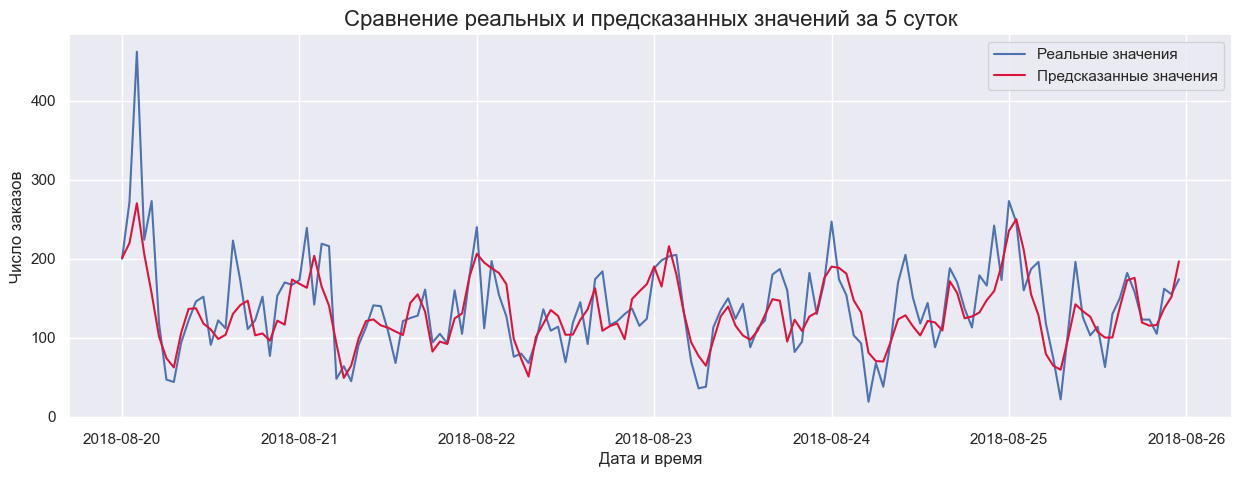

In [62]:
# сравним реальные значения с предсказанными

y_test_pred_3 = pd.Series(y_test_pred_3, index=y_test.index)

plt.figure(figsize=(15, 5))

plt.plot(y_test['2018-08-20':'2018-08-25'], label='Реальные значения')
plt.plot(y_test_pred_3['2018-08-20':'2018-08-25'], label='Предсказанные значения', color='crimson')

plt.xlabel('Дата и время')
plt.ylabel('Число заказов')
plt.title('Cравнение реальных и предсказанных значений за 5 суток', fontsize=16)

plt.legend()
plt.show()

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Видим на графике, что слабое место модели — это резкие взлёты и падения в количестве заказов. То есть, модель хуже справится с ситуацией, когда внезапное изменение погоды или ещё какой-то непредвиденный фактор приведут к резкому возрастанию спроса на такси
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Общий вывод
</div>

---

В ходе подготовки данных были подробно изучены сами данные, основные тенденции в них, тренды и сезонность. Созданы новые признаки на основе столбца `num_orders` — *календарные признаки*, такие как месяц, день месяца и день недели, а также *«отстающие значения»* и *скользящее среднее*

Были обучены следующие модели: `LinearRegression`, `DeciisionTreeRegressor` и `CatBoostRegressor`. По итогам обучения лучшей оказалась модель `CatBoostRegressor` со следующими гиперпараметрами:

- `random_strength`: 0.1
- `learning_rate`: 0.05
- `l2_leaf_reg`: 5
- `iterations`: 500
- `depth`: 6

Лучшая модель имеет следующие значения RMSE:

- `RMSE на тренировочной выборке`: 13.378709717244144
- `RMSE на тестовой выборке`: 38.81889270290209

Лучшая модель также прошла проверку на адекватность, совершённую с помощью константной модели `Dummy Regressor`:

- `RMSE на тестовой выборке для модели CatBoostRegressor`: 38.818893
- `RMSE на тестовой выборке для модели DummyRegressor`: 84.589229

---